In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K
from keras import metrics

import keras
from keras.engine.input_layer import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(368)
tf.set_random_seed(368)

Using TensorFlow backend.


In [2]:
%%time
train_df = pd.read_csv('input/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

Wall time: 1min 29s


In [3]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46909999847412109375
1,6,1.46909999847412109375
2,8,1.46909999847412109375
3,5,1.46909999847412109375
4,8,1.46909999847412109375


In [4]:
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

Find complete segments in the training data (time to failure goes to zero)

In [5]:
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)

train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)

[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


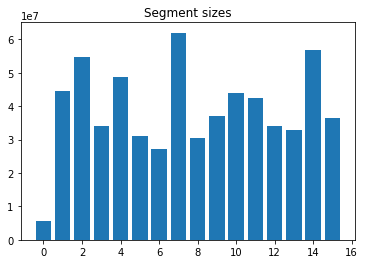

In [6]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

The generator samples randomly from the segmens without crossing the boundaries

In [7]:
class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
        segment = self.segments[segment_index]
        end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        #x_batch = (x_batch - self.x_mean)/self.x_std

        return np.expand_dims(x_batch, axis=2), y_batch

We could use any segments for training / validation

In [8]:
t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

I think it does not make big difference but lets not leak into the validation data and calculate mean and standrad deviation on the training data only.

In [9]:
x_sum = 0.
count = 0

for s in t_segments:
    x_sum += X_train[s[0]:s[1]].sum()
    count += (s[1] - s[0])

X_train_mean = x_sum/count

x2_sum = 0.
for s in t_segments:
    x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

X_train_std =  np.sqrt(x2_sum/count)

print(X_train_mean, X_train_std)

4.472289301190891 6.189013535612676


In [10]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = t_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

valid_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = v_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

In [11]:
print(train_gen)

Use convolutional layers to learn the features and reduce the time sequence length 

In [12]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [13]:
def CnnTransformerModel():
    i = Input(shape = (150000, 1))
    
    x = Convolution1D(16, kernel_size = 10, strides = 5, activation='relu')(i)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    ## x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pool, max_pool])
    y = Dense(1,activation = 'relu')(concat)
    

    return Model(inputs = [i], outputs = [y])

In [14]:
model = CnnTransformerModel()
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 1)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 29999, 16)    176         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 2999, 16)     2576        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)    

**Visualizing The Model Architecture**

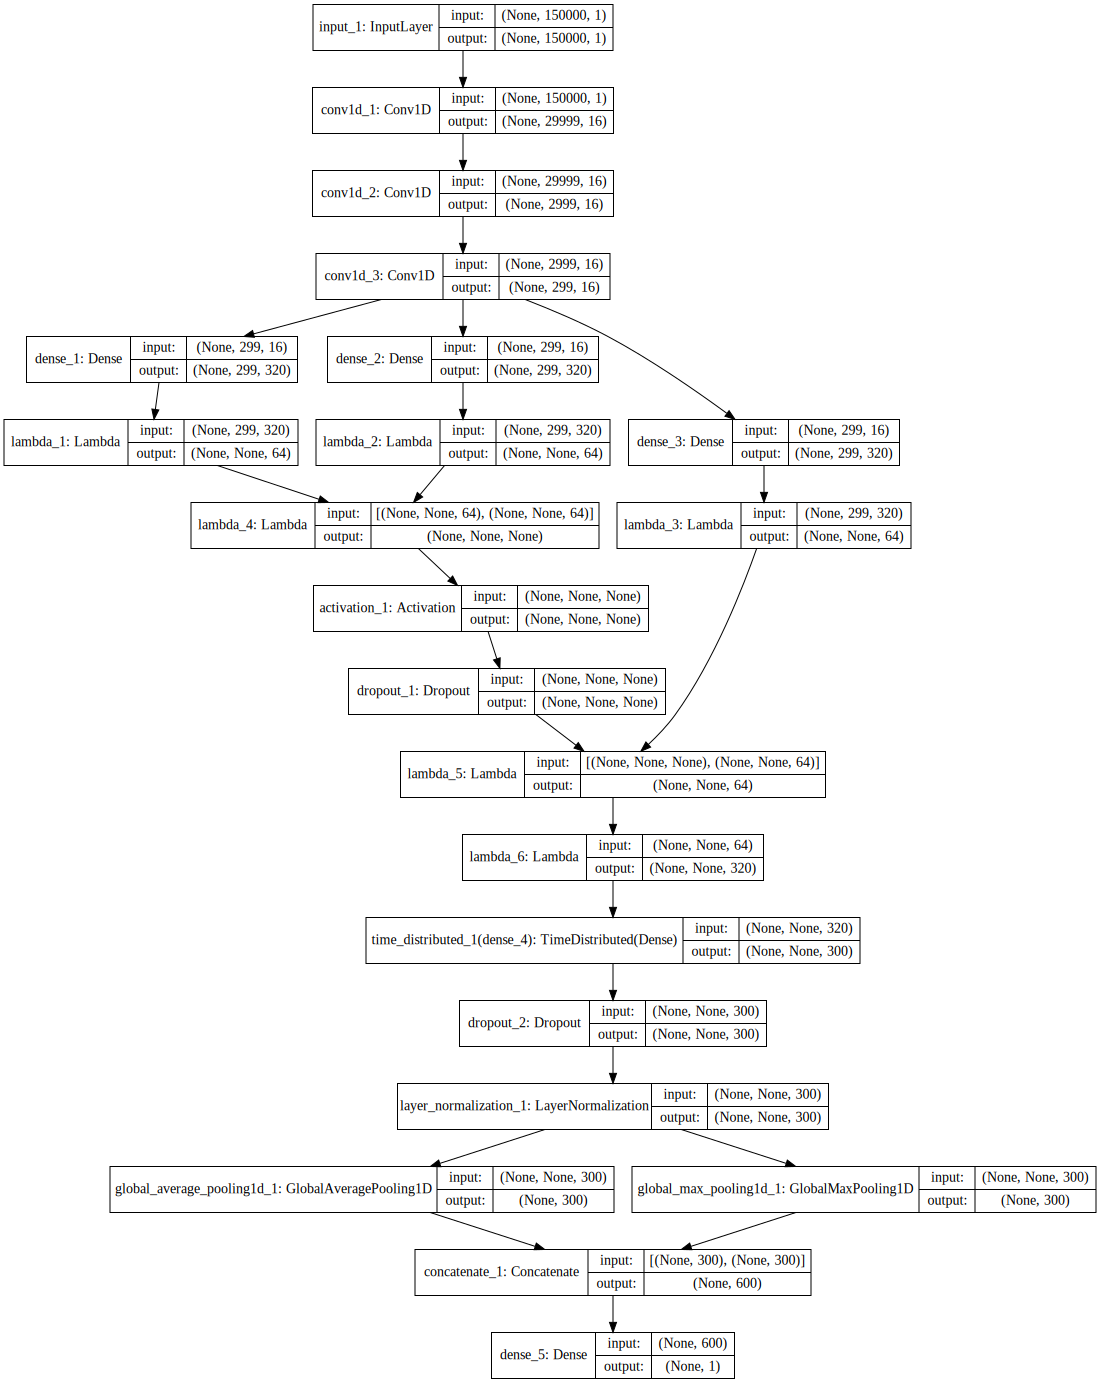

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [16]:
import time
start_time = time.time()
hist = model.fit_generator(
    generator =  train_gen,
    epochs = 150, 
    verbose = 1, 
    validation_data = valid_gen,
)
print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/150


146/400 [=========>....................] - ETA: 31:04 - loss: 18.8175 - mean_absolute_error: 3.669 - ETA: 15:47 - loss: 19.4596 - mean_absolute_error: 3.764 - ETA: 10:41 - loss: 20.4807 - mean_absolute_error: 3.806 - ETA: 8:08 - loss: 24.2435 - mean_absolute_error: 4.202 - ETA: 6:36 - loss: 23.3743 - mean_absolute_error: 4.09 - ETA: 5:35 - loss: 20.5013 - mean_absolute_error: 3.75 - ETA: 4:51 - loss: 18.5148 - mean_absolute_error: 3.54 - ETA: 4:18 - loss: 18.2196 - mean_absolute_error: 3.52 - ETA: 3:52 - loss: 18.4052 - mean_absolute_error: 3.53 - ETA: 3:32 - loss: 20.2158 - mean_absolute_error: 3.68 - ETA: 3:15 - loss: 20.8196 - mean_absolute_error: 3.74 - ETA: 3:01 - loss: 20.1927 - mean_absolute_error: 3.69 - ETA: 2:49 - loss: 19.8373 - mean_absolute_error: 3.66 - ETA: 2:39 - loss: 19.4935 - mean_absolute_error: 3.64 - ETA: 2:30 - loss: 19.5312 - mean_absolute_error: 3.65 - ETA: 2:22 - loss: 19.2391 - mean_absolute_error: 3.62 - ETA: 2:15 - loss: 18.6612 - mean_absolute_error: 3.55 

150/400 [==========>...................] - ETA: 33s - loss: 18.8999 - mean_absolute_error: 3.772 - ETA: 34s - loss: 12.3635 - mean_absolute_error: 2.837 - ETA: 34s - loss: 15.0941 - mean_absolute_error: 3.195 - ETA: 34s - loss: 14.6714 - mean_absolute_error: 3.161 - ETA: 34s - loss: 15.0069 - mean_absolute_error: 3.186 - ETA: 34s - loss: 14.3063 - mean_absolute_error: 3.111 - ETA: 33s - loss: 14.3687 - mean_absolute_error: 3.180 - ETA: 33s - loss: 14.6045 - mean_absolute_error: 3.238 - ETA: 33s - loss: 14.2318 - mean_absolute_error: 3.207 - ETA: 33s - loss: 14.4036 - mean_absolute_error: 3.242 - ETA: 32s - loss: 14.2944 - mean_absolute_error: 3.213 - ETA: 32s - loss: 13.9797 - mean_absolute_error: 3.191 - ETA: 32s - loss: 13.9549 - mean_absolute_error: 3.181 - ETA: 32s - loss: 13.2890 - mean_absolute_error: 3.079 - ETA: 32s - loss: 13.3128 - mean_absolute_error: 3.087 - ETA: 32s - loss: 12.8867 - mean_absolute_error: 3.021 - ETA: 32s - loss: 12.6857 - mean_absolute_error: 2.996 - ETA: 

400/400 [==============================] - ETA: 8s - loss: 9.4165 - mean_absolute_error: 2.382 - ETA: 8s - loss: 9.4307 - mean_absolute_error: 2.385 - ETA: 8s - loss: 9.4262 - mean_absolute_error: 2.386 - ETA: 8s - loss: 9.4348 - mean_absolute_error: 2.387 - ETA: 8s - loss: 9.4529 - mean_absolute_error: 2.390 - ETA: 8s - loss: 9.4575 - mean_absolute_error: 2.392 - ETA: 7s - loss: 9.4635 - mean_absolute_error: 2.394 - ETA: 7s - loss: 9.4731 - mean_absolute_error: 2.395 - ETA: 7s - loss: 9.4941 - mean_absolute_error: 2.400 - ETA: 7s - loss: 9.4876 - mean_absolute_error: 2.398 - ETA: 7s - loss: 9.5101 - mean_absolute_error: 2.403 - ETA: 7s - loss: 9.5045 - mean_absolute_error: 2.402 - ETA: 7s - loss: 9.5225 - mean_absolute_error: 2.405 - ETA: 7s - loss: 9.5324 - mean_absolute_error: 2.407 - ETA: 7s - loss: 9.5261 - mean_absolute_error: 2.406 - ETA: 7s - loss: 9.5143 - mean_absolute_error: 2.404 - ETA: 7s - loss: 9.4968 - mean_absolute_error: 2.402 - ETA: 6s - loss: 9.4852 - mean_absolute_

149/400 [==========>...................] - ETA: 37s - loss: 16.0013 - mean_absolute_error: 3.336 - ETA: 37s - loss: 15.9628 - mean_absolute_error: 3.402 - ETA: 37s - loss: 16.3957 - mean_absolute_error: 3.583 - ETA: 36s - loss: 16.0075 - mean_absolute_error: 3.497 - ETA: 36s - loss: 14.7193 - mean_absolute_error: 3.340 - ETA: 35s - loss: 14.8117 - mean_absolute_error: 3.400 - ETA: 35s - loss: 13.2296 - mean_absolute_error: 3.141 - ETA: 35s - loss: 13.0142 - mean_absolute_error: 3.115 - ETA: 34s - loss: 12.3533 - mean_absolute_error: 2.978 - ETA: 34s - loss: 11.6940 - mean_absolute_error: 2.877 - ETA: 34s - loss: 12.4981 - mean_absolute_error: 2.964 - ETA: 33s - loss: 11.8191 - mean_absolute_error: 2.833 - ETA: 33s - loss: 12.3707 - mean_absolute_error: 2.897 - ETA: 33s - loss: 12.1991 - mean_absolute_error: 2.888 - ETA: 33s - loss: 12.1758 - mean_absolute_error: 2.891 - ETA: 33s - loss: 12.4083 - mean_absolute_error: 2.930 - ETA: 33s - loss: 12.2518 - mean_absolute_error: 2.925 - ETA: 

151/400 [==========>...................] - ETA: 33s - loss: 4.4866 - mean_absolute_error: 1.88 - ETA: 34s - loss: 4.2842 - mean_absolute_error: 1.70 - ETA: 34s - loss: 5.7098 - mean_absolute_error: 1.99 - ETA: 35s - loss: 9.6952 - mean_absolute_error: 2.50 - ETA: 35s - loss: 8.0853 - mean_absolute_error: 2.21 - ETA: 35s - loss: 7.8765 - mean_absolute_error: 2.21 - ETA: 34s - loss: 10.1094 - mean_absolute_error: 2.463 - ETA: 34s - loss: 9.0530 - mean_absolute_error: 2.272 - ETA: 34s - loss: 10.0136 - mean_absolute_error: 2.398 - ETA: 34s - loss: 10.3963 - mean_absolute_error: 2.486 - ETA: 34s - loss: 10.3595 - mean_absolute_error: 2.530 - ETA: 34s - loss: 9.8305 - mean_absolute_error: 2.437 - ETA: 34s - loss: 9.5900 - mean_absolute_error: 2.41 - ETA: 33s - loss: 9.2453 - mean_absolute_error: 2.35 - ETA: 33s - loss: 9.3586 - mean_absolute_error: 2.39 - ETA: 33s - loss: 9.8088 - mean_absolute_error: 2.45 - ETA: 33s - loss: 9.9423 - mean_absolute_error: 2.50 - ETA: 33s - loss: 9.5872 - mea

400/400 [==============================] - ETA: 8s - loss: 9.2027 - mean_absolute_error: 2.344 - ETA: 8s - loss: 9.2371 - mean_absolute_error: 2.348 - ETA: 8s - loss: 9.2639 - mean_absolute_error: 2.352 - ETA: 8s - loss: 9.2965 - mean_absolute_error: 2.356 - ETA: 7s - loss: 9.3116 - mean_absolute_error: 2.359 - ETA: 7s - loss: 9.3056 - mean_absolute_error: 2.359 - ETA: 7s - loss: 9.2858 - mean_absolute_error: 2.356 - ETA: 7s - loss: 9.3146 - mean_absolute_error: 2.360 - ETA: 7s - loss: 9.3274 - mean_absolute_error: 2.363 - ETA: 7s - loss: 9.3174 - mean_absolute_error: 2.361 - ETA: 7s - loss: 9.3098 - mean_absolute_error: 2.360 - ETA: 7s - loss: 9.2928 - mean_absolute_error: 2.358 - ETA: 7s - loss: 9.2929 - mean_absolute_error: 2.358 - ETA: 7s - loss: 9.3046 - mean_absolute_error: 2.361 - ETA: 7s - loss: 9.3065 - mean_absolute_error: 2.362 - ETA: 7s - loss: 9.2952 - mean_absolute_error: 2.360 - ETA: 6s - loss: 9.3016 - mean_absolute_error: 2.362 - ETA: 6s - loss: 9.3274 - mean_absolute_

147/400 [==========>...................] - ETA: 39s - loss: 7.6023 - mean_absolute_error: 2.56 - ETA: 37s - loss: 5.0838 - mean_absolute_error: 1.96 - ETA: 36s - loss: 4.8768 - mean_absolute_error: 1.93 - ETA: 37s - loss: 4.8001 - mean_absolute_error: 1.86 - ETA: 36s - loss: 4.2998 - mean_absolute_error: 1.68 - ETA: 36s - loss: 4.0878 - mean_absolute_error: 1.58 - ETA: 35s - loss: 3.9041 - mean_absolute_error: 1.55 - ETA: 35s - loss: 4.7405 - mean_absolute_error: 1.70 - ETA: 35s - loss: 4.4583 - mean_absolute_error: 1.63 - ETA: 34s - loss: 4.8053 - mean_absolute_error: 1.70 - ETA: 34s - loss: 6.6651 - mean_absolute_error: 1.94 - ETA: 34s - loss: 7.0576 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.7904 - mean_absolute_error: 1.98 - ETA: 34s - loss: 8.4145 - mean_absolute_error: 2.17 - ETA: 34s - loss: 8.3778 - mean_absolute_error: 2.19 - ETA: 33s - loss: 8.9991 - mean_absolute_error: 2.27 - ETA: 33s - loss: 8.8087 - mean_absolute_error: 2.26 - ETA: 33s - loss: 8.5259 - mean_absolute

151/400 [==========>...................] - ETA: 37s - loss: 8.1243 - mean_absolute_error: 2.09 - ETA: 36s - loss: 6.0417 - mean_absolute_error: 1.84 - ETA: 35s - loss: 8.2164 - mean_absolute_error: 2.29 - ETA: 35s - loss: 9.4787 - mean_absolute_error: 2.54 - ETA: 35s - loss: 8.4748 - mean_absolute_error: 2.35 - ETA: 34s - loss: 8.5614 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.2928 - mean_absolute_error: 2.41 - ETA: 34s - loss: 9.0736 - mean_absolute_error: 2.54 - ETA: 34s - loss: 8.6375 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.6864 - mean_absolute_error: 2.46 - ETA: 34s - loss: 8.3603 - mean_absolute_error: 2.39 - ETA: 33s - loss: 9.1092 - mean_absolute_error: 2.50 - ETA: 33s - loss: 9.7259 - mean_absolute_error: 2.58 - ETA: 33s - loss: 10.3894 - mean_absolute_error: 2.684 - ETA: 33s - loss: 9.8401 - mean_absolute_error: 2.589 - ETA: 33s - loss: 9.4744 - mean_absolute_error: 2.53 - ETA: 33s - loss: 10.0595 - mean_absolute_error: 2.604 - ETA: 33s - loss: 9.6782 - mean_abs

400/400 [==============================] - ETA: 8s - loss: 8.6627 - mean_absolute_error: 2.339 - ETA: 8s - loss: 8.6781 - mean_absolute_error: 2.343 - ETA: 8s - loss: 8.6950 - mean_absolute_error: 2.345 - ETA: 8s - loss: 8.6898 - mean_absolute_error: 2.345 - ETA: 7s - loss: 8.7085 - mean_absolute_error: 2.349 - ETA: 7s - loss: 8.7204 - mean_absolute_error: 2.352 - ETA: 7s - loss: 8.7043 - mean_absolute_error: 2.349 - ETA: 7s - loss: 8.7294 - mean_absolute_error: 2.352 - ETA: 7s - loss: 8.7177 - mean_absolute_error: 2.350 - ETA: 7s - loss: 8.7080 - mean_absolute_error: 2.348 - ETA: 7s - loss: 8.6877 - mean_absolute_error: 2.344 - ETA: 7s - loss: 8.6898 - mean_absolute_error: 2.346 - ETA: 7s - loss: 8.6809 - mean_absolute_error: 2.345 - ETA: 7s - loss: 8.6761 - mean_absolute_error: 2.344 - ETA: 7s - loss: 8.6684 - mean_absolute_error: 2.343 - ETA: 7s - loss: 8.6635 - mean_absolute_error: 2.343 - ETA: 6s - loss: 8.7024 - mean_absolute_error: 2.349 - ETA: 6s - loss: 8.6809 - mean_absolute_

150/400 [==========>...................] - ETA: 36s - loss: 6.0602 - mean_absolute_error: 1.83 - ETA: 37s - loss: 12.5844 - mean_absolute_error: 2.826 - ETA: 36s - loss: 11.6441 - mean_absolute_error: 2.822 - ETA: 36s - loss: 10.7046 - mean_absolute_error: 2.793 - ETA: 36s - loss: 10.2256 - mean_absolute_error: 2.732 - ETA: 36s - loss: 11.0942 - mean_absolute_error: 2.782 - ETA: 35s - loss: 10.4571 - mean_absolute_error: 2.640 - ETA: 35s - loss: 11.6128 - mean_absolute_error: 2.770 - ETA: 34s - loss: 11.0297 - mean_absolute_error: 2.702 - ETA: 34s - loss: 10.2112 - mean_absolute_error: 2.578 - ETA: 34s - loss: 9.4560 - mean_absolute_error: 2.441 - ETA: 34s - loss: 10.4536 - mean_absolute_error: 2.564 - ETA: 33s - loss: 11.1614 - mean_absolute_error: 2.674 - ETA: 33s - loss: 10.5475 - mean_absolute_error: 2.585 - ETA: 33s - loss: 11.1353 - mean_absolute_error: 2.659 - ETA: 33s - loss: 10.7901 - mean_absolute_error: 2.632 - ETA: 33s - loss: 10.2711 - mean_absolute_error: 2.548 - ETA: 33s

151/400 [==========>...................] - ETA: 36s - loss: 8.5023 - mean_absolute_error: 2.46 - ETA: 37s - loss: 6.2401 - mean_absolute_error: 1.94 - ETA: 37s - loss: 10.4579 - mean_absolute_error: 2.526 - ETA: 36s - loss: 14.6537 - mean_absolute_error: 3.045 - ETA: 36s - loss: 16.1701 - mean_absolute_error: 3.279 - ETA: 35s - loss: 13.8996 - mean_absolute_error: 2.921 - ETA: 35s - loss: 12.8791 - mean_absolute_error: 2.812 - ETA: 35s - loss: 12.3472 - mean_absolute_error: 2.759 - ETA: 34s - loss: 11.2523 - mean_absolute_error: 2.571 - ETA: 34s - loss: 11.6510 - mean_absolute_error: 2.661 - ETA: 34s - loss: 11.1217 - mean_absolute_error: 2.614 - ETA: 34s - loss: 10.5900 - mean_absolute_error: 2.555 - ETA: 34s - loss: 10.2152 - mean_absolute_error: 2.507 - ETA: 34s - loss: 10.0321 - mean_absolute_error: 2.501 - ETA: 34s - loss: 9.6295 - mean_absolute_error: 2.427 - ETA: 34s - loss: 9.1736 - mean_absolute_error: 2.35 - ETA: 33s - loss: 9.0143 - mean_absolute_error: 2.34 - ETA: 33s - los

400/400 [==============================] - ETA: 8s - loss: 8.1452 - mean_absolute_error: 2.188 - ETA: 8s - loss: 8.1279 - mean_absolute_error: 2.184 - ETA: 8s - loss: 8.1117 - mean_absolute_error: 2.182 - ETA: 8s - loss: 8.1010 - mean_absolute_error: 2.180 - ETA: 7s - loss: 8.1422 - mean_absolute_error: 2.186 - ETA: 7s - loss: 8.1916 - mean_absolute_error: 2.193 - ETA: 7s - loss: 8.2356 - mean_absolute_error: 2.200 - ETA: 7s - loss: 8.2178 - mean_absolute_error: 2.196 - ETA: 7s - loss: 8.2751 - mean_absolute_error: 2.203 - ETA: 7s - loss: 8.2596 - mean_absolute_error: 2.200 - ETA: 7s - loss: 8.3042 - mean_absolute_error: 2.206 - ETA: 7s - loss: 8.3060 - mean_absolute_error: 2.208 - ETA: 7s - loss: 8.3228 - mean_absolute_error: 2.211 - ETA: 7s - loss: 8.3199 - mean_absolute_error: 2.211 - ETA: 7s - loss: 8.2988 - mean_absolute_error: 2.207 - ETA: 7s - loss: 8.2898 - mean_absolute_error: 2.207 - ETA: 6s - loss: 8.3181 - mean_absolute_error: 2.211 - ETA: 6s - loss: 8.3146 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 22.6391 - mean_absolute_error: 3.999 - ETA: 37s - loss: 23.2596 - mean_absolute_error: 4.081 - ETA: 36s - loss: 23.2582 - mean_absolute_error: 4.137 - ETA: 36s - loss: 19.3044 - mean_absolute_error: 3.718 - ETA: 36s - loss: 16.7498 - mean_absolute_error: 3.369 - ETA: 35s - loss: 14.9649 - mean_absolute_error: 3.121 - ETA: 35s - loss: 13.5653 - mean_absolute_error: 2.900 - ETA: 35s - loss: 12.4250 - mean_absolute_error: 2.761 - ETA: 35s - loss: 12.0824 - mean_absolute_error: 2.744 - ETA: 34s - loss: 11.4891 - mean_absolute_error: 2.668 - ETA: 34s - loss: 11.0301 - mean_absolute_error: 2.627 - ETA: 34s - loss: 10.4903 - mean_absolute_error: 2.551 - ETA: 34s - loss: 10.0352 - mean_absolute_error: 2.493 - ETA: 34s - loss: 9.5938 - mean_absolute_error: 2.436 - ETA: 33s - loss: 9.3386 - mean_absolute_error: 2.39 - ETA: 33s - loss: 9.0670 - mean_absolute_error: 2.37 - ETA: 33s - loss: 8.7125 - mean_absolute_error: 2.33 - ETA: 33s - l

151/400 [==========>...................] - ETA: 37s - loss: 4.7041 - mean_absolute_error: 1.64 - ETA: 36s - loss: 4.0956 - mean_absolute_error: 1.50 - ETA: 36s - loss: 7.5867 - mean_absolute_error: 1.99 - ETA: 35s - loss: 6.4771 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.7219 - mean_absolute_error: 1.63 - ETA: 34s - loss: 8.7631 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.8678 - mean_absolute_error: 1.97 - ETA: 34s - loss: 7.9333 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.4029 - mean_absolute_error: 1.92 - ETA: 33s - loss: 7.3255 - mean_absolute_error: 1.95 - ETA: 33s - loss: 6.8413 - mean_absolute_error: 1.88 - ETA: 33s - loss: 6.6694 - mean_absolute_error: 1.83 - ETA: 33s - loss: 7.6853 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.7329 - mean_absolute_error: 2.04 - ETA: 33s - loss: 7.5443 - mean_absolute_error: 2.03 - ETA: 33s - loss: 7.8969 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.5587 - mean_absolute_error: 2.05 - ETA: 33s - loss: 7.4558 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.4606 - mean_absolute_error: 2.254 - ETA: 8s - loss: 8.4502 - mean_absolute_error: 2.253 - ETA: 8s - loss: 8.4317 - mean_absolute_error: 2.250 - ETA: 8s - loss: 8.4205 - mean_absolute_error: 2.247 - ETA: 7s - loss: 8.4003 - mean_absolute_error: 2.243 - ETA: 7s - loss: 8.3793 - mean_absolute_error: 2.240 - ETA: 7s - loss: 8.4356 - mean_absolute_error: 2.247 - ETA: 7s - loss: 8.4156 - mean_absolute_error: 2.243 - ETA: 7s - loss: 8.3959 - mean_absolute_error: 2.240 - ETA: 7s - loss: 8.3840 - mean_absolute_error: 2.238 - ETA: 7s - loss: 8.3648 - mean_absolute_error: 2.235 - ETA: 7s - loss: 8.3544 - mean_absolute_error: 2.234 - ETA: 7s - loss: 8.3411 - mean_absolute_error: 2.232 - ETA: 7s - loss: 8.3234 - mean_absolute_error: 2.229 - ETA: 7s - loss: 8.3115 - mean_absolute_error: 2.227 - ETA: 7s - loss: 8.2941 - mean_absolute_error: 2.224 - ETA: 6s - loss: 8.2773 - mean_absolute_error: 2.221 - ETA: 6s - loss: 8.2737 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 5.3510 - mean_absolute_error: 1.96 - ETA: 34s - loss: 4.7099 - mean_absolute_error: 1.75 - ETA: 34s - loss: 7.1453 - mean_absolute_error: 2.19 - ETA: 35s - loss: 8.3177 - mean_absolute_error: 2.44 - ETA: 35s - loss: 8.1011 - mean_absolute_error: 2.36 - ETA: 35s - loss: 8.2577 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.9724 - mean_absolute_error: 2.51 - ETA: 34s - loss: 8.8457 - mean_absolute_error: 2.47 - ETA: 34s - loss: 8.7825 - mean_absolute_error: 2.48 - ETA: 34s - loss: 8.8752 - mean_absolute_error: 2.51 - ETA: 34s - loss: 9.4356 - mean_absolute_error: 2.59 - ETA: 34s - loss: 9.4634 - mean_absolute_error: 2.61 - ETA: 34s - loss: 9.2357 - mean_absolute_error: 2.58 - ETA: 33s - loss: 8.8679 - mean_absolute_error: 2.49 - ETA: 33s - loss: 8.4908 - mean_absolute_error: 2.43 - ETA: 33s - loss: 8.2791 - mean_absolute_error: 2.40 - ETA: 33s - loss: 8.1415 - mean_absolute_error: 2.36 - ETA: 33s - loss: 9.3318 - mean_absolute

149/400 [==========>...................] - ETA: 37s - loss: 26.9716 - mean_absolute_error: 4.375 - ETA: 37s - loss: 28.6158 - mean_absolute_error: 4.527 - ETA: 37s - loss: 19.7663 - mean_absolute_error: 3.369 - ETA: 37s - loss: 21.0527 - mean_absolute_error: 3.640 - ETA: 36s - loss: 17.6930 - mean_absolute_error: 3.207 - ETA: 36s - loss: 15.1643 - mean_absolute_error: 2.863 - ETA: 35s - loss: 13.8514 - mean_absolute_error: 2.738 - ETA: 35s - loss: 12.6376 - mean_absolute_error: 2.576 - ETA: 35s - loss: 11.9921 - mean_absolute_error: 2.517 - ETA: 35s - loss: 11.2677 - mean_absolute_error: 2.453 - ETA: 34s - loss: 12.4072 - mean_absolute_error: 2.600 - ETA: 34s - loss: 11.7802 - mean_absolute_error: 2.513 - ETA: 34s - loss: 12.3606 - mean_absolute_error: 2.622 - ETA: 34s - loss: 13.1095 - mean_absolute_error: 2.720 - ETA: 34s - loss: 12.3372 - mean_absolute_error: 2.601 - ETA: 34s - loss: 11.8778 - mean_absolute_error: 2.566 - ETA: 33s - loss: 11.4089 - mean_absolute_error: 2.507 - ETA: 

400/400 [==============================] - ETA: 8s - loss: 8.6249 - mean_absolute_error: 2.268 - ETA: 8s - loss: 8.6182 - mean_absolute_error: 2.267 - ETA: 8s - loss: 8.6566 - mean_absolute_error: 2.273 - ETA: 8s - loss: 8.6460 - mean_absolute_error: 2.271 - ETA: 8s - loss: 8.6341 - mean_absolute_error: 2.268 - ETA: 8s - loss: 8.6319 - mean_absolute_error: 2.270 - ETA: 7s - loss: 8.6380 - mean_absolute_error: 2.272 - ETA: 7s - loss: 8.6418 - mean_absolute_error: 2.274 - ETA: 7s - loss: 8.6197 - mean_absolute_error: 2.270 - ETA: 7s - loss: 8.6564 - mean_absolute_error: 2.275 - ETA: 7s - loss: 8.6800 - mean_absolute_error: 2.278 - ETA: 7s - loss: 8.6606 - mean_absolute_error: 2.275 - ETA: 7s - loss: 8.6525 - mean_absolute_error: 2.274 - ETA: 7s - loss: 8.6333 - mean_absolute_error: 2.271 - ETA: 7s - loss: 8.6245 - mean_absolute_error: 2.269 - ETA: 7s - loss: 8.6011 - mean_absolute_error: 2.264 - ETA: 7s - loss: 8.5926 - mean_absolute_error: 2.264 - ETA: 7s - loss: 8.6382 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 2.7271 - mean_absolute_error: 1.02 - ETA: 37s - loss: 8.6097 - mean_absolute_error: 2.09 - ETA: 36s - loss: 7.7546 - mean_absolute_error: 2.02 - ETA: 36s - loss: 8.3323 - mean_absolute_error: 2.28 - ETA: 36s - loss: 7.5802 - mean_absolute_error: 2.13 - ETA: 35s - loss: 7.5355 - mean_absolute_error: 2.16 - ETA: 35s - loss: 7.0841 - mean_absolute_error: 2.06 - ETA: 35s - loss: 7.5661 - mean_absolute_error: 2.15 - ETA: 35s - loss: 7.6146 - mean_absolute_error: 2.18 - ETA: 35s - loss: 7.0406 - mean_absolute_error: 2.07 - ETA: 35s - loss: 8.1083 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.8631 - mean_absolute_error: 2.18 - ETA: 34s - loss: 8.7413 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.3794 - mean_absolute_error: 2.25 - ETA: 34s - loss: 7.9970 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.7336 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.3965 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.1315 - mean_absolute

151/400 [==========>...................] - ETA: 37s - loss: 3.7396 - mean_absolute_error: 1.66 - ETA: 38s - loss: 4.6943 - mean_absolute_error: 1.92 - ETA: 37s - loss: 10.8893 - mean_absolute_error: 2.665 - ETA: 37s - loss: 9.6746 - mean_absolute_error: 2.534 - ETA: 36s - loss: 8.0930 - mean_absolute_error: 2.24 - ETA: 36s - loss: 7.1251 - mean_absolute_error: 2.05 - ETA: 35s - loss: 6.5729 - mean_absolute_error: 1.97 - ETA: 35s - loss: 6.4003 - mean_absolute_error: 1.88 - ETA: 35s - loss: 8.4604 - mean_absolute_error: 2.15 - ETA: 35s - loss: 8.0514 - mean_absolute_error: 2.07 - ETA: 34s - loss: 7.9322 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.7148 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.5400 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.3327 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.9356 - mean_absolute_error: 1.94 - ETA: 34s - loss: 6.6016 - mean_absolute_error: 1.89 - ETA: 34s - loss: 6.5485 - mean_absolute_error: 1.88 - ETA: 33s - loss: 6.9703 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 8.1673 - mean_absolute_error: 2.229 - ETA: 8s - loss: 8.1767 - mean_absolute_error: 2.231 - ETA: 8s - loss: 8.1554 - mean_absolute_error: 2.227 - ETA: 8s - loss: 8.1778 - mean_absolute_error: 2.231 - ETA: 8s - loss: 8.1588 - mean_absolute_error: 2.228 - ETA: 7s - loss: 8.1564 - mean_absolute_error: 2.228 - ETA: 7s - loss: 8.1402 - mean_absolute_error: 2.225 - ETA: 7s - loss: 8.1220 - mean_absolute_error: 2.222 - ETA: 7s - loss: 8.1123 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.0981 - mean_absolute_error: 2.217 - ETA: 7s - loss: 8.0926 - mean_absolute_error: 2.217 - ETA: 7s - loss: 8.0747 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.0632 - mean_absolute_error: 2.211 - ETA: 7s - loss: 8.1198 - mean_absolute_error: 2.217 - ETA: 7s - loss: 8.1562 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.1782 - mean_absolute_error: 2.226 - ETA: 6s - loss: 8.2041 - mean_absolute_error: 2.230 - ETA: 6s - loss: 8.1873 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 3.6604 - mean_absolute_error: 1.71 - ETA: 35s - loss: 3.2402 - mean_absolute_error: 1.44 - ETA: 35s - loss: 6.4534 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.0789 - mean_absolute_error: 1.89 - ETA: 35s - loss: 7.3303 - mean_absolute_error: 2.10 - ETA: 35s - loss: 6.4243 - mean_absolute_error: 1.92 - ETA: 34s - loss: 6.1059 - mean_absolute_error: 1.84 - ETA: 34s - loss: 6.9799 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.7021 - mean_absolute_error: 1.97 - ETA: 34s - loss: 7.3605 - mean_absolute_error: 2.10 - ETA: 34s - loss: 7.2139 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.8552 - mean_absolute_error: 2.16 - ETA: 34s - loss: 7.6925 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.6500 - mean_absolute_error: 2.14 - ETA: 33s - loss: 8.0208 - mean_absolute_error: 2.23 - ETA: 33s - loss: 7.6729 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.2909 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.2770 - mean_absolute

150/400 [==========>...................] - ETA: 35s - loss: 6.2109 - mean_absolute_error: 2.18 - ETA: 37s - loss: 11.1866 - mean_absolute_error: 3.035 - ETA: 37s - loss: 11.6504 - mean_absolute_error: 3.109 - ETA: 36s - loss: 11.8310 - mean_absolute_error: 3.097 - ETA: 36s - loss: 9.9069 - mean_absolute_error: 2.742 - ETA: 36s - loss: 11.0334 - mean_absolute_error: 2.842 - ETA: 35s - loss: 9.7929 - mean_absolute_error: 2.615 - ETA: 35s - loss: 9.3093 - mean_absolute_error: 2.52 - ETA: 34s - loss: 8.9017 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.4590 - mean_absolute_error: 2.34 - ETA: 34s - loss: 10.1359 - mean_absolute_error: 2.541 - ETA: 34s - loss: 11.8892 - mean_absolute_error: 2.733 - ETA: 34s - loss: 11.2614 - mean_absolute_error: 2.631 - ETA: 34s - loss: 12.2209 - mean_absolute_error: 2.745 - ETA: 33s - loss: 11.5680 - mean_absolute_error: 2.628 - ETA: 33s - loss: 11.0530 - mean_absolute_error: 2.529 - ETA: 33s - loss: 11.4076 - mean_absolute_error: 2.577 - ETA: 33s - loss

400/400 [==============================] - ETA: 8s - loss: 8.5126 - mean_absolute_error: 2.282 - ETA: 8s - loss: 8.4953 - mean_absolute_error: 2.279 - ETA: 8s - loss: 8.4836 - mean_absolute_error: 2.278 - ETA: 8s - loss: 8.5111 - mean_absolute_error: 2.283 - ETA: 8s - loss: 8.4999 - mean_absolute_error: 2.282 - ETA: 7s - loss: 8.4799 - mean_absolute_error: 2.279 - ETA: 7s - loss: 8.4690 - mean_absolute_error: 2.277 - ETA: 7s - loss: 8.4513 - mean_absolute_error: 2.274 - ETA: 7s - loss: 8.4693 - mean_absolute_error: 2.276 - ETA: 7s - loss: 8.4677 - mean_absolute_error: 2.277 - ETA: 7s - loss: 8.4500 - mean_absolute_error: 2.274 - ETA: 7s - loss: 8.4718 - mean_absolute_error: 2.279 - ETA: 7s - loss: 8.4598 - mean_absolute_error: 2.276 - ETA: 7s - loss: 8.4686 - mean_absolute_error: 2.278 - ETA: 7s - loss: 8.4581 - mean_absolute_error: 2.277 - ETA: 7s - loss: 8.4766 - mean_absolute_error: 2.280 - ETA: 7s - loss: 8.4592 - mean_absolute_error: 2.277 - ETA: 6s - loss: 8.4669 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 1.8509 - mean_absolute_error: 1.09 - ETA: 38s - loss: 10.2221 - mean_absolute_error: 2.389 - ETA: 38s - loss: 8.5494 - mean_absolute_error: 2.177 - ETA: 38s - loss: 8.3434 - mean_absolute_error: 2.24 - ETA: 38s - loss: 8.1271 - mean_absolute_error: 2.28 - ETA: 37s - loss: 7.5233 - mean_absolute_error: 2.19 - ETA: 37s - loss: 9.5526 - mean_absolute_error: 2.43 - ETA: 36s - loss: 8.8404 - mean_absolute_error: 2.33 - ETA: 36s - loss: 8.6023 - mean_absolute_error: 2.26 - ETA: 35s - loss: 8.4833 - mean_absolute_error: 2.28 - ETA: 35s - loss: 8.1703 - mean_absolute_error: 2.26 - ETA: 35s - loss: 7.9663 - mean_absolute_error: 2.24 - ETA: 35s - loss: 7.6657 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.4194 - mean_absolute_error: 2.15 - ETA: 35s - loss: 7.2644 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.8289 - mean_absolute_error: 2.18 - ETA: 34s - loss: 8.3901 - mean_absolute_error: 2.27 - ETA: 34s - loss: 8.2473 - mean_absol

151/400 [==========>...................] - ETA: 35s - loss: 15.3765 - mean_absolute_error: 3.537 - ETA: 36s - loss: 9.2009 - mean_absolute_error: 2.375 - ETA: 36s - loss: 9.3268 - mean_absolute_error: 2.46 - ETA: 37s - loss: 7.4901 - mean_absolute_error: 2.13 - ETA: 36s - loss: 10.0343 - mean_absolute_error: 2.486 - ETA: 36s - loss: 9.8300 - mean_absolute_error: 2.513 - ETA: 35s - loss: 8.6925 - mean_absolute_error: 2.31 - ETA: 35s - loss: 8.0217 - mean_absolute_error: 2.22 - ETA: 35s - loss: 7.9697 - mean_absolute_error: 2.25 - ETA: 35s - loss: 7.8526 - mean_absolute_error: 2.23 - ETA: 34s - loss: 8.8404 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.7874 - mean_absolute_error: 2.39 - ETA: 34s - loss: 8.5130 - mean_absolute_error: 2.35 - ETA: 34s - loss: 8.2024 - mean_absolute_error: 2.31 - ETA: 33s - loss: 7.8804 - mean_absolute_error: 2.26 - ETA: 33s - loss: 7.5002 - mean_absolute_error: 2.19 - ETA: 33s - loss: 7.7909 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.4689 - mean_ab

400/400 [==============================] - ETA: 8s - loss: 8.6121 - mean_absolute_error: 2.301 - ETA: 8s - loss: 8.7259 - mean_absolute_error: 2.313 - ETA: 8s - loss: 8.7377 - mean_absolute_error: 2.315 - ETA: 8s - loss: 8.7212 - mean_absolute_error: 2.312 - ETA: 7s - loss: 8.7123 - mean_absolute_error: 2.312 - ETA: 7s - loss: 8.6944 - mean_absolute_error: 2.309 - ETA: 7s - loss: 8.7333 - mean_absolute_error: 2.314 - ETA: 7s - loss: 8.7270 - mean_absolute_error: 2.314 - ETA: 7s - loss: 8.7245 - mean_absolute_error: 2.313 - ETA: 7s - loss: 8.7414 - mean_absolute_error: 2.317 - ETA: 7s - loss: 8.7656 - mean_absolute_error: 2.320 - ETA: 7s - loss: 8.7670 - mean_absolute_error: 2.321 - ETA: 7s - loss: 8.7522 - mean_absolute_error: 2.319 - ETA: 7s - loss: 8.7570 - mean_absolute_error: 2.321 - ETA: 7s - loss: 8.7407 - mean_absolute_error: 2.319 - ETA: 7s - loss: 8.7353 - mean_absolute_error: 2.319 - ETA: 6s - loss: 8.7322 - mean_absolute_error: 2.319 - ETA: 6s - loss: 8.7265 - mean_absolute_

150/400 [==========>...................] - ETA: 36s - loss: 22.7132 - mean_absolute_error: 4.007 - ETA: 35s - loss: 25.1493 - mean_absolute_error: 4.232 - ETA: 35s - loss: 18.1604 - mean_absolute_error: 3.409 - ETA: 35s - loss: 14.5735 - mean_absolute_error: 2.953 - ETA: 35s - loss: 17.4494 - mean_absolute_error: 3.304 - ETA: 35s - loss: 14.8615 - mean_absolute_error: 2.949 - ETA: 35s - loss: 16.0958 - mean_absolute_error: 3.112 - ETA: 34s - loss: 14.6395 - mean_absolute_error: 2.913 - ETA: 34s - loss: 15.4677 - mean_absolute_error: 3.031 - ETA: 34s - loss: 14.1053 - mean_absolute_error: 2.830 - ETA: 34s - loss: 13.0869 - mean_absolute_error: 2.697 - ETA: 34s - loss: 12.9123 - mean_absolute_error: 2.713 - ETA: 34s - loss: 12.7340 - mean_absolute_error: 2.730 - ETA: 33s - loss: 12.9289 - mean_absolute_error: 2.763 - ETA: 33s - loss: 12.7991 - mean_absolute_error: 2.785 - ETA: 33s - loss: 12.7236 - mean_absolute_error: 2.809 - ETA: 33s - loss: 12.2720 - mean_absolute_error: 2.733 - ETA: 

151/400 [==========>...................] - ETA: 37s - loss: 3.1478 - mean_absolute_error: 1.24 - ETA: 37s - loss: 7.2781 - mean_absolute_error: 2.09 - ETA: 37s - loss: 7.6171 - mean_absolute_error: 2.17 - ETA: 36s - loss: 6.5788 - mean_absolute_error: 1.97 - ETA: 36s - loss: 7.1777 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.0251 - mean_absolute_error: 2.03 - ETA: 35s - loss: 7.3788 - mean_absolute_error: 2.15 - ETA: 34s - loss: 6.7874 - mean_absolute_error: 2.05 - ETA: 34s - loss: 7.2825 - mean_absolute_error: 2.18 - ETA: 34s - loss: 7.5304 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.3001 - mean_absolute_error: 2.22 - ETA: 34s - loss: 6.9408 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.1071 - mean_absolute_error: 2.18 - ETA: 33s - loss: 6.8288 - mean_absolute_error: 2.11 - ETA: 33s - loss: 7.7815 - mean_absolute_error: 2.22 - ETA: 33s - loss: 8.4179 - mean_absolute_error: 2.29 - ETA: 33s - loss: 8.2484 - mean_absolute_error: 2.27 - ETA: 33s - loss: 8.2266 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.6281 - mean_absolute_error: 2.318 - ETA: 8s - loss: 8.6213 - mean_absolute_error: 2.318 - ETA: 8s - loss: 8.6004 - mean_absolute_error: 2.314 - ETA: 8s - loss: 8.5855 - mean_absolute_error: 2.312 - ETA: 7s - loss: 8.5689 - mean_absolute_error: 2.309 - ETA: 7s - loss: 8.5670 - mean_absolute_error: 2.310 - ETA: 7s - loss: 8.5555 - mean_absolute_error: 2.308 - ETA: 7s - loss: 8.5374 - mean_absolute_error: 2.304 - ETA: 7s - loss: 8.5235 - mean_absolute_error: 2.301 - ETA: 7s - loss: 8.5073 - mean_absolute_error: 2.298 - ETA: 7s - loss: 8.5000 - mean_absolute_error: 2.297 - ETA: 7s - loss: 8.4865 - mean_absolute_error: 2.294 - ETA: 7s - loss: 8.4796 - mean_absolute_error: 2.293 - ETA: 7s - loss: 8.5167 - mean_absolute_error: 2.298 - ETA: 7s - loss: 8.5070 - mean_absolute_error: 2.296 - ETA: 7s - loss: 8.5016 - mean_absolute_error: 2.296 - ETA: 6s - loss: 8.4860 - mean_absolute_error: 2.293 - ETA: 6s - loss: 8.4660 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.2615 - mean_absolute_error: 1.70 - ETA: 37s - loss: 3.6480 - mean_absolute_error: 1.46 - ETA: 36s - loss: 2.9440 - mean_absolute_error: 1.30 - ETA: 37s - loss: 7.7291 - mean_absolute_error: 2.03 - ETA: 36s - loss: 6.7681 - mean_absolute_error: 1.82 - ETA: 35s - loss: 6.4872 - mean_absolute_error: 1.80 - ETA: 35s - loss: 8.3544 - mean_absolute_error: 2.07 - ETA: 35s - loss: 7.6939 - mean_absolute_error: 1.97 - ETA: 35s - loss: 7.2201 - mean_absolute_error: 1.93 - ETA: 34s - loss: 7.0270 - mean_absolute_error: 1.92 - ETA: 34s - loss: 7.9139 - mean_absolute_error: 2.08 - ETA: 34s - loss: 9.0777 - mean_absolute_error: 2.25 - ETA: 34s - loss: 8.7853 - mean_absolute_error: 2.24 - ETA: 34s - loss: 9.8784 - mean_absolute_error: 2.38 - ETA: 34s - loss: 9.5893 - mean_absolute_error: 2.35 - ETA: 34s - loss: 9.0806 - mean_absolute_error: 2.26 - ETA: 33s - loss: 8.8932 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.6668 - mean_absolute

149/400 [==========>...................] - ETA: 36s - loss: 2.4617 - mean_absolute_error: 1.30 - ETA: 36s - loss: 2.0279 - mean_absolute_error: 1.19 - ETA: 36s - loss: 2.3855 - mean_absolute_error: 1.26 - ETA: 35s - loss: 8.6658 - mean_absolute_error: 2.05 - ETA: 35s - loss: 11.4620 - mean_absolute_error: 2.432 - ETA: 35s - loss: 13.3475 - mean_absolute_error: 2.736 - ETA: 34s - loss: 15.5965 - mean_absolute_error: 3.025 - ETA: 34s - loss: 14.0413 - mean_absolute_error: 2.790 - ETA: 34s - loss: 15.0940 - mean_absolute_error: 2.922 - ETA: 34s - loss: 13.9597 - mean_absolute_error: 2.773 - ETA: 34s - loss: 14.6396 - mean_absolute_error: 2.876 - ETA: 34s - loss: 15.1141 - mean_absolute_error: 2.945 - ETA: 34s - loss: 15.2938 - mean_absolute_error: 3.008 - ETA: 34s - loss: 14.4731 - mean_absolute_error: 2.917 - ETA: 34s - loss: 14.5613 - mean_absolute_error: 2.941 - ETA: 33s - loss: 14.3654 - mean_absolute_error: 2.951 - ETA: 33s - loss: 13.9999 - mean_absolute_error: 2.901 - ETA: 33s - lo

400/400 [==============================] - ETA: 8s - loss: 8.2830 - mean_absolute_error: 2.217 - ETA: 8s - loss: 8.2733 - mean_absolute_error: 2.215 - ETA: 8s - loss: 8.2776 - mean_absolute_error: 2.216 - ETA: 8s - loss: 8.2868 - mean_absolute_error: 2.218 - ETA: 8s - loss: 8.3092 - mean_absolute_error: 2.223 - ETA: 8s - loss: 8.2934 - mean_absolute_error: 2.220 - ETA: 8s - loss: 8.2856 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.2894 - mean_absolute_error: 2.222 - ETA: 7s - loss: 8.2774 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.2623 - mean_absolute_error: 2.217 - ETA: 7s - loss: 8.2462 - mean_absolute_error: 2.214 - ETA: 7s - loss: 8.2837 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.3086 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.2905 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.2729 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.2591 - mean_absolute_error: 2.216 - ETA: 7s - loss: 8.2423 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.2725 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.0908 - mean_absolute_error: 2.04 - ETA: 36s - loss: 4.2410 - mean_absolute_error: 1.75 - ETA: 36s - loss: 4.0917 - mean_absolute_error: 1.74 - ETA: 36s - loss: 4.4352 - mean_absolute_error: 1.66 - ETA: 36s - loss: 4.0339 - mean_absolute_error: 1.59 - ETA: 35s - loss: 4.2752 - mean_absolute_error: 1.65 - ETA: 35s - loss: 4.1139 - mean_absolute_error: 1.61 - ETA: 35s - loss: 5.0662 - mean_absolute_error: 1.77 - ETA: 35s - loss: 5.0112 - mean_absolute_error: 1.73 - ETA: 34s - loss: 4.9914 - mean_absolute_error: 1.71 - ETA: 34s - loss: 5.2310 - mean_absolute_error: 1.77 - ETA: 34s - loss: 5.3540 - mean_absolute_error: 1.77 - ETA: 34s - loss: 5.4447 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.2517 - mean_absolute_error: 1.78 - ETA: 34s - loss: 5.0794 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.7882 - mean_absolute_error: 1.85 - ETA: 33s - loss: 5.6915 - mean_absolute_error: 1.84 - ETA: 33s - loss: 5.9213 - mean_absolute

150/400 [==========>...................] - ETA: 36s - loss: 4.7284 - mean_absolute_error: 1.34 - ETA: 38s - loss: 12.5146 - mean_absolute_error: 2.539 - ETA: 36s - loss: 10.0687 - mean_absolute_error: 2.365 - ETA: 36s - loss: 12.9010 - mean_absolute_error: 2.768 - ETA: 36s - loss: 10.5167 - mean_absolute_error: 2.381 - ETA: 36s - loss: 11.3111 - mean_absolute_error: 2.512 - ETA: 35s - loss: 10.9917 - mean_absolute_error: 2.551 - ETA: 35s - loss: 10.7054 - mean_absolute_error: 2.557 - ETA: 35s - loss: 11.3830 - mean_absolute_error: 2.647 - ETA: 34s - loss: 10.7100 - mean_absolute_error: 2.523 - ETA: 34s - loss: 10.6904 - mean_absolute_error: 2.547 - ETA: 34s - loss: 11.0843 - mean_absolute_error: 2.608 - ETA: 34s - loss: 10.3900 - mean_absolute_error: 2.493 - ETA: 34s - loss: 10.4164 - mean_absolute_error: 2.523 - ETA: 33s - loss: 10.5803 - mean_absolute_error: 2.552 - ETA: 33s - loss: 10.7080 - mean_absolute_error: 2.586 - ETA: 33s - loss: 10.6901 - mean_absolute_error: 2.608 - ETA: 33

400/400 [==============================] - ETA: 8s - loss: 7.8667 - mean_absolute_error: 2.155 - ETA: 8s - loss: 7.8566 - mean_absolute_error: 2.154 - ETA: 8s - loss: 7.8496 - mean_absolute_error: 2.153 - ETA: 8s - loss: 7.8273 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.8125 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.8775 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.8688 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.8475 - mean_absolute_error: 2.149 - ETA: 7s - loss: 7.9170 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.9032 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.8866 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.8776 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.8728 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.8593 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.8438 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.8949 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.9172 - mean_absolute_error: 2.158 - ETA: 6s - loss: 7.9075 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 3.5470 - mean_absolute_error: 1.29 - ETA: 35s - loss: 6.2989 - mean_absolute_error: 2.06 - ETA: 36s - loss: 6.0975 - mean_absolute_error: 1.87 - ETA: 36s - loss: 6.4400 - mean_absolute_error: 2.02 - ETA: 36s - loss: 5.8370 - mean_absolute_error: 1.95 - ETA: 35s - loss: 5.3919 - mean_absolute_error: 1.87 - ETA: 35s - loss: 6.2323 - mean_absolute_error: 2.03 - ETA: 35s - loss: 7.0999 - mean_absolute_error: 2.18 - ETA: 34s - loss: 7.4251 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.1384 - mean_absolute_error: 2.18 - ETA: 34s - loss: 6.9955 - mean_absolute_error: 2.17 - ETA: 34s - loss: 6.8320 - mean_absolute_error: 2.10 - ETA: 34s - loss: 6.3983 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.2159 - mean_absolute_error: 1.96 - ETA: 33s - loss: 5.9868 - mean_absolute_error: 1.91 - ETA: 33s - loss: 5.7680 - mean_absolute_error: 1.85 - ETA: 33s - loss: 6.7071 - mean_absolute_error: 1.99 - ETA: 33s - loss: 7.4194 - mean_absolute

151/400 [==========>...................] - ETA: 37s - loss: 3.8053 - mean_absolute_error: 1.81 - ETA: 35s - loss: 3.5859 - mean_absolute_error: 1.67 - ETA: 35s - loss: 3.9935 - mean_absolute_error: 1.76 - ETA: 35s - loss: 7.1176 - mean_absolute_error: 2.19 - ETA: 35s - loss: 10.7584 - mean_absolute_error: 2.600 - ETA: 35s - loss: 12.3769 - mean_absolute_error: 2.787 - ETA: 35s - loss: 14.0750 - mean_absolute_error: 2.996 - ETA: 34s - loss: 12.9750 - mean_absolute_error: 2.839 - ETA: 34s - loss: 12.0956 - mean_absolute_error: 2.722 - ETA: 34s - loss: 11.1101 - mean_absolute_error: 2.577 - ETA: 34s - loss: 11.4163 - mean_absolute_error: 2.650 - ETA: 34s - loss: 10.9377 - mean_absolute_error: 2.564 - ETA: 34s - loss: 10.2858 - mean_absolute_error: 2.453 - ETA: 34s - loss: 10.5693 - mean_absolute_error: 2.512 - ETA: 33s - loss: 10.7537 - mean_absolute_error: 2.546 - ETA: 33s - loss: 11.0391 - mean_absolute_error: 2.588 - ETA: 33s - loss: 10.6854 - mean_absolute_error: 2.540 - ETA: 33s - lo

400/400 [==============================] - ETA: 8s - loss: 7.5726 - mean_absolute_error: 2.093 - ETA: 8s - loss: 7.5697 - mean_absolute_error: 2.092 - ETA: 8s - loss: 7.5586 - mean_absolute_error: 2.091 - ETA: 8s - loss: 7.5461 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.5925 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.5761 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.6151 - mean_absolute_error: 2.098 - ETA: 7s - loss: 7.5999 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.5889 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.5812 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.5707 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.5668 - mean_absolute_error: 2.089 - ETA: 7s - loss: 7.5514 - mean_absolute_error: 2.087 - ETA: 7s - loss: 7.5466 - mean_absolute_error: 2.087 - ETA: 7s - loss: 7.5425 - mean_absolute_error: 2.087 - ETA: 7s - loss: 7.5418 - mean_absolute_error: 2.087 - ETA: 6s - loss: 7.5325 - mean_absolute_error: 2.086 - ETA: 6s - loss: 7.5159 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 13.3293 - mean_absolute_error: 3.294 - ETA: 37s - loss: 9.8237 - mean_absolute_error: 2.672 - ETA: 37s - loss: 8.8234 - mean_absolute_error: 2.38 - ETA: 36s - loss: 8.1493 - mean_absolute_error: 2.34 - ETA: 36s - loss: 7.3316 - mean_absolute_error: 2.19 - ETA: 35s - loss: 8.6128 - mean_absolute_error: 2.33 - ETA: 35s - loss: 8.6331 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.5271 - mean_absolute_error: 2.35 - ETA: 34s - loss: 7.8062 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.6581 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.0857 - mean_absolute_error: 2.08 - ETA: 34s - loss: 8.0307 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.6885 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.3686 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.0472 - mean_absolute_error: 2.03 - ETA: 33s - loss: 6.9171 - mean_absolute_error: 2.02 - ETA: 33s - loss: 7.0287 - mean_absolute_error: 2.06 - ETA: 33s - loss: 6.7527 - mean_absol

151/400 [==========>...................] - ETA: 33s - loss: 3.8027 - mean_absolute_error: 1.40 - ETA: 37s - loss: 10.3260 - mean_absolute_error: 2.451 - ETA: 36s - loss: 7.8526 - mean_absolute_error: 2.063 - ETA: 36s - loss: 7.3825 - mean_absolute_error: 2.09 - ETA: 36s - loss: 9.2373 - mean_absolute_error: 2.35 - ETA: 35s - loss: 10.5071 - mean_absolute_error: 2.563 - ETA: 35s - loss: 11.7225 - mean_absolute_error: 2.722 - ETA: 34s - loss: 10.6467 - mean_absolute_error: 2.535 - ETA: 34s - loss: 10.8427 - mean_absolute_error: 2.590 - ETA: 34s - loss: 11.0919 - mean_absolute_error: 2.653 - ETA: 34s - loss: 10.4998 - mean_absolute_error: 2.564 - ETA: 34s - loss: 10.1305 - mean_absolute_error: 2.514 - ETA: 34s - loss: 9.6301 - mean_absolute_error: 2.439 - ETA: 34s - loss: 9.4107 - mean_absolute_error: 2.42 - ETA: 33s - loss: 9.6014 - mean_absolute_error: 2.46 - ETA: 33s - loss: 9.5851 - mean_absolute_error: 2.48 - ETA: 33s - loss: 10.0264 - mean_absolute_error: 2.547 - ETA: 33s - loss: 10

400/400 [==============================] - ETA: 8s - loss: 8.2353 - mean_absolute_error: 2.228 - ETA: 8s - loss: 8.2309 - mean_absolute_error: 2.229 - ETA: 8s - loss: 8.2415 - mean_absolute_error: 2.232 - ETA: 8s - loss: 8.2383 - mean_absolute_error: 2.231 - ETA: 7s - loss: 8.2308 - mean_absolute_error: 2.229 - ETA: 7s - loss: 8.2487 - mean_absolute_error: 2.233 - ETA: 7s - loss: 8.2363 - mean_absolute_error: 2.230 - ETA: 7s - loss: 8.2280 - mean_absolute_error: 2.229 - ETA: 7s - loss: 8.2061 - mean_absolute_error: 2.225 - ETA: 7s - loss: 8.1890 - mean_absolute_error: 2.222 - ETA: 7s - loss: 8.1836 - mean_absolute_error: 2.222 - ETA: 7s - loss: 8.1700 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.1585 - mean_absolute_error: 2.217 - ETA: 7s - loss: 8.1390 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.1231 - mean_absolute_error: 2.211 - ETA: 7s - loss: 8.1067 - mean_absolute_error: 2.207 - ETA: 6s - loss: 8.1545 - mean_absolute_error: 2.214 - ETA: 6s - loss: 8.1354 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 5.9816 - mean_absolute_error: 2.05 - ETA: 37s - loss: 4.5059 - mean_absolute_error: 1.61 - ETA: 37s - loss: 11.5633 - mean_absolute_error: 2.510 - ETA: 37s - loss: 9.0385 - mean_absolute_error: 2.145 - ETA: 36s - loss: 13.0683 - mean_absolute_error: 2.629 - ETA: 36s - loss: 12.2209 - mean_absolute_error: 2.611 - ETA: 36s - loss: 10.9483 - mean_absolute_error: 2.433 - ETA: 35s - loss: 10.0986 - mean_absolute_error: 2.316 - ETA: 34s - loss: 9.8248 - mean_absolute_error: 2.338 - ETA: 34s - loss: 8.9568 - mean_absolute_error: 2.19 - ETA: 34s - loss: 8.3789 - mean_absolute_error: 2.12 - ETA: 34s - loss: 8.0210 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.9773 - mean_absolute_error: 2.08 - ETA: 34s - loss: 8.9808 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.5354 - mean_absolute_error: 2.13 - ETA: 33s - loss: 8.4766 - mean_absolute_error: 2.14 - ETA: 33s - loss: 8.0760 - mean_absolute_error: 2.07 - ETA: 33s - loss: 7.7495 - m

151/400 [==========>...................] - ETA: 37s - loss: 1.6887 - mean_absolute_error: 1.04 - ETA: 38s - loss: 12.0911 - mean_absolute_error: 2.564 - ETA: 37s - loss: 9.0768 - mean_absolute_error: 2.116 - ETA: 36s - loss: 8.4757 - mean_absolute_error: 2.16 - ETA: 36s - loss: 7.6064 - mean_absolute_error: 2.02 - ETA: 36s - loss: 6.7119 - mean_absolute_error: 1.85 - ETA: 35s - loss: 6.3121 - mean_absolute_error: 1.78 - ETA: 35s - loss: 5.8371 - mean_absolute_error: 1.70 - ETA: 35s - loss: 5.4659 - mean_absolute_error: 1.62 - ETA: 35s - loss: 5.5510 - mean_absolute_error: 1.68 - ETA: 34s - loss: 5.3242 - mean_absolute_error: 1.63 - ETA: 34s - loss: 5.1184 - mean_absolute_error: 1.60 - ETA: 34s - loss: 6.2778 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.9921 - mean_absolute_error: 1.70 - ETA: 34s - loss: 5.9871 - mean_absolute_error: 1.73 - ETA: 34s - loss: 6.0002 - mean_absolute_error: 1.73 - ETA: 34s - loss: 5.8422 - mean_absolute_error: 1.69 - ETA: 33s - loss: 5.7122 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 8.2326 - mean_absolute_error: 2.178 - ETA: 8s - loss: 8.2118 - mean_absolute_error: 2.175 - ETA: 8s - loss: 8.1964 - mean_absolute_error: 2.173 - ETA: 8s - loss: 8.1793 - mean_absolute_error: 2.170 - ETA: 8s - loss: 8.1610 - mean_absolute_error: 2.167 - ETA: 7s - loss: 8.1646 - mean_absolute_error: 2.169 - ETA: 7s - loss: 8.1508 - mean_absolute_error: 2.167 - ETA: 7s - loss: 8.1773 - mean_absolute_error: 2.170 - ETA: 7s - loss: 8.1682 - mean_absolute_error: 2.169 - ETA: 7s - loss: 8.1752 - mean_absolute_error: 2.172 - ETA: 7s - loss: 8.1551 - mean_absolute_error: 2.168 - ETA: 7s - loss: 8.1438 - mean_absolute_error: 2.167 - ETA: 7s - loss: 8.1508 - mean_absolute_error: 2.169 - ETA: 7s - loss: 8.1542 - mean_absolute_error: 2.171 - ETA: 7s - loss: 8.1427 - mean_absolute_error: 2.170 - ETA: 7s - loss: 8.1639 - mean_absolute_error: 2.173 - ETA: 6s - loss: 8.1686 - mean_absolute_error: 2.175 - ETA: 6s - loss: 8.1507 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 11.2859 - mean_absolute_error: 3.067 - ETA: 35s - loss: 11.2230 - mean_absolute_error: 3.028 - ETA: 35s - loss: 8.1782 - mean_absolute_error: 2.412 - ETA: 35s - loss: 9.4178 - mean_absolute_error: 2.58 - ETA: 35s - loss: 7.8383 - mean_absolute_error: 2.24 - ETA: 34s - loss: 8.2676 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.6699 - mean_absolute_error: 2.45 - ETA: 34s - loss: 8.9516 - mean_absolute_error: 2.51 - ETA: 34s - loss: 9.3908 - mean_absolute_error: 2.60 - ETA: 34s - loss: 8.8755 - mean_absolute_error: 2.50 - ETA: 34s - loss: 8.7374 - mean_absolute_error: 2.51 - ETA: 34s - loss: 8.1951 - mean_absolute_error: 2.38 - ETA: 33s - loss: 8.6379 - mean_absolute_error: 2.45 - ETA: 33s - loss: 8.5089 - mean_absolute_error: 2.44 - ETA: 33s - loss: 8.5240 - mean_absolute_error: 2.45 - ETA: 33s - loss: 8.0888 - mean_absolute_error: 2.36 - ETA: 33s - loss: 8.5662 - mean_absolute_error: 2.43 - ETA: 33s - loss: 9.1033 - mean_abs

151/400 [==========>...................] - ETA: 33s - loss: 12.4866 - mean_absolute_error: 3.100 - ETA: 34s - loss: 14.6285 - mean_absolute_error: 3.228 - ETA: 35s - loss: 15.3065 - mean_absolute_error: 3.222 - ETA: 35s - loss: 15.5168 - mean_absolute_error: 3.228 - ETA: 35s - loss: 13.4478 - mean_absolute_error: 2.924 - ETA: 34s - loss: 11.8328 - mean_absolute_error: 2.697 - ETA: 34s - loss: 11.7097 - mean_absolute_error: 2.750 - ETA: 34s - loss: 10.5250 - mean_absolute_error: 2.543 - ETA: 34s - loss: 10.9213 - mean_absolute_error: 2.640 - ETA: 34s - loss: 11.0025 - mean_absolute_error: 2.670 - ETA: 34s - loss: 10.2003 - mean_absolute_error: 2.535 - ETA: 34s - loss: 9.8516 - mean_absolute_error: 2.446 - ETA: 34s - loss: 10.0405 - mean_absolute_error: 2.509 - ETA: 34s - loss: 10.2029 - mean_absolute_error: 2.569 - ETA: 33s - loss: 9.7244 - mean_absolute_error: 2.480 - ETA: 33s - loss: 9.5102 - mean_absolute_error: 2.43 - ETA: 33s - loss: 9.1622 - mean_absolute_error: 2.38 - ETA: 33s - 

400/400 [==============================] - ETA: 8s - loss: 7.7067 - mean_absolute_error: 2.141 - ETA: 8s - loss: 7.6918 - mean_absolute_error: 2.138 - ETA: 8s - loss: 7.6836 - mean_absolute_error: 2.138 - ETA: 8s - loss: 7.6752 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.6712 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.7198 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.7387 - mean_absolute_error: 2.146 - ETA: 7s - loss: 7.7301 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.7167 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.7071 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.7049 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.6951 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.6966 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.6859 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.6773 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.6761 - mean_absolute_error: 2.139 - ETA: 6s - loss: 7.6644 - mean_absolute_error: 2.137 - ETA: 6s - loss: 7.6476 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 2.5949 - mean_absolute_error: 1.31 - ETA: 34s - loss: 2.3523 - mean_absolute_error: 1.28 - ETA: 34s - loss: 2.0100 - mean_absolute_error: 1.17 - ETA: 35s - loss: 1.9303 - mean_absolute_error: 1.13 - ETA: 35s - loss: 2.2623 - mean_absolute_error: 1.24 - ETA: 35s - loss: 2.5368 - mean_absolute_error: 1.27 - ETA: 34s - loss: 2.7679 - mean_absolute_error: 1.31 - ETA: 34s - loss: 2.9918 - mean_absolute_error: 1.36 - ETA: 33s - loss: 2.8100 - mean_absolute_error: 1.32 - ETA: 33s - loss: 2.8677 - mean_absolute_error: 1.35 - ETA: 33s - loss: 2.7104 - mean_absolute_error: 1.30 - ETA: 33s - loss: 2.5803 - mean_absolute_error: 1.26 - ETA: 33s - loss: 2.6857 - mean_absolute_error: 1.28 - ETA: 33s - loss: 2.6988 - mean_absolute_error: 1.27 - ETA: 33s - loss: 2.9440 - mean_absolute_error: 1.32 - ETA: 33s - loss: 4.4612 - mean_absolute_error: 1.54 - ETA: 33s - loss: 4.2765 - mean_absolute_error: 1.50 - ETA: 33s - loss: 4.1235 - mean_absolute

151/400 [==========>...................] - ETA: 37s - loss: 3.0865 - mean_absolute_error: 1.15 - ETA: 38s - loss: 3.6426 - mean_absolute_error: 1.29 - ETA: 39s - loss: 3.2719 - mean_absolute_error: 1.19 - ETA: 38s - loss: 3.8037 - mean_absolute_error: 1.28 - ETA: 38s - loss: 4.1332 - mean_absolute_error: 1.43 - ETA: 37s - loss: 7.0851 - mean_absolute_error: 1.83 - ETA: 36s - loss: 6.6165 - mean_absolute_error: 1.78 - ETA: 36s - loss: 6.0154 - mean_absolute_error: 1.70 - ETA: 36s - loss: 7.5157 - mean_absolute_error: 1.93 - ETA: 36s - loss: 7.2649 - mean_absolute_error: 1.93 - ETA: 36s - loss: 7.1228 - mean_absolute_error: 1.93 - ETA: 35s - loss: 7.2335 - mean_absolute_error: 2.00 - ETA: 35s - loss: 7.8749 - mean_absolute_error: 2.10 - ETA: 35s - loss: 8.2569 - mean_absolute_error: 2.16 - ETA: 35s - loss: 8.2574 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.9265 - mean_absolute_error: 2.12 - ETA: 34s - loss: 8.0530 - mean_absolute_error: 2.15 - ETA: 34s - loss: 8.1394 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5582 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.5426 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.5297 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.5175 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.5082 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.4949 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.4805 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.4671 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.4544 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.4505 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.4356 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.4780 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.4746 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.4609 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.4462 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.4326 - mean_absolute_error: 2.091 - ETA: 6s - loss: 7.4264 - mean_absolute_error: 2.091 - ETA: 6s - loss: 7.4142 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 1.9828 - mean_absolute_error: 1.08 - ETA: 37s - loss: 6.6824 - mean_absolute_error: 2.03 - ETA: 36s - loss: 5.9005 - mean_absolute_error: 1.94 - ETA: 37s - loss: 6.7814 - mean_absolute_error: 2.14 - ETA: 37s - loss: 7.8375 - mean_absolute_error: 2.30 - ETA: 36s - loss: 7.2968 - mean_absolute_error: 2.21 - ETA: 35s - loss: 7.0845 - mean_absolute_error: 2.19 - ETA: 35s - loss: 8.0595 - mean_absolute_error: 2.34 - ETA: 35s - loss: 7.8037 - mean_absolute_error: 2.25 - ETA: 35s - loss: 7.9731 - mean_absolute_error: 2.31 - ETA: 34s - loss: 8.2744 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.3391 - mean_absolute_error: 2.39 - ETA: 34s - loss: 7.8889 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.4160 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.2100 - mean_absolute_error: 2.30 - ETA: 34s - loss: 7.9542 - mean_absolute_error: 2.24 - ETA: 33s - loss: 7.5732 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.5197 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 7.7553 - mean_absolute_error: 1.92 - ETA: 36s - loss: 15.8963 - mean_absolute_error: 3.029 - ETA: 36s - loss: 11.7382 - mean_absolute_error: 2.475 - ETA: 35s - loss: 12.4504 - mean_absolute_error: 2.671 - ETA: 35s - loss: 10.6620 - mean_absolute_error: 2.434 - ETA: 35s - loss: 9.1466 - mean_absolute_error: 2.191 - ETA: 34s - loss: 8.2665 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.9350 - mean_absolute_error: 2.06 - ETA: 34s - loss: 8.0072 - mean_absolute_error: 2.11 - ETA: 34s - loss: 7.4803 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.9034 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.8631 - mean_absolute_error: 1.94 - ETA: 34s - loss: 6.5603 - mean_absolute_error: 1.88 - ETA: 34s - loss: 6.4556 - mean_absolute_error: 1.87 - ETA: 33s - loss: 6.4726 - mean_absolute_error: 1.88 - ETA: 33s - loss: 6.4219 - mean_absolute_error: 1.90 - ETA: 33s - loss: 6.2661 - mean_absolute_error: 1.87 - ETA: 33s - loss: 6.7679 - mean

400/400 [==============================] - ETA: 8s - loss: 7.3750 - mean_absolute_error: 2.067 - ETA: 8s - loss: 7.3605 - mean_absolute_error: 2.064 - ETA: 8s - loss: 7.3419 - mean_absolute_error: 2.061 - ETA: 8s - loss: 7.3392 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.3292 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.3795 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.3686 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.3565 - mean_absolute_error: 2.064 - ETA: 7s - loss: 7.3878 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.4154 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.4092 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.3984 - mean_absolute_error: 2.071 - ETA: 7s - loss: 7.3835 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.3690 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.3737 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.3736 - mean_absolute_error: 2.069 - ETA: 6s - loss: 7.3650 - mean_absolute_error: 2.068 - ETA: 6s - loss: 7.3599 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 7.5462 - mean_absolute_error: 2.53 - ETA: 37s - loss: 10.3557 - mean_absolute_error: 2.957 - ETA: 36s - loss: 8.5270 - mean_absolute_error: 2.456 - ETA: 36s - loss: 8.0822 - mean_absolute_error: 2.42 - ETA: 36s - loss: 8.1967 - mean_absolute_error: 2.49 - ETA: 35s - loss: 9.4517 - mean_absolute_error: 2.61 - ETA: 35s - loss: 9.4888 - mean_absolute_error: 2.63 - ETA: 35s - loss: 10.1688 - mean_absolute_error: 2.740 - ETA: 35s - loss: 9.3986 - mean_absolute_error: 2.609 - ETA: 34s - loss: 8.7643 - mean_absolute_error: 2.47 - ETA: 34s - loss: 8.3677 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.0282 - mean_absolute_error: 2.29 - ETA: 34s - loss: 7.5662 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.2743 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.4398 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.0763 - mean_absolute_error: 2.09 - ETA: 34s - loss: 6.8260 - mean_absolute_error: 2.03 - ETA: 33s - loss: 6.7268 - mean_ab

151/400 [==========>...................] - ETA: 36s - loss: 7.2777 - mean_absolute_error: 2.48 - ETA: 35s - loss: 6.0167 - mean_absolute_error: 2.11 - ETA: 35s - loss: 5.0261 - mean_absolute_error: 1.85 - ETA: 35s - loss: 4.7781 - mean_absolute_error: 1.72 - ETA: 35s - loss: 4.3006 - mean_absolute_error: 1.64 - ETA: 34s - loss: 3.9486 - mean_absolute_error: 1.57 - ETA: 34s - loss: 3.8313 - mean_absolute_error: 1.57 - ETA: 34s - loss: 3.9139 - mean_absolute_error: 1.62 - ETA: 34s - loss: 3.7258 - mean_absolute_error: 1.57 - ETA: 34s - loss: 3.7119 - mean_absolute_error: 1.54 - ETA: 34s - loss: 3.5686 - mean_absolute_error: 1.48 - ETA: 33s - loss: 3.4907 - mean_absolute_error: 1.46 - ETA: 33s - loss: 3.5369 - mean_absolute_error: 1.48 - ETA: 33s - loss: 3.3381 - mean_absolute_error: 1.42 - ETA: 33s - loss: 3.5042 - mean_absolute_error: 1.46 - ETA: 33s - loss: 3.4445 - mean_absolute_error: 1.44 - ETA: 33s - loss: 3.3545 - mean_absolute_error: 1.41 - ETA: 33s - loss: 3.6678 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4240 - mean_absolute_error: 2.085 - ETA: 8s - loss: 7.4309 - mean_absolute_error: 2.087 - ETA: 8s - loss: 7.4135 - mean_absolute_error: 2.085 - ETA: 8s - loss: 7.4029 - mean_absolute_error: 2.082 - ETA: 8s - loss: 7.4368 - mean_absolute_error: 2.087 - ETA: 7s - loss: 7.4391 - mean_absolute_error: 2.089 - ETA: 7s - loss: 7.4331 - mean_absolute_error: 2.089 - ETA: 7s - loss: 7.4644 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.4567 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.4655 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.4899 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.5058 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.5005 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.4900 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.4816 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.4730 - mean_absolute_error: 2.098 - ETA: 6s - loss: 7.4595 - mean_absolute_error: 2.097 - ETA: 6s - loss: 7.4825 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 3.9525 - mean_absolute_error: 1.64 - ETA: 37s - loss: 2.9050 - mean_absolute_error: 1.39 - ETA: 37s - loss: 7.1234 - mean_absolute_error: 2.12 - ETA: 37s - loss: 9.5483 - mean_absolute_error: 2.53 - ETA: 37s - loss: 8.9643 - mean_absolute_error: 2.47 - ETA: 36s - loss: 8.6739 - mean_absolute_error: 2.46 - ETA: 35s - loss: 8.0937 - mean_absolute_error: 2.38 - ETA: 35s - loss: 9.0029 - mean_absolute_error: 2.53 - ETA: 35s - loss: 8.6918 - mean_absolute_error: 2.48 - ETA: 34s - loss: 8.4636 - mean_absolute_error: 2.47 - ETA: 34s - loss: 8.1355 - mean_absolute_error: 2.40 - ETA: 34s - loss: 7.7413 - mean_absolute_error: 2.33 - ETA: 34s - loss: 7.6214 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.2175 - mean_absolute_error: 2.35 - ETA: 34s - loss: 7.8923 - mean_absolute_error: 2.28 - ETA: 33s - loss: 7.6539 - mean_absolute_error: 2.25 - ETA: 33s - loss: 7.4044 - mean_absolute_error: 2.20 - ETA: 33s - loss: 7.3424 - mean_absolute

151/400 [==========>...................] - ETA: 34s - loss: 17.6103 - mean_absolute_error: 3.734 - ETA: 36s - loss: 10.1259 - mean_absolute_error: 2.430 - ETA: 36s - loss: 7.7720 - mean_absolute_error: 1.965 - ETA: 36s - loss: 6.6427 - mean_absolute_error: 1.88 - ETA: 35s - loss: 6.3937 - mean_absolute_error: 1.90 - ETA: 35s - loss: 5.6496 - mean_absolute_error: 1.78 - ETA: 34s - loss: 5.3727 - mean_absolute_error: 1.68 - ETA: 34s - loss: 5.6536 - mean_absolute_error: 1.77 - ETA: 34s - loss: 7.0719 - mean_absolute_error: 1.99 - ETA: 33s - loss: 6.5542 - mean_absolute_error: 1.88 - ETA: 33s - loss: 6.0608 - mean_absolute_error: 1.79 - ETA: 33s - loss: 6.1159 - mean_absolute_error: 1.83 - ETA: 33s - loss: 5.9503 - mean_absolute_error: 1.81 - ETA: 33s - loss: 6.8938 - mean_absolute_error: 1.94 - ETA: 33s - loss: 6.6973 - mean_absolute_error: 1.93 - ETA: 33s - loss: 6.4506 - mean_absolute_error: 1.87 - ETA: 33s - loss: 6.2563 - mean_absolute_error: 1.82 - ETA: 33s - loss: 6.0951 - mean_abs

400/400 [==============================] - ETA: 8s - loss: 6.6682 - mean_absolute_error: 1.920 - ETA: 8s - loss: 6.6815 - mean_absolute_error: 1.923 - ETA: 8s - loss: 6.6758 - mean_absolute_error: 1.922 - ETA: 8s - loss: 6.7043 - mean_absolute_error: 1.926 - ETA: 8s - loss: 6.7047 - mean_absolute_error: 1.926 - ETA: 7s - loss: 6.7458 - mean_absolute_error: 1.932 - ETA: 7s - loss: 6.7671 - mean_absolute_error: 1.936 - ETA: 7s - loss: 6.7643 - mean_absolute_error: 1.937 - ETA: 7s - loss: 6.7591 - mean_absolute_error: 1.935 - ETA: 7s - loss: 6.7554 - mean_absolute_error: 1.934 - ETA: 7s - loss: 6.7933 - mean_absolute_error: 1.940 - ETA: 7s - loss: 6.7800 - mean_absolute_error: 1.937 - ETA: 7s - loss: 6.8190 - mean_absolute_error: 1.942 - ETA: 7s - loss: 6.8227 - mean_absolute_error: 1.945 - ETA: 7s - loss: 6.8145 - mean_absolute_error: 1.944 - ETA: 7s - loss: 6.8253 - mean_absolute_error: 1.947 - ETA: 6s - loss: 6.8258 - mean_absolute_error: 1.948 - ETA: 6s - loss: 6.8242 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 6.5212 - mean_absolute_error: 2.25 - ETA: 37s - loss: 9.5475 - mean_absolute_error: 2.69 - ETA: 36s - loss: 7.5018 - mean_absolute_error: 2.24 - ETA: 36s - loss: 11.2615 - mean_absolute_error: 2.687 - ETA: 36s - loss: 11.5651 - mean_absolute_error: 2.804 - ETA: 35s - loss: 11.9457 - mean_absolute_error: 2.867 - ETA: 35s - loss: 10.6921 - mean_absolute_error: 2.636 - ETA: 35s - loss: 11.3378 - mean_absolute_error: 2.735 - ETA: 34s - loss: 10.4782 - mean_absolute_error: 2.586 - ETA: 34s - loss: 10.5564 - mean_absolute_error: 2.630 - ETA: 34s - loss: 10.5474 - mean_absolute_error: 2.667 - ETA: 34s - loss: 10.1565 - mean_absolute_error: 2.589 - ETA: 34s - loss: 9.7345 - mean_absolute_error: 2.519 - ETA: 34s - loss: 9.4448 - mean_absolute_error: 2.46 - ETA: 34s - loss: 9.5316 - mean_absolute_error: 2.51 - ETA: 34s - loss: 9.1580 - mean_absolute_error: 2.44 - ETA: 33s - loss: 9.1335 - mean_absolute_error: 2.46 - ETA: 33s - loss: 8.8

151/400 [==========>...................] - ETA: 33s - loss: 10.4295 - mean_absolute_error: 2.872 - ETA: 37s - loss: 6.4858 - mean_absolute_error: 1.981 - ETA: 36s - loss: 5.9190 - mean_absolute_error: 1.94 - ETA: 36s - loss: 7.2736 - mean_absolute_error: 2.23 - ETA: 36s - loss: 7.0859 - mean_absolute_error: 2.20 - ETA: 35s - loss: 7.1213 - mean_absolute_error: 2.23 - ETA: 35s - loss: 9.1244 - mean_absolute_error: 2.48 - ETA: 34s - loss: 8.7968 - mean_absolute_error: 2.42 - ETA: 34s - loss: 9.2385 - mean_absolute_error: 2.46 - ETA: 34s - loss: 8.5127 - mean_absolute_error: 2.33 - ETA: 34s - loss: 9.1538 - mean_absolute_error: 2.40 - ETA: 34s - loss: 9.1408 - mean_absolute_error: 2.41 - ETA: 34s - loss: 9.3279 - mean_absolute_error: 2.45 - ETA: 33s - loss: 9.0626 - mean_absolute_error: 2.38 - ETA: 33s - loss: 8.7188 - mean_absolute_error: 2.32 - ETA: 33s - loss: 8.4084 - mean_absolute_error: 2.28 - ETA: 33s - loss: 8.3855 - mean_absolute_error: 2.30 - ETA: 33s - loss: 8.4934 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 6.8325 - mean_absolute_error: 1.984 - ETA: 8s - loss: 6.8263 - mean_absolute_error: 1.982 - ETA: 8s - loss: 6.8236 - mean_absolute_error: 1.983 - ETA: 8s - loss: 6.8234 - mean_absolute_error: 1.984 - ETA: 7s - loss: 6.8206 - mean_absolute_error: 1.984 - ETA: 7s - loss: 6.8125 - mean_absolute_error: 1.982 - ETA: 7s - loss: 6.7938 - mean_absolute_error: 1.978 - ETA: 7s - loss: 6.7987 - mean_absolute_error: 1.980 - ETA: 7s - loss: 6.7927 - mean_absolute_error: 1.979 - ETA: 7s - loss: 6.7895 - mean_absolute_error: 1.979 - ETA: 7s - loss: 6.7728 - mean_absolute_error: 1.976 - ETA: 7s - loss: 6.7550 - mean_absolute_error: 1.972 - ETA: 7s - loss: 6.7533 - mean_absolute_error: 1.972 - ETA: 7s - loss: 6.7339 - mean_absolute_error: 1.967 - ETA: 7s - loss: 6.7224 - mean_absolute_error: 1.966 - ETA: 7s - loss: 6.7075 - mean_absolute_error: 1.963 - ETA: 6s - loss: 6.6970 - mean_absolute_error: 1.962 - ETA: 6s - loss: 6.6821 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 6.7893 - mean_absolute_error: 2.22 - ETA: 35s - loss: 5.2775 - mean_absolute_error: 1.97 - ETA: 35s - loss: 5.7796 - mean_absolute_error: 2.07 - ETA: 35s - loss: 4.6940 - mean_absolute_error: 1.79 - ETA: 35s - loss: 4.5391 - mean_absolute_error: 1.75 - ETA: 35s - loss: 4.6241 - mean_absolute_error: 1.79 - ETA: 34s - loss: 4.4759 - mean_absolute_error: 1.79 - ETA: 34s - loss: 4.3638 - mean_absolute_error: 1.74 - ETA: 34s - loss: 4.1300 - mean_absolute_error: 1.65 - ETA: 34s - loss: 4.2363 - mean_absolute_error: 1.68 - ETA: 34s - loss: 5.3283 - mean_absolute_error: 1.85 - ETA: 34s - loss: 5.4477 - mean_absolute_error: 1.89 - ETA: 33s - loss: 5.5433 - mean_absolute_error: 1.91 - ETA: 33s - loss: 5.3919 - mean_absolute_error: 1.86 - ETA: 33s - loss: 5.2162 - mean_absolute_error: 1.81 - ETA: 33s - loss: 5.0569 - mean_absolute_error: 1.77 - ETA: 33s - loss: 5.5774 - mean_absolute_error: 1.86 - ETA: 33s - loss: 5.5619 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 7.7197 - mean_absolute_error: 2.60 - ETA: 35s - loss: 5.5845 - mean_absolute_error: 1.95 - ETA: 35s - loss: 5.1227 - mean_absolute_error: 1.88 - ETA: 35s - loss: 6.8801 - mean_absolute_error: 2.12 - ETA: 35s - loss: 8.1728 - mean_absolute_error: 2.38 - ETA: 35s - loss: 8.8833 - mean_absolute_error: 2.56 - ETA: 34s - loss: 9.7186 - mean_absolute_error: 2.70 - ETA: 34s - loss: 10.3300 - mean_absolute_error: 2.745 - ETA: 34s - loss: 9.7382 - mean_absolute_error: 2.575 - ETA: 34s - loss: 9.0280 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.8390 - mean_absolute_error: 2.44 - ETA: 33s - loss: 8.9788 - mean_absolute_error: 2.48 - ETA: 33s - loss: 8.9716 - mean_absolute_error: 2.47 - ETA: 33s - loss: 8.5861 - mean_absolute_error: 2.37 - ETA: 33s - loss: 8.1932 - mean_absolute_error: 2.29 - ETA: 33s - loss: 7.9614 - mean_absolute_error: 2.24 - ETA: 33s - loss: 7.8221 - mean_absolute_error: 2.20 - ETA: 33s - loss: 8.4719 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 7.7492 - mean_absolute_error: 2.143 - ETA: 8s - loss: 7.7467 - mean_absolute_error: 2.144 - ETA: 8s - loss: 7.7380 - mean_absolute_error: 2.143 - ETA: 8s - loss: 7.7593 - mean_absolute_error: 2.146 - ETA: 7s - loss: 7.7428 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.7301 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.7135 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.7082 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.7351 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.7174 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.7184 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.7155 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.7018 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.6892 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.7176 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.7095 - mean_absolute_error: 2.140 - ETA: 6s - loss: 7.6975 - mean_absolute_error: 2.139 - ETA: 6s - loss: 7.7386 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 7.7931 - mean_absolute_error: 2.27 - ETA: 35s - loss: 9.9822 - mean_absolute_error: 2.53 - ETA: 36s - loss: 7.9700 - mean_absolute_error: 2.29 - ETA: 36s - loss: 8.8809 - mean_absolute_error: 2.49 - ETA: 35s - loss: 9.7258 - mean_absolute_error: 2.67 - ETA: 35s - loss: 10.0979 - mean_absolute_error: 2.742 - ETA: 35s - loss: 9.1868 - mean_absolute_error: 2.595 - ETA: 35s - loss: 8.8652 - mean_absolute_error: 2.55 - ETA: 34s - loss: 8.4153 - mean_absolute_error: 2.44 - ETA: 34s - loss: 9.1390 - mean_absolute_error: 2.50 - ETA: 34s - loss: 9.8836 - mean_absolute_error: 2.59 - ETA: 34s - loss: 9.3785 - mean_absolute_error: 2.47 - ETA: 34s - loss: 8.8424 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.3818 - mean_absolute_error: 2.27 - ETA: 33s - loss: 8.9638 - mean_absolute_error: 2.35 - ETA: 33s - loss: 8.4793 - mean_absolute_error: 2.26 - ETA: 33s - loss: 8.0803 - mean_absolute_error: 2.19 - ETA: 33s - loss: 8.4906 - mean_absol

151/400 [==========>...................] - ETA: 36s - loss: 5.2952 - mean_absolute_error: 1.69 - ETA: 35s - loss: 11.7034 - mean_absolute_error: 2.587 - ETA: 36s - loss: 11.3994 - mean_absolute_error: 2.740 - ETA: 36s - loss: 11.0005 - mean_absolute_error: 2.718 - ETA: 36s - loss: 11.3221 - mean_absolute_error: 2.817 - ETA: 35s - loss: 11.0019 - mean_absolute_error: 2.834 - ETA: 35s - loss: 10.6353 - mean_absolute_error: 2.831 - ETA: 35s - loss: 10.0968 - mean_absolute_error: 2.754 - ETA: 35s - loss: 9.4500 - mean_absolute_error: 2.627 - ETA: 34s - loss: 9.7007 - mean_absolute_error: 2.66 - ETA: 34s - loss: 9.0931 - mean_absolute_error: 2.52 - ETA: 34s - loss: 8.4835 - mean_absolute_error: 2.41 - ETA: 34s - loss: 8.1376 - mean_absolute_error: 2.33 - ETA: 33s - loss: 7.9295 - mean_absolute_error: 2.31 - ETA: 33s - loss: 7.5581 - mean_absolute_error: 2.23 - ETA: 33s - loss: 8.0384 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.5507 - mean_absolute_error: 2.37 - ETA: 33s - loss: 8.9746 

400/400 [==============================] - ETA: 8s - loss: 7.8062 - mean_absolute_error: 2.173 - ETA: 8s - loss: 7.7947 - mean_absolute_error: 2.172 - ETA: 8s - loss: 7.7794 - mean_absolute_error: 2.169 - ETA: 8s - loss: 7.7654 - mean_absolute_error: 2.166 - ETA: 7s - loss: 7.7474 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.7424 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.7915 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.8283 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.8089 - mean_absolute_error: 2.171 - ETA: 7s - loss: 7.7953 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.7891 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.7940 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.8325 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8153 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.7992 - mean_absolute_error: 2.166 - ETA: 7s - loss: 7.8384 - mean_absolute_error: 2.171 - ETA: 6s - loss: 7.8568 - mean_absolute_error: 2.174 - ETA: 6s - loss: 7.8448 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 16.3439 - mean_absolute_error: 3.486 - ETA: 36s - loss: 14.4232 - mean_absolute_error: 3.230 - ETA: 35s - loss: 10.9664 - mean_absolute_error: 2.601 - ETA: 36s - loss: 9.6679 - mean_absolute_error: 2.429 - ETA: 35s - loss: 11.8372 - mean_absolute_error: 2.714 - ETA: 35s - loss: 10.6704 - mean_absolute_error: 2.506 - ETA: 34s - loss: 10.2925 - mean_absolute_error: 2.506 - ETA: 34s - loss: 9.1873 - mean_absolute_error: 2.314 - ETA: 34s - loss: 8.5998 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.5345 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.5084 - mean_absolute_error: 2.29 - ETA: 33s - loss: 8.0702 - mean_absolute_error: 2.21 - ETA: 33s - loss: 7.6689 - mean_absolute_error: 2.15 - ETA: 33s - loss: 7.9597 - mean_absolute_error: 2.21 - ETA: 33s - loss: 8.2904 - mean_absolute_error: 2.28 - ETA: 33s - loss: 7.9646 - mean_absolute_error: 2.21 - ETA: 33s - loss: 8.1562 - mean_absolute_error: 2.25 - ETA: 33s - loss: 7.9019 -

151/400 [==========>...................] - ETA: 36s - loss: 1.0072 - mean_absolute_error: 0.81 - ETA: 36s - loss: 2.8374 - mean_absolute_error: 1.27 - ETA: 36s - loss: 3.6842 - mean_absolute_error: 1.48 - ETA: 36s - loss: 3.3084 - mean_absolute_error: 1.42 - ETA: 36s - loss: 3.5836 - mean_absolute_error: 1.44 - ETA: 35s - loss: 7.3312 - mean_absolute_error: 1.91 - ETA: 35s - loss: 6.5604 - mean_absolute_error: 1.79 - ETA: 35s - loss: 9.3538 - mean_absolute_error: 2.15 - ETA: 35s - loss: 10.6135 - mean_absolute_error: 2.372 - ETA: 34s - loss: 12.2724 - mean_absolute_error: 2.582 - ETA: 34s - loss: 11.9010 - mean_absolute_error: 2.577 - ETA: 34s - loss: 11.3219 - mean_absolute_error: 2.505 - ETA: 34s - loss: 10.8130 - mean_absolute_error: 2.454 - ETA: 34s - loss: 10.2375 - mean_absolute_error: 2.375 - ETA: 34s - loss: 9.8998 - mean_absolute_error: 2.341 - ETA: 33s - loss: 10.7077 - mean_absolute_error: 2.450 - ETA: 33s - loss: 10.2689 - mean_absolute_error: 2.368 - ETA: 33s - loss: 10.28

400/400 [==============================] - ETA: 8s - loss: 7.8211 - mean_absolute_error: 2.177 - ETA: 8s - loss: 7.8073 - mean_absolute_error: 2.174 - ETA: 8s - loss: 7.7911 - mean_absolute_error: 2.172 - ETA: 8s - loss: 7.7779 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.8156 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8009 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8334 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.8212 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.8414 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.8264 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8629 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.8488 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.8311 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8482 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.8339 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.8329 - mean_absolute_error: 2.177 - ETA: 6s - loss: 7.8141 - mean_absolute_error: 2.173 - ETA: 6s - loss: 7.8270 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 4.8123 - mean_absolute_error: 1.71 - ETA: 35s - loss: 8.4434 - mean_absolute_error: 2.33 - ETA: 36s - loss: 9.4202 - mean_absolute_error: 2.59 - ETA: 36s - loss: 10.6495 - mean_absolute_error: 2.690 - ETA: 36s - loss: 9.3416 - mean_absolute_error: 2.395 - ETA: 35s - loss: 8.8078 - mean_absolute_error: 2.35 - ETA: 35s - loss: 8.1591 - mean_absolute_error: 2.21 - ETA: 35s - loss: 7.8331 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.6539 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.4619 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.9943 - mean_absolute_error: 2.11 - ETA: 34s - loss: 7.6713 - mean_absolute_error: 2.03 - ETA: 34s - loss: 7.8019 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.6144 - mean_absolute_error: 2.06 - ETA: 33s - loss: 7.2794 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.0602 - mean_absolute_error: 1.98 - ETA: 33s - loss: 6.7997 - mean_absolute_error: 1.95 - ETA: 33s - loss: 6.6182 - mean_absol

151/400 [==========>...................] - ETA: 36s - loss: 1.1331 - mean_absolute_error: 0.80 - ETA: 37s - loss: 2.6186 - mean_absolute_error: 1.23 - ETA: 36s - loss: 2.6237 - mean_absolute_error: 1.29 - ETA: 36s - loss: 2.5291 - mean_absolute_error: 1.22 - ETA: 36s - loss: 2.8476 - mean_absolute_error: 1.26 - ETA: 35s - loss: 2.7836 - mean_absolute_error: 1.28 - ETA: 35s - loss: 5.6770 - mean_absolute_error: 1.72 - ETA: 35s - loss: 7.7177 - mean_absolute_error: 2.00 - ETA: 34s - loss: 7.0349 - mean_absolute_error: 1.88 - ETA: 34s - loss: 8.3602 - mean_absolute_error: 2.10 - ETA: 34s - loss: 7.9449 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.5684 - mean_absolute_error: 2.02 - ETA: 34s - loss: 8.5939 - mean_absolute_error: 2.16 - ETA: 34s - loss: 8.3434 - mean_absolute_error: 2.14 - ETA: 33s - loss: 7.9594 - mean_absolute_error: 2.07 - ETA: 33s - loss: 8.8871 - mean_absolute_error: 2.19 - ETA: 33s - loss: 8.7072 - mean_absolute_error: 2.18 - ETA: 33s - loss: 9.5551 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3037 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.3059 - mean_absolute_error: 2.083 - ETA: 8s - loss: 7.2915 - mean_absolute_error: 2.080 - ETA: 8s - loss: 7.2932 - mean_absolute_error: 2.079 - ETA: 7s - loss: 7.2804 - mean_absolute_error: 2.077 - ETA: 7s - loss: 7.2717 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.2649 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.2536 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.2408 - mean_absolute_error: 2.071 - ETA: 7s - loss: 7.2641 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.2488 - mean_absolute_error: 2.071 - ETA: 7s - loss: 7.2444 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.2411 - mean_absolute_error: 2.071 - ETA: 7s - loss: 7.2218 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.2698 - mean_absolute_error: 2.073 - ETA: 7s - loss: 7.2581 - mean_absolute_error: 2.071 - ETA: 6s - loss: 7.2873 - mean_absolute_error: 2.076 - ETA: 6s - loss: 7.2772 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 1.7044 - mean_absolute_error: 1.00 - ETA: 36s - loss: 2.8760 - mean_absolute_error: 1.32 - ETA: 37s - loss: 3.5166 - mean_absolute_error: 1.48 - ETA: 36s - loss: 4.0212 - mean_absolute_error: 1.58 - ETA: 36s - loss: 4.2533 - mean_absolute_error: 1.62 - ETA: 36s - loss: 6.5258 - mean_absolute_error: 1.98 - ETA: 35s - loss: 7.8530 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.2814 - mean_absolute_error: 2.11 - ETA: 35s - loss: 7.2242 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.3821 - mean_absolute_error: 2.16 - ETA: 34s - loss: 8.1552 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.8527 - mean_absolute_error: 2.39 - ETA: 34s - loss: 9.7480 - mean_absolute_error: 2.51 - ETA: 34s - loss: 9.5413 - mean_absolute_error: 2.49 - ETA: 33s - loss: 9.8255 - mean_absolute_error: 2.53 - ETA: 33s - loss: 9.5628 - mean_absolute_error: 2.50 - ETA: 33s - loss: 9.2789 - mean_absolute_error: 2.45 - ETA: 33s - loss: 8.9939 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 1.3753 - mean_absolute_error: 0.90 - ETA: 37s - loss: 3.9861 - mean_absolute_error: 1.62 - ETA: 36s - loss: 4.7124 - mean_absolute_error: 1.84 - ETA: 36s - loss: 4.8418 - mean_absolute_error: 1.92 - ETA: 36s - loss: 4.4862 - mean_absolute_error: 1.84 - ETA: 36s - loss: 6.2605 - mean_absolute_error: 2.08 - ETA: 35s - loss: 5.8034 - mean_absolute_error: 1.97 - ETA: 35s - loss: 5.3712 - mean_absolute_error: 1.87 - ETA: 35s - loss: 4.9899 - mean_absolute_error: 1.79 - ETA: 34s - loss: 4.7442 - mean_absolute_error: 1.72 - ETA: 34s - loss: 4.6414 - mean_absolute_error: 1.69 - ETA: 34s - loss: 4.5021 - mean_absolute_error: 1.62 - ETA: 34s - loss: 4.4880 - mean_absolute_error: 1.62 - ETA: 34s - loss: 4.4846 - mean_absolute_error: 1.62 - ETA: 34s - loss: 4.3242 - mean_absolute_error: 1.58 - ETA: 34s - loss: 4.5836 - mean_absolute_error: 1.64 - ETA: 33s - loss: 4.6511 - mean_absolute_error: 1.65 - ETA: 33s - loss: 4.4515 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4705 - mean_absolute_error: 2.097 - ETA: 8s - loss: 7.4689 - mean_absolute_error: 2.097 - ETA: 8s - loss: 7.5037 - mean_absolute_error: 2.102 - ETA: 8s - loss: 7.5613 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5405 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.5378 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5310 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5187 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.5146 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.5266 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5238 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.5097 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.4998 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.4890 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.5170 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.5126 - mean_absolute_error: 2.103 - ETA: 6s - loss: 7.5132 - mean_absolute_error: 2.104 - ETA: 6s - loss: 7.5153 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 16.3173 - mean_absolute_error: 3.228 - ETA: 35s - loss: 9.8274 - mean_absolute_error: 2.293 - ETA: 36s - loss: 7.9731 - mean_absolute_error: 2.09 - ETA: 36s - loss: 10.3087 - mean_absolute_error: 2.439 - ETA: 35s - loss: 8.6620 - mean_absolute_error: 2.199 - ETA: 35s - loss: 7.7083 - mean_absolute_error: 2.08 - ETA: 35s - loss: 7.4893 - mean_absolute_error: 2.12 - ETA: 34s - loss: 8.6335 - mean_absolute_error: 2.26 - ETA: 34s - loss: 8.2446 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.3079 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.7624 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.4550 - mean_absolute_error: 2.06 - ETA: 33s - loss: 7.1650 - mean_absolute_error: 2.04 - ETA: 33s - loss: 6.9859 - mean_absolute_error: 2.02 - ETA: 33s - loss: 6.9554 - mean_absolute_error: 2.04 - ETA: 33s - loss: 6.6615 - mean_absolute_error: 2.00 - ETA: 33s - loss: 6.4672 - mean_absolute_error: 1.95 - ETA: 33s - loss: 6.3514 - mean_ab

151/400 [==========>...................] - ETA: 35s - loss: 3.2399 - mean_absolute_error: 1.09 - ETA: 36s - loss: 2.8405 - mean_absolute_error: 1.10 - ETA: 36s - loss: 2.5712 - mean_absolute_error: 1.04 - ETA: 36s - loss: 6.1121 - mean_absolute_error: 1.68 - ETA: 35s - loss: 5.9708 - mean_absolute_error: 1.72 - ETA: 35s - loss: 5.4349 - mean_absolute_error: 1.63 - ETA: 35s - loss: 5.3041 - mean_absolute_error: 1.64 - ETA: 35s - loss: 5.0804 - mean_absolute_error: 1.63 - ETA: 34s - loss: 4.7619 - mean_absolute_error: 1.59 - ETA: 34s - loss: 4.5450 - mean_absolute_error: 1.58 - ETA: 34s - loss: 4.4957 - mean_absolute_error: 1.59 - ETA: 34s - loss: 4.4820 - mean_absolute_error: 1.60 - ETA: 34s - loss: 4.6609 - mean_absolute_error: 1.65 - ETA: 34s - loss: 4.6043 - mean_absolute_error: 1.67 - ETA: 33s - loss: 4.5843 - mean_absolute_error: 1.68 - ETA: 33s - loss: 4.3849 - mean_absolute_error: 1.63 - ETA: 33s - loss: 4.3485 - mean_absolute_error: 1.63 - ETA: 33s - loss: 4.1636 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5614 - mean_absolute_error: 2.151 - ETA: 8s - loss: 7.5920 - mean_absolute_error: 2.156 - ETA: 8s - loss: 7.6160 - mean_absolute_error: 2.160 - ETA: 8s - loss: 7.6382 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.6214 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.6115 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.6233 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.6077 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.6065 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.5955 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.5960 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.5893 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.6271 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.6116 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.6123 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.6077 - mean_absolute_error: 2.160 - ETA: 6s - loss: 7.6007 - mean_absolute_error: 2.159 - ETA: 6s - loss: 7.5839 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 14.9542 - mean_absolute_error: 3.393 - ETA: 36s - loss: 8.9999 - mean_absolute_error: 2.408 - ETA: 35s - loss: 6.6810 - mean_absolute_error: 1.92 - ETA: 35s - loss: 5.5577 - mean_absolute_error: 1.67 - ETA: 35s - loss: 5.7574 - mean_absolute_error: 1.64 - ETA: 35s - loss: 5.2661 - mean_absolute_error: 1.61 - ETA: 35s - loss: 4.7172 - mean_absolute_error: 1.52 - ETA: 34s - loss: 6.1799 - mean_absolute_error: 1.77 - ETA: 34s - loss: 6.0910 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.8648 - mean_absolute_error: 1.78 - ETA: 34s - loss: 7.0889 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.8349 - mean_absolute_error: 1.95 - ETA: 34s - loss: 7.8504 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.4914 - mean_absolute_error: 2.03 - ETA: 33s - loss: 7.4836 - mean_absolute_error: 2.05 - ETA: 33s - loss: 7.1450 - mean_absolute_error: 1.99 - ETA: 33s - loss: 6.8228 - mean_absolute_error: 1.94 - ETA: 33s - loss: 6.7208 - mean_absol

151/400 [==========>...................] - ETA: 33s - loss: 15.5055 - mean_absolute_error: 3.419 - ETA: 34s - loss: 8.7620 - mean_absolute_error: 2.131 - ETA: 34s - loss: 7.4768 - mean_absolute_error: 2.09 - ETA: 34s - loss: 6.1137 - mean_absolute_error: 1.79 - ETA: 34s - loss: 6.7514 - mean_absolute_error: 1.95 - ETA: 34s - loss: 5.9710 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.9748 - mean_absolute_error: 1.84 - ETA: 34s - loss: 5.6635 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.1764 - mean_absolute_error: 1.71 - ETA: 33s - loss: 5.0368 - mean_absolute_error: 1.70 - ETA: 33s - loss: 4.7520 - mean_absolute_error: 1.65 - ETA: 33s - loss: 4.7202 - mean_absolute_error: 1.65 - ETA: 33s - loss: 4.6918 - mean_absolute_error: 1.65 - ETA: 33s - loss: 4.8887 - mean_absolute_error: 1.71 - ETA: 33s - loss: 5.8633 - mean_absolute_error: 1.84 - ETA: 33s - loss: 5.7870 - mean_absolute_error: 1.83 - ETA: 33s - loss: 5.5025 - mean_absolute_error: 1.77 - ETA: 33s - loss: 5.2743 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 7.5041 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.5040 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.4919 - mean_absolute_error: 2.079 - ETA: 8s - loss: 7.5637 - mean_absolute_error: 2.088 - ETA: 7s - loss: 7.6108 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.5918 - mean_absolute_error: 2.089 - ETA: 7s - loss: 7.5788 - mean_absolute_error: 2.088 - ETA: 7s - loss: 7.6079 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.5926 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.6210 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.6163 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.5985 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.5900 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.5896 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.6099 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.6045 - mean_absolute_error: 2.094 - ETA: 6s - loss: 7.6235 - mean_absolute_error: 2.098 - ETA: 6s - loss: 7.6117 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.1618 - mean_absolute_error: 1.28 - ETA: 36s - loss: 4.0610 - mean_absolute_error: 1.54 - ETA: 36s - loss: 4.0679 - mean_absolute_error: 1.48 - ETA: 36s - loss: 4.2251 - mean_absolute_error: 1.50 - ETA: 36s - loss: 3.8202 - mean_absolute_error: 1.40 - ETA: 36s - loss: 4.2449 - mean_absolute_error: 1.49 - ETA: 35s - loss: 6.4547 - mean_absolute_error: 1.82 - ETA: 35s - loss: 6.1795 - mean_absolute_error: 1.76 - ETA: 35s - loss: 6.3970 - mean_absolute_error: 1.81 - ETA: 34s - loss: 6.1143 - mean_absolute_error: 1.77 - ETA: 34s - loss: 7.1981 - mean_absolute_error: 1.94 - ETA: 34s - loss: 6.8092 - mean_absolute_error: 1.88 - ETA: 34s - loss: 6.4230 - mean_absolute_error: 1.82 - ETA: 34s - loss: 6.1131 - mean_absolute_error: 1.77 - ETA: 33s - loss: 5.8676 - mean_absolute_error: 1.74 - ETA: 33s - loss: 5.5870 - mean_absolute_error: 1.68 - ETA: 33s - loss: 5.4936 - mean_absolute_error: 1.67 - ETA: 33s - loss: 5.2830 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 8.2493 - mean_absolute_error: 2.53 - ETA: 35s - loss: 6.6531 - mean_absolute_error: 2.13 - ETA: 35s - loss: 6.5782 - mean_absolute_error: 2.23 - ETA: 35s - loss: 5.6395 - mean_absolute_error: 1.97 - ETA: 36s - loss: 4.8794 - mean_absolute_error: 1.81 - ETA: 35s - loss: 4.7153 - mean_absolute_error: 1.73 - ETA: 35s - loss: 4.8323 - mean_absolute_error: 1.78 - ETA: 35s - loss: 5.8089 - mean_absolute_error: 1.91 - ETA: 34s - loss: 5.2921 - mean_absolute_error: 1.79 - ETA: 34s - loss: 7.0913 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.5192 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.2108 - mean_absolute_error: 1.85 - ETA: 34s - loss: 7.7446 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.6871 - mean_absolute_error: 2.07 - ETA: 34s - loss: 7.3689 - mean_absolute_error: 2.02 - ETA: 33s - loss: 7.0975 - mean_absolute_error: 1.99 - ETA: 33s - loss: 6.8404 - mean_absolute_error: 1.94 - ETA: 33s - loss: 6.7075 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7342 - mean_absolute_error: 2.158 - ETA: 8s - loss: 7.7241 - mean_absolute_error: 2.157 - ETA: 8s - loss: 7.7250 - mean_absolute_error: 2.159 - ETA: 8s - loss: 7.7152 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.6949 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.6826 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.6823 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.6857 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.6695 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.6660 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.6506 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.6895 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.6792 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.6644 - mean_absolute_error: 2.149 - ETA: 7s - loss: 7.6577 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.6437 - mean_absolute_error: 2.146 - ETA: 6s - loss: 7.6749 - mean_absolute_error: 2.151 - ETA: 6s - loss: 7.6597 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 1.8483 - mean_absolute_error: 1.09 - ETA: 36s - loss: 4.9472 - mean_absolute_error: 1.82 - ETA: 35s - loss: 4.1062 - mean_absolute_error: 1.61 - ETA: 35s - loss: 6.4956 - mean_absolute_error: 1.96 - ETA: 35s - loss: 7.8310 - mean_absolute_error: 2.17 - ETA: 35s - loss: 7.1861 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.8949 - mean_absolute_error: 2.26 - ETA: 34s - loss: 8.4898 - mean_absolute_error: 2.34 - ETA: 34s - loss: 8.8009 - mean_absolute_error: 2.44 - ETA: 34s - loss: 9.3175 - mean_absolute_error: 2.52 - ETA: 33s - loss: 8.9335 - mean_absolute_error: 2.48 - ETA: 33s - loss: 8.3287 - mean_absolute_error: 2.35 - ETA: 33s - loss: 7.9471 - mean_absolute_error: 2.27 - ETA: 33s - loss: 7.6411 - mean_absolute_error: 2.21 - ETA: 33s - loss: 7.3774 - mean_absolute_error: 2.17 - ETA: 33s - loss: 7.1412 - mean_absolute_error: 2.11 - ETA: 33s - loss: 6.9408 - mean_absolute_error: 2.08 - ETA: 33s - loss: 6.8461 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 1.4645 - mean_absolute_error: 0.98 - ETA: 37s - loss: 1.6890 - mean_absolute_error: 1.06 - ETA: 37s - loss: 3.7275 - mean_absolute_error: 1.50 - ETA: 36s - loss: 7.0317 - mean_absolute_error: 1.98 - ETA: 36s - loss: 10.0089 - mean_absolute_error: 2.350 - ETA: 36s - loss: 9.7643 - mean_absolute_error: 2.398 - ETA: 35s - loss: 8.9561 - mean_absolute_error: 2.27 - ETA: 35s - loss: 8.0048 - mean_absolute_error: 2.11 - ETA: 35s - loss: 7.9862 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.7024 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.5809 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.0863 - mean_absolute_error: 2.03 - ETA: 34s - loss: 6.7301 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.3745 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.2772 - mean_absolute_error: 1.90 - ETA: 33s - loss: 6.0569 - mean_absolute_error: 1.87 - ETA: 33s - loss: 5.8760 - mean_absolute_error: 1.83 - ETA: 33s - loss: 6.0328 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 7.2194 - mean_absolute_error: 2.058 - ETA: 8s - loss: 7.2201 - mean_absolute_error: 2.057 - ETA: 8s - loss: 7.2343 - mean_absolute_error: 2.061 - ETA: 8s - loss: 7.2188 - mean_absolute_error: 2.058 - ETA: 7s - loss: 7.2492 - mean_absolute_error: 2.063 - ETA: 7s - loss: 7.2450 - mean_absolute_error: 2.063 - ETA: 7s - loss: 7.2413 - mean_absolute_error: 2.062 - ETA: 7s - loss: 7.2348 - mean_absolute_error: 2.060 - ETA: 7s - loss: 7.2299 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.2113 - mean_absolute_error: 2.057 - ETA: 7s - loss: 7.2306 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.2932 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.2901 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.3370 - mean_absolute_error: 2.075 - ETA: 7s - loss: 7.3317 - mean_absolute_error: 2.076 - ETA: 7s - loss: 7.3661 - mean_absolute_error: 2.081 - ETA: 6s - loss: 7.3557 - mean_absolute_error: 2.080 - ETA: 6s - loss: 7.3461 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 21.4932 - mean_absolute_error: 3.931 - ETA: 33s - loss: 14.8686 - mean_absolute_error: 3.319 - ETA: 35s - loss: 14.6575 - mean_absolute_error: 3.260 - ETA: 35s - loss: 11.5712 - mean_absolute_error: 2.720 - ETA: 35s - loss: 9.5263 - mean_absolute_error: 2.369 - ETA: 35s - loss: 8.6750 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.8912 - mean_absolute_error: 2.06 - ETA: 34s - loss: 8.9727 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.8029 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.9303 - mean_absolute_error: 2.27 - ETA: 34s - loss: 8.4522 - mean_absolute_error: 2.19 - ETA: 33s - loss: 8.5487 - mean_absolute_error: 2.24 - ETA: 33s - loss: 8.1632 - mean_absolute_error: 2.20 - ETA: 33s - loss: 8.0913 - mean_absolute_error: 2.20 - ETA: 33s - loss: 7.6758 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.4399 - mean_absolute_error: 2.11 - ETA: 33s - loss: 7.8824 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.8393 - mean

151/400 [==========>...................] - ETA: 37s - loss: 10.0470 - mean_absolute_error: 2.859 - ETA: 38s - loss: 6.2346 - mean_absolute_error: 2.062 - ETA: 37s - loss: 7.5232 - mean_absolute_error: 2.35 - ETA: 37s - loss: 6.2014 - mean_absolute_error: 2.08 - ETA: 36s - loss: 6.5681 - mean_absolute_error: 2.14 - ETA: 36s - loss: 6.0577 - mean_absolute_error: 1.97 - ETA: 35s - loss: 5.7260 - mean_absolute_error: 1.90 - ETA: 35s - loss: 6.9153 - mean_absolute_error: 2.08 - ETA: 35s - loss: 6.7528 - mean_absolute_error: 2.09 - ETA: 34s - loss: 8.0314 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.8126 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.3339 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.0785 - mean_absolute_error: 2.12 - ETA: 33s - loss: 6.9194 - mean_absolute_error: 2.11 - ETA: 33s - loss: 7.6431 - mean_absolute_error: 2.22 - ETA: 33s - loss: 7.7212 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.1849 - mean_absolute_error: 2.31 - ETA: 33s - loss: 7.9832 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 7.6001 - mean_absolute_error: 2.126 - ETA: 8s - loss: 7.5928 - mean_absolute_error: 2.126 - ETA: 8s - loss: 7.6421 - mean_absolute_error: 2.132 - ETA: 8s - loss: 7.6643 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.6545 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.6390 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.6327 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.6148 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6123 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6051 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.5892 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.5744 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.5573 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.5668 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.5636 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.5818 - mean_absolute_error: 2.124 - ETA: 6s - loss: 7.5660 - mean_absolute_error: 2.122 - ETA: 6s - loss: 7.5527 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 18.6176 - mean_absolute_error: 3.678 - ETA: 36s - loss: 10.7239 - mean_absolute_error: 2.412 - ETA: 36s - loss: 8.6625 - mean_absolute_error: 2.057 - ETA: 36s - loss: 7.6547 - mean_absolute_error: 2.04 - ETA: 36s - loss: 7.5647 - mean_absolute_error: 2.03 - ETA: 35s - loss: 7.9177 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.3585 - mean_absolute_error: 2.08 - ETA: 35s - loss: 6.7776 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.5353 - mean_absolute_error: 1.96 - ETA: 34s - loss: 7.0414 - mean_absolute_error: 2.03 - ETA: 34s - loss: 6.7294 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.6129 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.1918 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.3857 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.2511 - mean_absolute_error: 2.12 - ETA: 33s - loss: 8.0062 - mean_absolute_error: 2.23 - ETA: 33s - loss: 8.6589 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.4584 - mean_abs

151/400 [==========>...................] - ETA: 32s - loss: 1.9803 - mean_absolute_error: 0.84 - ETA: 34s - loss: 2.7065 - mean_absolute_error: 0.93 - ETA: 34s - loss: 4.2986 - mean_absolute_error: 1.37 - ETA: 35s - loss: 4.5486 - mean_absolute_error: 1.46 - ETA: 35s - loss: 7.7400 - mean_absolute_error: 1.93 - ETA: 35s - loss: 7.7367 - mean_absolute_error: 2.02 - ETA: 34s - loss: 9.4348 - mean_absolute_error: 2.25 - ETA: 34s - loss: 8.6612 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.8511 - mean_absolute_error: 2.02 - ETA: 34s - loss: 7.8046 - mean_absolute_error: 2.03 - ETA: 34s - loss: 7.4268 - mean_absolute_error: 1.99 - ETA: 34s - loss: 7.1067 - mean_absolute_error: 1.94 - ETA: 34s - loss: 8.0962 - mean_absolute_error: 2.08 - ETA: 33s - loss: 8.4562 - mean_absolute_error: 2.16 - ETA: 33s - loss: 8.2523 - mean_absolute_error: 2.14 - ETA: 33s - loss: 8.2814 - mean_absolute_error: 2.18 - ETA: 33s - loss: 8.0395 - mean_absolute_error: 2.14 - ETA: 33s - loss: 7.8770 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5741 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.5951 - mean_absolute_error: 2.114 - ETA: 8s - loss: 7.5867 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.5748 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5651 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5524 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5484 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.5542 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5427 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.5240 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.5230 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5240 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.5485 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5384 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5315 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5193 - mean_absolute_error: 2.107 - ETA: 6s - loss: 7.5054 - mean_absolute_error: 2.104 - ETA: 6s - loss: 7.4960 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 4.5032 - mean_absolute_error: 1.56 - ETA: 36s - loss: 11.5976 - mean_absolute_error: 2.671 - ETA: 36s - loss: 8.6705 - mean_absolute_error: 2.166 - ETA: 35s - loss: 7.1860 - mean_absolute_error: 1.93 - ETA: 35s - loss: 6.1515 - mean_absolute_error: 1.79 - ETA: 35s - loss: 5.8881 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.4376 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.1326 - mean_absolute_error: 1.72 - ETA: 34s - loss: 6.6000 - mean_absolute_error: 1.92 - ETA: 34s - loss: 6.2664 - mean_absolute_error: 1.84 - ETA: 34s - loss: 6.0637 - mean_absolute_error: 1.84 - ETA: 34s - loss: 6.1151 - mean_absolute_error: 1.87 - ETA: 33s - loss: 5.9789 - mean_absolute_error: 1.86 - ETA: 33s - loss: 6.8389 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.6047 - mean_absolute_error: 2.10 - ETA: 33s - loss: 7.4633 - mean_absolute_error: 2.10 - ETA: 33s - loss: 7.1700 - mean_absolute_error: 2.03 - ETA: 33s - loss: 6.9687 - mean_absol

151/400 [==========>...................] - ETA: 33s - loss: 4.3710 - mean_absolute_error: 1.69 - ETA: 35s - loss: 8.4251 - mean_absolute_error: 2.30 - ETA: 35s - loss: 8.3409 - mean_absolute_error: 2.35 - ETA: 35s - loss: 9.8143 - mean_absolute_error: 2.58 - ETA: 35s - loss: 9.9999 - mean_absolute_error: 2.64 - ETA: 35s - loss: 8.9668 - mean_absolute_error: 2.46 - ETA: 34s - loss: 8.3332 - mean_absolute_error: 2.38 - ETA: 34s - loss: 8.0709 - mean_absolute_error: 2.31 - ETA: 34s - loss: 8.3616 - mean_absolute_error: 2.40 - ETA: 34s - loss: 8.6863 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.2529 - mean_absolute_error: 2.31 - ETA: 34s - loss: 7.7676 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.0004 - mean_absolute_error: 2.26 - ETA: 34s - loss: 8.1585 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.7675 - mean_absolute_error: 2.39 - ETA: 33s - loss: 8.4032 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.1117 - mean_absolute_error: 2.27 - ETA: 33s - loss: 7.9130 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7034 - mean_absolute_error: 2.156 - ETA: 8s - loss: 7.6924 - mean_absolute_error: 2.155 - ETA: 8s - loss: 7.7138 - mean_absolute_error: 2.158 - ETA: 8s - loss: 7.7154 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.7208 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7082 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.7176 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7125 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7090 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.6908 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.7224 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7069 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.7290 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7130 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.7072 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.7364 - mean_absolute_error: 2.161 - ETA: 6s - loss: 7.7573 - mean_absolute_error: 2.164 - ETA: 6s - loss: 7.7947 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 5.8853 - mean_absolute_error: 2.02 - ETA: 33s - loss: 5.0377 - mean_absolute_error: 1.72 - ETA: 34s - loss: 4.8115 - mean_absolute_error: 1.74 - ETA: 34s - loss: 4.4853 - mean_absolute_error: 1.67 - ETA: 34s - loss: 6.1937 - mean_absolute_error: 1.94 - ETA: 34s - loss: 5.6322 - mean_absolute_error: 1.85 - ETA: 34s - loss: 6.8540 - mean_absolute_error: 2.05 - ETA: 34s - loss: 6.7572 - mean_absolute_error: 2.01 - ETA: 34s - loss: 8.4408 - mean_absolute_error: 2.24 - ETA: 34s - loss: 9.4071 - mean_absolute_error: 2.37 - ETA: 33s - loss: 10.1285 - mean_absolute_error: 2.474 - ETA: 33s - loss: 9.9111 - mean_absolute_error: 2.469 - ETA: 33s - loss: 9.4662 - mean_absolute_error: 2.39 - ETA: 33s - loss: 9.3973 - mean_absolute_error: 2.41 - ETA: 33s - loss: 9.0507 - mean_absolute_error: 2.36 - ETA: 33s - loss: 9.1282 - mean_absolute_error: 2.39 - ETA: 33s - loss: 9.6456 - mean_absolute_error: 2.45 - ETA: 33s - loss: 9.5188 - mean_absol

151/400 [==========>...................] - ETA: 36s - loss: 8.2778 - mean_absolute_error: 2.54 - ETA: 37s - loss: 8.0393 - mean_absolute_error: 2.54 - ETA: 36s - loss: 6.9651 - mean_absolute_error: 2.39 - ETA: 36s - loss: 6.4577 - mean_absolute_error: 2.19 - ETA: 35s - loss: 5.7654 - mean_absolute_error: 1.93 - ETA: 35s - loss: 5.1368 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.9299 - mean_absolute_error: 1.88 - ETA: 34s - loss: 6.5118 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.3761 - mean_absolute_error: 1.95 - ETA: 34s - loss: 7.3896 - mean_absolute_error: 2.11 - ETA: 34s - loss: 7.7630 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.6647 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.9953 - mean_absolute_error: 2.24 - ETA: 33s - loss: 8.7123 - mean_absolute_error: 2.33 - ETA: 33s - loss: 8.4862 - mean_absolute_error: 2.28 - ETA: 33s - loss: 8.5211 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.1899 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.1198 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5089 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.4904 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.5175 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.5536 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.5769 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.5628 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.5450 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5295 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5651 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.5581 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.5425 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5299 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.5230 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.5161 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5024 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.4865 - mean_absolute_error: 2.101 - ETA: 6s - loss: 7.5129 - mean_absolute_error: 2.104 - ETA: 6s - loss: 7.5324 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 3.9986 - mean_absolute_error: 1.79 - ETA: 37s - loss: 2.8005 - mean_absolute_error: 1.35 - ETA: 36s - loss: 4.3656 - mean_absolute_error: 1.61 - ETA: 36s - loss: 6.7361 - mean_absolute_error: 1.95 - ETA: 36s - loss: 7.3301 - mean_absolute_error: 2.08 - ETA: 35s - loss: 8.3211 - mean_absolute_error: 2.28 - ETA: 35s - loss: 8.4601 - mean_absolute_error: 2.31 - ETA: 35s - loss: 7.8311 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.3643 - mean_absolute_error: 2.09 - ETA: 34s - loss: 6.9760 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.8990 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.7713 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.9862 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.5308 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.7787 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.0320 - mean_absolute_error: 2.26 - ETA: 33s - loss: 7.6917 - mean_absolute_error: 2.20 - ETA: 33s - loss: 7.5006 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 3.0870 - mean_absolute_error: 1.27 - ETA: 35s - loss: 3.2704 - mean_absolute_error: 1.34 - ETA: 35s - loss: 3.8569 - mean_absolute_error: 1.48 - ETA: 35s - loss: 3.6744 - mean_absolute_error: 1.44 - ETA: 35s - loss: 4.2147 - mean_absolute_error: 1.60 - ETA: 34s - loss: 6.4124 - mean_absolute_error: 1.91 - ETA: 34s - loss: 5.9359 - mean_absolute_error: 1.86 - ETA: 34s - loss: 6.0542 - mean_absolute_error: 1.89 - ETA: 33s - loss: 5.8458 - mean_absolute_error: 1.83 - ETA: 33s - loss: 5.7626 - mean_absolute_error: 1.82 - ETA: 33s - loss: 6.5624 - mean_absolute_error: 1.97 - ETA: 33s - loss: 7.0857 - mean_absolute_error: 2.06 - ETA: 33s - loss: 7.9190 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.6649 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.4412 - mean_absolute_error: 2.14 - ETA: 33s - loss: 7.2277 - mean_absolute_error: 2.11 - ETA: 33s - loss: 6.9562 - mean_absolute_error: 2.07 - ETA: 33s - loss: 6.7743 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5248 - mean_absolute_error: 2.122 - ETA: 8s - loss: 7.5484 - mean_absolute_error: 2.125 - ETA: 8s - loss: 7.5649 - mean_absolute_error: 2.128 - ETA: 8s - loss: 7.5597 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5458 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.5455 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.5473 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.5677 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.5915 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.5726 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.5719 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.5542 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.5341 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.5325 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.5189 - mean_absolute_error: 2.121 - ETA: 6s - loss: 7.5014 - mean_absolute_error: 2.118 - ETA: 6s - loss: 7.4916 - mean_absolute_error: 2.117 - ETA: 6s - loss: 7.4814 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 6.4679 - mean_absolute_error: 1.93 - ETA: 36s - loss: 5.4010 - mean_absolute_error: 1.74 - ETA: 36s - loss: 9.1863 - mean_absolute_error: 2.39 - ETA: 36s - loss: 8.4558 - mean_absolute_error: 2.36 - ETA: 36s - loss: 7.1775 - mean_absolute_error: 2.14 - ETA: 35s - loss: 9.3972 - mean_absolute_error: 2.42 - ETA: 35s - loss: 8.8342 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.0369 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.4745 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.3395 - mean_absolute_error: 2.08 - ETA: 34s - loss: 8.0312 - mean_absolute_error: 2.19 - ETA: 34s - loss: 8.1871 - mean_absolute_error: 2.23 - ETA: 34s - loss: 8.2103 - mean_absolute_error: 2.24 - ETA: 34s - loss: 8.3282 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.1715 - mean_absolute_error: 2.26 - ETA: 33s - loss: 8.2973 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.4156 - mean_absolute_error: 2.34 - ETA: 33s - loss: 8.4926 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 9.7739 - mean_absolute_error: 2.72 - ETA: 36s - loss: 14.5270 - mean_absolute_error: 3.178 - ETA: 36s - loss: 13.4819 - mean_absolute_error: 3.133 - ETA: 36s - loss: 12.9293 - mean_absolute_error: 3.099 - ETA: 35s - loss: 11.4862 - mean_absolute_error: 2.876 - ETA: 35s - loss: 9.8532 - mean_absolute_error: 2.571 - ETA: 34s - loss: 9.9928 - mean_absolute_error: 2.62 - ETA: 34s - loss: 9.1038 - mean_absolute_error: 2.45 - ETA: 34s - loss: 8.8196 - mean_absolute_error: 2.44 - ETA: 34s - loss: 8.1978 - mean_absolute_error: 2.30 - ETA: 34s - loss: 7.8669 - mean_absolute_error: 2.24 - ETA: 33s - loss: 7.8387 - mean_absolute_error: 2.23 - ETA: 33s - loss: 7.4213 - mean_absolute_error: 2.12 - ETA: 33s - loss: 6.9963 - mean_absolute_error: 2.04 - ETA: 33s - loss: 6.8917 - mean_absolute_error: 2.01 - ETA: 33s - loss: 7.3632 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.2533 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.0483 - mean

400/400 [==============================] - ETA: 8s - loss: 7.3428 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.3538 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.3571 - mean_absolute_error: 2.113 - ETA: 8s - loss: 7.3500 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.3571 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.3820 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.4075 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.4225 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.4398 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.4392 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.4540 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.4859 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.5071 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.5304 - mean_absolute_error: 2.146 - ETA: 7s - loss: 7.5502 - mean_absolute_error: 2.148 - ETA: 6s - loss: 7.5499 - mean_absolute_error: 2.150 - ETA: 6s - loss: 7.5343 - mean_absolute_error: 2.146 - ETA: 6s - loss: 7.5236 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 2.3341 - mean_absolute_error: 1.10 - ETA: 34s - loss: 5.5577 - mean_absolute_error: 1.68 - ETA: 35s - loss: 3.9820 - mean_absolute_error: 1.33 - ETA: 35s - loss: 6.6560 - mean_absolute_error: 1.83 - ETA: 35s - loss: 6.4316 - mean_absolute_error: 1.81 - ETA: 35s - loss: 6.1934 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.9471 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.7002 - mean_absolute_error: 1.79 - ETA: 34s - loss: 5.1982 - mean_absolute_error: 1.69 - ETA: 34s - loss: 6.8609 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.4906 - mean_absolute_error: 1.83 - ETA: 34s - loss: 6.0460 - mean_absolute_error: 1.75 - ETA: 34s - loss: 5.7338 - mean_absolute_error: 1.69 - ETA: 34s - loss: 5.5851 - mean_absolute_error: 1.68 - ETA: 33s - loss: 5.3331 - mean_absolute_error: 1.63 - ETA: 33s - loss: 5.1933 - mean_absolute_error: 1.63 - ETA: 33s - loss: 5.1894 - mean_absolute_error: 1.63 - ETA: 33s - loss: 6.4739 - mean_absolute

151/400 [==========>...................] - ETA: 34s - loss: 18.8346 - mean_absolute_error: 3.719 - ETA: 35s - loss: 10.5486 - mean_absolute_error: 2.504 - ETA: 35s - loss: 8.1871 - mean_absolute_error: 2.124 - ETA: 35s - loss: 7.0738 - mean_absolute_error: 1.96 - ETA: 35s - loss: 10.0473 - mean_absolute_error: 2.382 - ETA: 35s - loss: 9.5424 - mean_absolute_error: 2.385 - ETA: 34s - loss: 8.8942 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.3969 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.7389 - mean_absolute_error: 2.16 - ETA: 34s - loss: 8.4231 - mean_absolute_error: 2.26 - ETA: 34s - loss: 9.1413 - mean_absolute_error: 2.36 - ETA: 34s - loss: 9.8202 - mean_absolute_error: 2.46 - ETA: 34s - loss: 10.1380 - mean_absolute_error: 2.513 - ETA: 33s - loss: 9.8100 - mean_absolute_error: 2.483 - ETA: 33s - loss: 9.9455 - mean_absolute_error: 2.49 - ETA: 33s - loss: 9.6961 - mean_absolute_error: 2.47 - ETA: 33s - loss: 9.3117 - mean_absolute_error: 2.40 - ETA: 33s - loss: 9.5162 - me

400/400 [==============================] - ETA: 8s - loss: 7.7566 - mean_absolute_error: 2.150 - ETA: 8s - loss: 7.7423 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.7895 - mean_absolute_error: 2.154 - ETA: 8s - loss: 7.8272 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.8130 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.8083 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.8158 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.8008 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.8262 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.8119 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.7917 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.8136 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.8212 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.8410 - mean_absolute_error: 2.162 - ETA: 7s - loss: 7.8528 - mean_absolute_error: 2.165 - ETA: 7s - loss: 7.8758 - mean_absolute_error: 2.168 - ETA: 6s - loss: 7.8731 - mean_absolute_error: 2.169 - ETA: 6s - loss: 7.8610 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 1.6735 - mean_absolute_error: 0.97 - ETA: 35s - loss: 1.5224 - mean_absolute_error: 0.82 - ETA: 35s - loss: 3.0834 - mean_absolute_error: 1.30 - ETA: 35s - loss: 2.7461 - mean_absolute_error: 1.24 - ETA: 34s - loss: 3.2140 - mean_absolute_error: 1.36 - ETA: 34s - loss: 5.2186 - mean_absolute_error: 1.68 - ETA: 34s - loss: 5.4469 - mean_absolute_error: 1.77 - ETA: 34s - loss: 5.1883 - mean_absolute_error: 1.73 - ETA: 34s - loss: 4.9481 - mean_absolute_error: 1.70 - ETA: 34s - loss: 4.9077 - mean_absolute_error: 1.64 - ETA: 34s - loss: 5.6268 - mean_absolute_error: 1.77 - ETA: 33s - loss: 7.1987 - mean_absolute_error: 1.98 - ETA: 33s - loss: 7.0520 - mean_absolute_error: 1.93 - ETA: 33s - loss: 6.9951 - mean_absolute_error: 1.94 - ETA: 33s - loss: 6.9238 - mean_absolute_error: 1.97 - ETA: 33s - loss: 6.6065 - mean_absolute_error: 1.91 - ETA: 33s - loss: 6.3580 - mean_absolute_error: 1.88 - ETA: 33s - loss: 6.2764 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 19.4064 - mean_absolute_error: 3.654 - ETA: 37s - loss: 11.4257 - mean_absolute_error: 2.478 - ETA: 36s - loss: 8.8116 - mean_absolute_error: 2.076 - ETA: 36s - loss: 7.8759 - mean_absolute_error: 2.05 - ETA: 35s - loss: 7.2295 - mean_absolute_error: 2.02 - ETA: 35s - loss: 7.0292 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.4690 - mean_absolute_error: 1.91 - ETA: 34s - loss: 5.8560 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.4360 - mean_absolute_error: 1.74 - ETA: 34s - loss: 6.1166 - mean_absolute_error: 1.86 - ETA: 34s - loss: 6.1887 - mean_absolute_error: 1.89 - ETA: 33s - loss: 6.5602 - mean_absolute_error: 1.96 - ETA: 33s - loss: 6.8097 - mean_absolute_error: 2.01 - ETA: 33s - loss: 6.4503 - mean_absolute_error: 1.93 - ETA: 33s - loss: 6.7719 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.1607 - mean_absolute_error: 2.07 - ETA: 33s - loss: 7.0801 - mean_absolute_error: 2.07 - ETA: 33s - loss: 6.8684 - mean_abs

400/400 [==============================] - ETA: 8s - loss: 7.8434 - mean_absolute_error: 2.175 - ETA: 8s - loss: 7.8471 - mean_absolute_error: 2.176 - ETA: 8s - loss: 7.8363 - mean_absolute_error: 2.175 - ETA: 8s - loss: 7.8387 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.8246 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8218 - mean_absolute_error: 2.172 - ETA: 7s - loss: 7.8345 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8435 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.8276 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.8514 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.8413 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.8331 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8216 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8039 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.7999 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.8175 - mean_absolute_error: 2.172 - ETA: 6s - loss: 7.8289 - mean_absolute_error: 2.174 - ETA: 6s - loss: 7.8107 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 16.5373 - mean_absolute_error: 3.368 - ETA: 37s - loss: 9.8554 - mean_absolute_error: 2.333 - ETA: 36s - loss: 7.8180 - mean_absolute_error: 1.95 - ETA: 36s - loss: 6.5228 - mean_absolute_error: 1.76 - ETA: 36s - loss: 6.3361 - mean_absolute_error: 1.82 - ETA: 35s - loss: 5.6244 - mean_absolute_error: 1.71 - ETA: 35s - loss: 5.1041 - mean_absolute_error: 1.62 - ETA: 35s - loss: 5.0502 - mean_absolute_error: 1.66 - ETA: 35s - loss: 7.4649 - mean_absolute_error: 1.99 - ETA: 34s - loss: 8.4420 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.9429 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.5704 - mean_absolute_error: 2.02 - ETA: 34s - loss: 7.5233 - mean_absolute_error: 2.05 - ETA: 34s - loss: 8.1760 - mean_absolute_error: 2.14 - ETA: 34s - loss: 8.9971 - mean_absolute_error: 2.25 - ETA: 34s - loss: 8.4902 - mean_absolute_error: 2.15 - ETA: 33s - loss: 9.0223 - mean_absolute_error: 2.23 - ETA: 33s - loss: 8.6967 - mean_absol

151/400 [==========>...................] - ETA: 35s - loss: 14.7469 - mean_absolute_error: 3.301 - ETA: 36s - loss: 8.5062 - mean_absolute_error: 2.308 - ETA: 36s - loss: 6.6507 - mean_absolute_error: 2.04 - ETA: 36s - loss: 5.8207 - mean_absolute_error: 1.93 - ETA: 36s - loss: 5.5441 - mean_absolute_error: 1.89 - ETA: 35s - loss: 5.7288 - mean_absolute_error: 1.97 - ETA: 35s - loss: 5.2897 - mean_absolute_error: 1.85 - ETA: 34s - loss: 5.4864 - mean_absolute_error: 1.91 - ETA: 34s - loss: 5.0560 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.0760 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.1011 - mean_absolute_error: 1.82 - ETA: 34s - loss: 4.9046 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.6595 - mean_absolute_error: 1.88 - ETA: 34s - loss: 5.5403 - mean_absolute_error: 1.86 - ETA: 33s - loss: 6.5280 - mean_absolute_error: 1.99 - ETA: 33s - loss: 7.1644 - mean_absolute_error: 2.07 - ETA: 33s - loss: 7.8092 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.4447 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 7.3437 - mean_absolute_error: 2.063 - ETA: 8s - loss: 7.3301 - mean_absolute_error: 2.060 - ETA: 8s - loss: 7.3105 - mean_absolute_error: 2.057 - ETA: 8s - loss: 7.3494 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.3709 - mean_absolute_error: 2.065 - ETA: 7s - loss: 7.4023 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.3933 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.4317 - mean_absolute_error: 2.075 - ETA: 7s - loss: 7.4314 - mean_absolute_error: 2.076 - ETA: 7s - loss: 7.4250 - mean_absolute_error: 2.076 - ETA: 7s - loss: 7.4502 - mean_absolute_error: 2.080 - ETA: 7s - loss: 7.4458 - mean_absolute_error: 2.079 - ETA: 7s - loss: 7.4425 - mean_absolute_error: 2.080 - ETA: 7s - loss: 7.4234 - mean_absolute_error: 2.077 - ETA: 7s - loss: 7.4114 - mean_absolute_error: 2.075 - ETA: 7s - loss: 7.3978 - mean_absolute_error: 2.073 - ETA: 6s - loss: 7.4276 - mean_absolute_error: 2.078 - ETA: 6s - loss: 7.4445 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 5.5642 - mean_absolute_error: 2.08 - ETA: 35s - loss: 3.3047 - mean_absolute_error: 1.45 - ETA: 35s - loss: 3.0673 - mean_absolute_error: 1.38 - ETA: 35s - loss: 3.1728 - mean_absolute_error: 1.44 - ETA: 35s - loss: 5.9225 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.3615 - mean_absolute_error: 1.76 - ETA: 34s - loss: 7.2645 - mean_absolute_error: 2.06 - ETA: 34s - loss: 6.8684 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.5291 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.2442 - mean_absolute_error: 1.82 - ETA: 34s - loss: 5.9019 - mean_absolute_error: 1.78 - ETA: 34s - loss: 5.5738 - mean_absolute_error: 1.72 - ETA: 34s - loss: 6.1324 - mean_absolute_error: 1.83 - ETA: 33s - loss: 5.8837 - mean_absolute_error: 1.80 - ETA: 33s - loss: 5.8470 - mean_absolute_error: 1.81 - ETA: 33s - loss: 5.9155 - mean_absolute_error: 1.84 - ETA: 33s - loss: 6.3326 - mean_absolute_error: 1.92 - ETA: 33s - loss: 6.4908 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 2.0302 - mean_absolute_error: 1.02 - ETA: 35s - loss: 2.7033 - mean_absolute_error: 1.30 - ETA: 35s - loss: 2.7096 - mean_absolute_error: 1.20 - ETA: 35s - loss: 2.8271 - mean_absolute_error: 1.28 - ETA: 36s - loss: 2.6473 - mean_absolute_error: 1.20 - ETA: 35s - loss: 3.1053 - mean_absolute_error: 1.31 - ETA: 35s - loss: 5.3400 - mean_absolute_error: 1.67 - ETA: 35s - loss: 4.8760 - mean_absolute_error: 1.59 - ETA: 34s - loss: 4.4602 - mean_absolute_error: 1.50 - ETA: 34s - loss: 4.1721 - mean_absolute_error: 1.46 - ETA: 34s - loss: 5.9144 - mean_absolute_error: 1.72 - ETA: 34s - loss: 8.0467 - mean_absolute_error: 1.99 - ETA: 34s - loss: 8.0738 - mean_absolute_error: 2.04 - ETA: 34s - loss: 9.1851 - mean_absolute_error: 2.18 - ETA: 33s - loss: 8.7827 - mean_absolute_error: 2.13 - ETA: 33s - loss: 9.5654 - mean_absolute_error: 2.24 - ETA: 33s - loss: 9.2195 - mean_absolute_error: 2.20 - ETA: 33s - loss: 8.9389 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.7577 - mean_absolute_error: 2.016 - ETA: 8s - loss: 6.8083 - mean_absolute_error: 2.023 - ETA: 8s - loss: 6.8136 - mean_absolute_error: 2.025 - ETA: 8s - loss: 6.8096 - mean_absolute_error: 2.024 - ETA: 7s - loss: 6.8034 - mean_absolute_error: 2.024 - ETA: 7s - loss: 6.7944 - mean_absolute_error: 2.023 - ETA: 7s - loss: 6.7870 - mean_absolute_error: 2.021 - ETA: 7s - loss: 6.8054 - mean_absolute_error: 2.024 - ETA: 7s - loss: 6.8259 - mean_absolute_error: 2.028 - ETA: 7s - loss: 6.8145 - mean_absolute_error: 2.026 - ETA: 7s - loss: 6.7975 - mean_absolute_error: 2.023 - ETA: 7s - loss: 6.7858 - mean_absolute_error: 2.020 - ETA: 7s - loss: 6.7716 - mean_absolute_error: 2.018 - ETA: 7s - loss: 6.7559 - mean_absolute_error: 2.015 - ETA: 7s - loss: 6.7551 - mean_absolute_error: 2.015 - ETA: 7s - loss: 6.7807 - mean_absolute_error: 2.020 - ETA: 6s - loss: 6.7833 - mean_absolute_error: 2.021 - ETA: 6s - loss: 6.7858 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 7.8081 - mean_absolute_error: 2.56 - ETA: 36s - loss: 5.9362 - mean_absolute_error: 2.10 - ETA: 35s - loss: 9.8493 - mean_absolute_error: 2.59 - ETA: 35s - loss: 9.8077 - mean_absolute_error: 2.57 - ETA: 35s - loss: 9.1240 - mean_absolute_error: 2.51 - ETA: 35s - loss: 8.6416 - mean_absolute_error: 2.44 - ETA: 35s - loss: 8.1866 - mean_absolute_error: 2.38 - ETA: 35s - loss: 8.9158 - mean_absolute_error: 2.50 - ETA: 34s - loss: 8.3983 - mean_absolute_error: 2.39 - ETA: 34s - loss: 8.6649 - mean_absolute_error: 2.42 - ETA: 34s - loss: 8.0244 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.9119 - mean_absolute_error: 2.42 - ETA: 34s - loss: 8.4352 - mean_absolute_error: 2.32 - ETA: 34s - loss: 8.3435 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.1325 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.0482 - mean_absolute_error: 2.26 - ETA: 33s - loss: 8.1368 - mean_absolute_error: 2.29 - ETA: 33s - loss: 7.8493 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 6.3691 - mean_absolute_error: 1.99 - ETA: 37s - loss: 6.5628 - mean_absolute_error: 2.06 - ETA: 36s - loss: 4.8863 - mean_absolute_error: 1.72 - ETA: 36s - loss: 4.2441 - mean_absolute_error: 1.60 - ETA: 35s - loss: 4.2917 - mean_absolute_error: 1.53 - ETA: 35s - loss: 4.2311 - mean_absolute_error: 1.47 - ETA: 35s - loss: 3.9215 - mean_absolute_error: 1.41 - ETA: 34s - loss: 3.7981 - mean_absolute_error: 1.39 - ETA: 34s - loss: 3.7223 - mean_absolute_error: 1.40 - ETA: 34s - loss: 4.5226 - mean_absolute_error: 1.55 - ETA: 34s - loss: 5.6534 - mean_absolute_error: 1.72 - ETA: 33s - loss: 5.5191 - mean_absolute_error: 1.71 - ETA: 33s - loss: 5.2657 - mean_absolute_error: 1.68 - ETA: 33s - loss: 5.0244 - mean_absolute_error: 1.64 - ETA: 33s - loss: 4.8275 - mean_absolute_error: 1.62 - ETA: 33s - loss: 4.7265 - mean_absolute_error: 1.60 - ETA: 33s - loss: 4.8286 - mean_absolute_error: 1.64 - ETA: 33s - loss: 4.8567 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3974 - mean_absolute_error: 2.102 - ETA: 8s - loss: 7.4245 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.4140 - mean_absolute_error: 2.105 - ETA: 8s - loss: 7.4053 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.4215 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4152 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4169 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4291 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4242 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.4388 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4273 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4177 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.4089 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4032 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.3933 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3836 - mean_absolute_error: 2.103 - ETA: 6s - loss: 7.3762 - mean_absolute_error: 2.102 - ETA: 6s - loss: 7.3685 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 15.9783 - mean_absolute_error: 3.510 - ETA: 37s - loss: 15.1790 - mean_absolute_error: 3.312 - ETA: 36s - loss: 11.6973 - mean_absolute_error: 2.740 - ETA: 37s - loss: 9.5055 - mean_absolute_error: 2.347 - ETA: 37s - loss: 8.2148 - mean_absolute_error: 2.18 - ETA: 36s - loss: 7.7057 - mean_absolute_error: 2.09 - ETA: 36s - loss: 7.2819 - mean_absolute_error: 2.06 - ETA: 35s - loss: 7.0928 - mean_absolute_error: 2.01 - ETA: 35s - loss: 7.2754 - mean_absolute_error: 2.08 - ETA: 34s - loss: 6.9098 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.0722 - mean_absolute_error: 2.06 - ETA: 34s - loss: 6.7131 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.7058 - mean_absolute_error: 2.02 - ETA: 33s - loss: 6.3992 - mean_absolute_error: 1.94 - ETA: 33s - loss: 6.2817 - mean_absolute_error: 1.95 - ETA: 33s - loss: 7.0053 - mean_absolute_error: 2.06 - ETA: 33s - loss: 6.7844 - mean_absolute_error: 2.03 - ETA: 33s - loss: 6.7574 - mean_a

151/400 [==========>...................] - ETA: 35s - loss: 1.1732 - mean_absolute_error: 0.87 - ETA: 35s - loss: 3.8592 - mean_absolute_error: 1.49 - ETA: 35s - loss: 4.7078 - mean_absolute_error: 1.68 - ETA: 35s - loss: 4.6072 - mean_absolute_error: 1.57 - ETA: 35s - loss: 7.2258 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.5625 - mean_absolute_error: 1.84 - ETA: 34s - loss: 8.3141 - mean_absolute_error: 2.10 - ETA: 34s - loss: 7.4777 - mean_absolute_error: 1.96 - ETA: 34s - loss: 7.0692 - mean_absolute_error: 1.94 - ETA: 34s - loss: 8.9941 - mean_absolute_error: 2.18 - ETA: 34s - loss: 8.8273 - mean_absolute_error: 2.20 - ETA: 33s - loss: 8.2666 - mean_absolute_error: 2.12 - ETA: 33s - loss: 7.9246 - mean_absolute_error: 2.04 - ETA: 33s - loss: 7.4366 - mean_absolute_error: 1.96 - ETA: 33s - loss: 7.2044 - mean_absolute_error: 1.94 - ETA: 33s - loss: 7.7616 - mean_absolute_error: 2.03 - ETA: 32s - loss: 7.5734 - mean_absolute_error: 2.01 - ETA: 32s - loss: 7.2812 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5092 - mean_absolute_error: 2.135 - ETA: 8s - loss: 7.4972 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.4881 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.4743 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.4674 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.4591 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.4466 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.4768 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.4631 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.5018 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.4948 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.5215 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.5045 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.4999 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.4933 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.4857 - mean_absolute_error: 2.133 - ETA: 6s - loss: 7.4756 - mean_absolute_error: 2.132 - ETA: 6s - loss: 7.4716 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 5.1408 - mean_absolute_error: 1.95 - ETA: 35s - loss: 9.5373 - mean_absolute_error: 2.66 - ETA: 35s - loss: 6.8334 - mean_absolute_error: 2.07 - ETA: 36s - loss: 5.7166 - mean_absolute_error: 1.87 - ETA: 35s - loss: 5.6581 - mean_absolute_error: 1.89 - ETA: 35s - loss: 6.1842 - mean_absolute_error: 2.05 - ETA: 35s - loss: 5.8358 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.3351 - mean_absolute_error: 2.06 - ETA: 34s - loss: 6.6176 - mean_absolute_error: 2.12 - ETA: 34s - loss: 6.8132 - mean_absolute_error: 2.15 - ETA: 34s - loss: 6.3688 - mean_absolute_error: 2.05 - ETA: 34s - loss: 6.1156 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.1988 - mean_absolute_error: 1.99 - ETA: 34s - loss: 5.9664 - mean_absolute_error: 1.94 - ETA: 34s - loss: 5.8651 - mean_absolute_error: 1.94 - ETA: 33s - loss: 5.6219 - mean_absolute_error: 1.89 - ETA: 33s - loss: 6.4668 - mean_absolute_error: 2.00 - ETA: 33s - loss: 6.2338 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 5.2464 - mean_absolute_error: 2.02 - ETA: 35s - loss: 4.1457 - mean_absolute_error: 1.70 - ETA: 34s - loss: 4.4781 - mean_absolute_error: 1.85 - ETA: 35s - loss: 7.4940 - mean_absolute_error: 2.22 - ETA: 35s - loss: 10.4221 - mean_absolute_error: 2.549 - ETA: 34s - loss: 11.5875 - mean_absolute_error: 2.703 - ETA: 34s - loss: 10.9496 - mean_absolute_error: 2.657 - ETA: 34s - loss: 10.0097 - mean_absolute_error: 2.493 - ETA: 34s - loss: 9.5741 - mean_absolute_error: 2.466 - ETA: 34s - loss: 9.2424 - mean_absolute_error: 2.44 - ETA: 34s - loss: 8.6465 - mean_absolute_error: 2.32 - ETA: 33s - loss: 9.0306 - mean_absolute_error: 2.39 - ETA: 33s - loss: 8.7508 - mean_absolute_error: 2.31 - ETA: 33s - loss: 9.5211 - mean_absolute_error: 2.41 - ETA: 33s - loss: 8.9850 - mean_absolute_error: 2.32 - ETA: 33s - loss: 8.8692 - mean_absolute_error: 2.30 - ETA: 33s - loss: 8.4075 - mean_absolute_error: 2.22 - ETA: 33s - loss: 8.0159 - mean

400/400 [==============================] - ETA: 8s - loss: 7.5209 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.5650 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.5579 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.5495 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5840 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.6163 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.6108 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.5996 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.5808 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.5659 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5687 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.5581 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5383 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.5699 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5587 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5395 - mean_absolute_error: 2.107 - ETA: 6s - loss: 7.5477 - mean_absolute_error: 2.109 - ETA: 6s - loss: 7.5477 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.3708 - mean_absolute_error: 1.59 - ETA: 36s - loss: 7.2100 - mean_absolute_error: 2.33 - ETA: 35s - loss: 5.8377 - mean_absolute_error: 1.94 - ETA: 35s - loss: 6.6213 - mean_absolute_error: 2.17 - ETA: 35s - loss: 8.9708 - mean_absolute_error: 2.45 - ETA: 35s - loss: 8.0085 - mean_absolute_error: 2.26 - ETA: 35s - loss: 8.1359 - mean_absolute_error: 2.31 - ETA: 34s - loss: 7.7045 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.9208 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.8592 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.3559 - mean_absolute_error: 2.10 - ETA: 34s - loss: 6.9119 - mean_absolute_error: 2.03 - ETA: 34s - loss: 6.8885 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.8453 - mean_absolute_error: 2.05 - ETA: 34s - loss: 7.1321 - mean_absolute_error: 2.10 - ETA: 33s - loss: 6.9168 - mean_absolute_error: 2.06 - ETA: 33s - loss: 6.7889 - mean_absolute_error: 2.04 - ETA: 33s - loss: 6.7919 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 2.3261 - mean_absolute_error: 0.99 - ETA: 35s - loss: 5.9642 - mean_absolute_error: 1.94 - ETA: 35s - loss: 6.9727 - mean_absolute_error: 2.22 - ETA: 36s - loss: 8.2430 - mean_absolute_error: 2.41 - ETA: 35s - loss: 7.5495 - mean_absolute_error: 2.32 - ETA: 35s - loss: 7.0006 - mean_absolute_error: 2.21 - ETA: 35s - loss: 8.6419 - mean_absolute_error: 2.43 - ETA: 35s - loss: 8.9480 - mean_absolute_error: 2.46 - ETA: 35s - loss: 8.5100 - mean_absolute_error: 2.34 - ETA: 34s - loss: 9.2013 - mean_absolute_error: 2.43 - ETA: 34s - loss: 9.3310 - mean_absolute_error: 2.46 - ETA: 34s - loss: 9.9729 - mean_absolute_error: 2.54 - ETA: 34s - loss: 9.9660 - mean_absolute_error: 2.55 - ETA: 34s - loss: 9.9879 - mean_absolute_error: 2.57 - ETA: 33s - loss: 10.0390 - mean_absolute_error: 2.601 - ETA: 33s - loss: 10.3142 - mean_absolute_error: 2.654 - ETA: 33s - loss: 10.3050 - mean_absolute_error: 2.670 - ETA: 33s - loss: 10.4227 - mean_a

400/400 [==============================] - ETA: 8s - loss: 7.7713 - mean_absolute_error: 2.176 - ETA: 8s - loss: 7.8004 - mean_absolute_error: 2.179 - ETA: 8s - loss: 7.8125 - mean_absolute_error: 2.182 - ETA: 8s - loss: 7.8362 - mean_absolute_error: 2.186 - ETA: 7s - loss: 7.8268 - mean_absolute_error: 2.184 - ETA: 7s - loss: 7.8131 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8091 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8177 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.8097 - mean_absolute_error: 2.184 - ETA: 7s - loss: 7.8005 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8246 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.8074 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8010 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8000 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8172 - mean_absolute_error: 2.186 - ETA: 7s - loss: 7.8017 - mean_absolute_error: 2.183 - ETA: 6s - loss: 7.7879 - mean_absolute_error: 2.182 - ETA: 6s - loss: 7.7766 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.2378 - mean_absolute_error: 1.58 - ETA: 36s - loss: 12.6732 - mean_absolute_error: 2.760 - ETA: 36s - loss: 8.9915 - mean_absolute_error: 2.162 - ETA: 35s - loss: 8.2117 - mean_absolute_error: 2.11 - ETA: 36s - loss: 7.0772 - mean_absolute_error: 1.97 - ETA: 35s - loss: 6.2694 - mean_absolute_error: 1.85 - ETA: 35s - loss: 6.4376 - mean_absolute_error: 1.91 - ETA: 35s - loss: 6.2610 - mean_absolute_error: 1.84 - ETA: 34s - loss: 7.8842 - mean_absolute_error: 2.07 - ETA: 34s - loss: 8.5073 - mean_absolute_error: 2.19 - ETA: 34s - loss: 8.2594 - mean_absolute_error: 2.18 - ETA: 34s - loss: 7.9489 - mean_absolute_error: 2.16 - ETA: 34s - loss: 8.0143 - mean_absolute_error: 2.18 - ETA: 34s - loss: 8.3005 - mean_absolute_error: 2.24 - ETA: 33s - loss: 7.9785 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.8039 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.5047 - mean_absolute_error: 2.11 - ETA: 33s - loss: 7.2511 - mean_absol

151/400 [==========>...................] - ETA: 35s - loss: 21.9131 - mean_absolute_error: 4.014 - ETA: 35s - loss: 18.1037 - mean_absolute_error: 3.594 - ETA: 36s - loss: 13.0944 - mean_absolute_error: 2.888 - ETA: 36s - loss: 14.6146 - mean_absolute_error: 3.084 - ETA: 35s - loss: 12.5476 - mean_absolute_error: 2.770 - ETA: 35s - loss: 11.4854 - mean_absolute_error: 2.702 - ETA: 35s - loss: 10.8011 - mean_absolute_error: 2.615 - ETA: 34s - loss: 10.4145 - mean_absolute_error: 2.596 - ETA: 34s - loss: 10.5765 - mean_absolute_error: 2.633 - ETA: 34s - loss: 10.7234 - mean_absolute_error: 2.666 - ETA: 34s - loss: 10.1133 - mean_absolute_error: 2.571 - ETA: 34s - loss: 9.6280 - mean_absolute_error: 2.475 - ETA: 33s - loss: 9.3543 - mean_absolute_error: 2.45 - ETA: 33s - loss: 8.9737 - mean_absolute_error: 2.38 - ETA: 33s - loss: 9.0949 - mean_absolute_error: 2.40 - ETA: 33s - loss: 8.7815 - mean_absolute_error: 2.36 - ETA: 33s - loss: 8.4594 - mean_absolute_error: 2.29 - ETA: 33s - loss:

400/400 [==============================] - ETA: 8s - loss: 7.9605 - mean_absolute_error: 2.201 - ETA: 8s - loss: 7.9563 - mean_absolute_error: 2.201 - ETA: 8s - loss: 7.9401 - mean_absolute_error: 2.198 - ETA: 8s - loss: 7.9349 - mean_absolute_error: 2.198 - ETA: 7s - loss: 7.9219 - mean_absolute_error: 2.196 - ETA: 7s - loss: 7.9321 - mean_absolute_error: 2.198 - ETA: 7s - loss: 7.9214 - mean_absolute_error: 2.197 - ETA: 7s - loss: 7.9007 - mean_absolute_error: 2.193 - ETA: 7s - loss: 7.8939 - mean_absolute_error: 2.193 - ETA: 7s - loss: 7.8727 - mean_absolute_error: 2.189 - ETA: 7s - loss: 7.8550 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.8781 - mean_absolute_error: 2.189 - ETA: 7s - loss: 7.9141 - mean_absolute_error: 2.194 - ETA: 7s - loss: 7.9016 - mean_absolute_error: 2.193 - ETA: 7s - loss: 7.8830 - mean_absolute_error: 2.188 - ETA: 7s - loss: 7.8785 - mean_absolute_error: 2.188 - ETA: 6s - loss: 7.8589 - mean_absolute_error: 2.185 - ETA: 6s - loss: 7.8532 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 4.9477 - mean_absolute_error: 1.79 - ETA: 35s - loss: 5.8860 - mean_absolute_error: 1.98 - ETA: 35s - loss: 5.6273 - mean_absolute_error: 1.93 - ETA: 35s - loss: 6.2219 - mean_absolute_error: 2.11 - ETA: 35s - loss: 5.9275 - mean_absolute_error: 2.08 - ETA: 34s - loss: 5.7152 - mean_absolute_error: 1.97 - ETA: 34s - loss: 5.8206 - mean_absolute_error: 2.02 - ETA: 34s - loss: 5.4401 - mean_absolute_error: 1.96 - ETA: 34s - loss: 5.3368 - mean_absolute_error: 1.94 - ETA: 34s - loss: 5.5583 - mean_absolute_error: 1.95 - ETA: 34s - loss: 5.4565 - mean_absolute_error: 1.93 - ETA: 33s - loss: 6.5261 - mean_absolute_error: 2.07 - ETA: 33s - loss: 7.0117 - mean_absolute_error: 2.14 - ETA: 33s - loss: 6.6265 - mean_absolute_error: 2.07 - ETA: 33s - loss: 6.2872 - mean_absolute_error: 1.99 - ETA: 33s - loss: 6.6315 - mean_absolute_error: 2.05 - ETA: 33s - loss: 7.1052 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.6399 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 3.7672 - mean_absolute_error: 1.51 - ETA: 36s - loss: 8.8675 - mean_absolute_error: 2.37 - ETA: 36s - loss: 7.8913 - mean_absolute_error: 2.31 - ETA: 36s - loss: 6.9609 - mean_absolute_error: 2.10 - ETA: 35s - loss: 6.2110 - mean_absolute_error: 1.95 - ETA: 35s - loss: 5.6846 - mean_absolute_error: 1.84 - ETA: 35s - loss: 6.7988 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.6298 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.4292 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.3028 - mean_absolute_error: 1.98 - ETA: 34s - loss: 5.9365 - mean_absolute_error: 1.91 - ETA: 34s - loss: 5.9386 - mean_absolute_error: 1.92 - ETA: 33s - loss: 5.7828 - mean_absolute_error: 1.90 - ETA: 33s - loss: 5.9979 - mean_absolute_error: 1.96 - ETA: 33s - loss: 6.0654 - mean_absolute_error: 1.97 - ETA: 33s - loss: 6.1072 - mean_absolute_error: 1.95 - ETA: 33s - loss: 6.1333 - mean_absolute_error: 1.97 - ETA: 33s - loss: 5.9203 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.9061 - mean_absolute_error: 2.037 - ETA: 8s - loss: 6.9886 - mean_absolute_error: 2.047 - ETA: 8s - loss: 7.0007 - mean_absolute_error: 2.050 - ETA: 8s - loss: 6.9830 - mean_absolute_error: 2.046 - ETA: 7s - loss: 7.0040 - mean_absolute_error: 2.049 - ETA: 7s - loss: 7.0339 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.0922 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.0900 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.1369 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.1394 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.1291 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.1584 - mean_absolute_error: 2.071 - ETA: 7s - loss: 7.1559 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.1620 - mean_absolute_error: 2.073 - ETA: 7s - loss: 7.1895 - mean_absolute_error: 2.077 - ETA: 7s - loss: 7.2211 - mean_absolute_error: 2.081 - ETA: 6s - loss: 7.2168 - mean_absolute_error: 2.081 - ETA: 6s - loss: 7.2161 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 2.4928 - mean_absolute_error: 1.35 - ETA: 37s - loss: 6.4551 - mean_absolute_error: 2.06 - ETA: 36s - loss: 5.0236 - mean_absolute_error: 1.78 - ETA: 36s - loss: 5.5631 - mean_absolute_error: 1.85 - ETA: 36s - loss: 7.4338 - mean_absolute_error: 2.10 - ETA: 35s - loss: 7.0053 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.2939 - mean_absolute_error: 1.90 - ETA: 35s - loss: 6.1877 - mean_absolute_error: 1.94 - ETA: 34s - loss: 6.2135 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.1039 - mean_absolute_error: 1.99 - ETA: 34s - loss: 6.8898 - mean_absolute_error: 2.11 - ETA: 34s - loss: 7.5420 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.3423 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.7461 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.4344 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.3265 - mean_absolute_error: 2.20 - ETA: 33s - loss: 7.2710 - mean_absolute_error: 2.20 - ETA: 33s - loss: 8.0599 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 1.4097 - mean_absolute_error: 0.85 - ETA: 35s - loss: 2.0233 - mean_absolute_error: 0.98 - ETA: 35s - loss: 2.9825 - mean_absolute_error: 1.34 - ETA: 36s - loss: 5.8393 - mean_absolute_error: 1.77 - ETA: 36s - loss: 8.6626 - mean_absolute_error: 2.16 - ETA: 35s - loss: 7.9243 - mean_absolute_error: 2.05 - ETA: 35s - loss: 7.5155 - mean_absolute_error: 2.05 - ETA: 35s - loss: 7.1947 - mean_absolute_error: 2.05 - ETA: 34s - loss: 6.9398 - mean_absolute_error: 2.01 - ETA: 34s - loss: 8.9012 - mean_absolute_error: 2.25 - ETA: 34s - loss: 8.3582 - mean_absolute_error: 2.17 - ETA: 34s - loss: 9.0414 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.7727 - mean_absolute_error: 2.26 - ETA: 34s - loss: 8.4529 - mean_absolute_error: 2.21 - ETA: 33s - loss: 8.2404 - mean_absolute_error: 2.21 - ETA: 33s - loss: 7.9011 - mean_absolute_error: 2.15 - ETA: 33s - loss: 8.2373 - mean_absolute_error: 2.21 - ETA: 33s - loss: 8.6848 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.1516 - mean_absolute_error: 2.065 - ETA: 8s - loss: 7.1341 - mean_absolute_error: 2.061 - ETA: 8s - loss: 7.1199 - mean_absolute_error: 2.059 - ETA: 8s - loss: 7.1135 - mean_absolute_error: 2.058 - ETA: 7s - loss: 7.1270 - mean_absolute_error: 2.060 - ETA: 7s - loss: 7.1166 - mean_absolute_error: 2.058 - ETA: 7s - loss: 7.1025 - mean_absolute_error: 2.055 - ETA: 7s - loss: 7.0926 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.0770 - mean_absolute_error: 2.051 - ETA: 7s - loss: 7.1058 - mean_absolute_error: 2.055 - ETA: 7s - loss: 7.0974 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.0866 - mean_absolute_error: 2.051 - ETA: 7s - loss: 7.0674 - mean_absolute_error: 2.047 - ETA: 7s - loss: 7.0570 - mean_absolute_error: 2.046 - ETA: 7s - loss: 7.0833 - mean_absolute_error: 2.050 - ETA: 7s - loss: 7.0866 - mean_absolute_error: 2.052 - ETA: 6s - loss: 7.0923 - mean_absolute_error: 2.054 - ETA: 6s - loss: 7.1065 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 4.6026 - mean_absolute_error: 1.98 - ETA: 36s - loss: 3.1726 - mean_absolute_error: 1.48 - ETA: 35s - loss: 7.0921 - mean_absolute_error: 2.02 - ETA: 36s - loss: 6.6242 - mean_absolute_error: 2.00 - ETA: 36s - loss: 6.2822 - mean_absolute_error: 1.97 - ETA: 35s - loss: 6.0891 - mean_absolute_error: 1.94 - ETA: 35s - loss: 6.5377 - mean_absolute_error: 2.07 - ETA: 35s - loss: 6.3019 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.4135 - mean_absolute_error: 2.07 - ETA: 34s - loss: 6.2736 - mean_absolute_error: 2.05 - ETA: 34s - loss: 6.7136 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.7620 - mean_absolute_error: 2.26 - ETA: 33s - loss: 7.3288 - mean_absolute_error: 2.18 - ETA: 33s - loss: 6.9167 - mean_absolute_error: 2.09 - ETA: 33s - loss: 6.7513 - mean_absolute_error: 2.04 - ETA: 33s - loss: 7.3472 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.2828 - mean_absolute_error: 2.12 - ETA: 33s - loss: 7.5787 - mean_absolute

151/400 [==========>...................] - ETA: 42s - loss: 2.9642 - mean_absolute_error: 1.57 - ETA: 40s - loss: 4.8072 - mean_absolute_error: 2.04 - ETA: 38s - loss: 5.9074 - mean_absolute_error: 2.13 - ETA: 37s - loss: 7.4167 - mean_absolute_error: 2.33 - ETA: 37s - loss: 6.3815 - mean_absolute_error: 2.08 - ETA: 37s - loss: 6.4407 - mean_absolute_error: 2.09 - ETA: 36s - loss: 5.9239 - mean_absolute_error: 1.95 - ETA: 35s - loss: 5.8410 - mean_absolute_error: 1.93 - ETA: 35s - loss: 5.5542 - mean_absolute_error: 1.85 - ETA: 35s - loss: 5.8834 - mean_absolute_error: 1.94 - ETA: 34s - loss: 7.3174 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.2285 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.7257 - mean_absolute_error: 2.22 - ETA: 34s - loss: 7.3587 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.4557 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.2248 - mean_absolute_error: 2.15 - ETA: 33s - loss: 7.8980 - mean_absolute_error: 2.24 - ETA: 33s - loss: 8.1902 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.9607 - mean_absolute_error: 2.026 - ETA: 8s - loss: 6.9455 - mean_absolute_error: 2.023 - ETA: 8s - loss: 6.9630 - mean_absolute_error: 2.025 - ETA: 8s - loss: 6.9924 - mean_absolute_error: 2.030 - ETA: 7s - loss: 7.0025 - mean_absolute_error: 2.032 - ETA: 7s - loss: 7.0319 - mean_absolute_error: 2.036 - ETA: 7s - loss: 7.0672 - mean_absolute_error: 2.041 - ETA: 7s - loss: 7.0853 - mean_absolute_error: 2.045 - ETA: 7s - loss: 7.0787 - mean_absolute_error: 2.044 - ETA: 7s - loss: 7.0678 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.0763 - mean_absolute_error: 2.045 - ETA: 7s - loss: 7.0690 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.0732 - mean_absolute_error: 2.045 - ETA: 7s - loss: 7.0612 - mean_absolute_error: 2.042 - ETA: 7s - loss: 7.0577 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.0544 - mean_absolute_error: 2.043 - ETA: 6s - loss: 7.0497 - mean_absolute_error: 2.043 - ETA: 6s - loss: 7.0448 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 5.8427 - mean_absolute_error: 2.12 - ETA: 37s - loss: 3.6664 - mean_absolute_error: 1.57 - ETA: 36s - loss: 3.9223 - mean_absolute_error: 1.58 - ETA: 36s - loss: 4.2135 - mean_absolute_error: 1.64 - ETA: 36s - loss: 4.1713 - mean_absolute_error: 1.63 - ETA: 36s - loss: 4.6649 - mean_absolute_error: 1.75 - ETA: 35s - loss: 4.4416 - mean_absolute_error: 1.67 - ETA: 35s - loss: 4.2864 - mean_absolute_error: 1.64 - ETA: 35s - loss: 3.9152 - mean_absolute_error: 1.55 - ETA: 35s - loss: 3.9406 - mean_absolute_error: 1.51 - ETA: 34s - loss: 3.7412 - mean_absolute_error: 1.46 - ETA: 34s - loss: 3.6381 - mean_absolute_error: 1.43 - ETA: 34s - loss: 3.8854 - mean_absolute_error: 1.50 - ETA: 34s - loss: 5.4129 - mean_absolute_error: 1.69 - ETA: 34s - loss: 5.1136 - mean_absolute_error: 1.64 - ETA: 33s - loss: 5.4482 - mean_absolute_error: 1.71 - ETA: 33s - loss: 6.2838 - mean_absolute_error: 1.83 - ETA: 33s - loss: 6.0853 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 3.3734 - mean_absolute_error: 1.22 - ETA: 36s - loss: 3.3600 - mean_absolute_error: 1.21 - ETA: 37s - loss: 3.7057 - mean_absolute_error: 1.37 - ETA: 36s - loss: 3.4556 - mean_absolute_error: 1.32 - ETA: 36s - loss: 5.1238 - mean_absolute_error: 1.66 - ETA: 35s - loss: 4.4362 - mean_absolute_error: 1.51 - ETA: 34s - loss: 4.5941 - mean_absolute_error: 1.57 - ETA: 34s - loss: 4.7850 - mean_absolute_error: 1.65 - ETA: 34s - loss: 4.6087 - mean_absolute_error: 1.62 - ETA: 34s - loss: 4.6966 - mean_absolute_error: 1.67 - ETA: 34s - loss: 4.8398 - mean_absolute_error: 1.71 - ETA: 33s - loss: 4.9175 - mean_absolute_error: 1.70 - ETA: 33s - loss: 5.0150 - mean_absolute_error: 1.73 - ETA: 33s - loss: 4.7330 - mean_absolute_error: 1.66 - ETA: 33s - loss: 4.5257 - mean_absolute_error: 1.62 - ETA: 32s - loss: 5.2063 - mean_absolute_error: 1.73 - ETA: 32s - loss: 5.2027 - mean_absolute_error: 1.75 - ETA: 32s - loss: 5.3262 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2092 - mean_absolute_error: 2.078 - ETA: 8s - loss: 7.2046 - mean_absolute_error: 2.077 - ETA: 8s - loss: 7.1989 - mean_absolute_error: 2.077 - ETA: 8s - loss: 7.2383 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.2601 - mean_absolute_error: 2.086 - ETA: 7s - loss: 7.2582 - mean_absolute_error: 2.087 - ETA: 7s - loss: 7.2632 - mean_absolute_error: 2.088 - ETA: 7s - loss: 7.2757 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.2649 - mean_absolute_error: 2.091 - ETA: 7s - loss: 7.2782 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.2694 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.2912 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.2842 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.3100 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.3070 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.2939 - mean_absolute_error: 2.096 - ETA: 6s - loss: 7.3066 - mean_absolute_error: 2.098 - ETA: 6s - loss: 7.2955 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 13.0520 - mean_absolute_error: 3.163 - ETA: 33s - loss: 13.0492 - mean_absolute_error: 3.151 - ETA: 34s - loss: 10.9352 - mean_absolute_error: 2.795 - ETA: 34s - loss: 9.6546 - mean_absolute_error: 2.596 - ETA: 34s - loss: 9.2733 - mean_absolute_error: 2.53 - ETA: 34s - loss: 8.1285 - mean_absolute_error: 2.29 - ETA: 34s - loss: 8.3501 - mean_absolute_error: 2.34 - ETA: 33s - loss: 9.5694 - mean_absolute_error: 2.50 - ETA: 33s - loss: 8.9917 - mean_absolute_error: 2.40 - ETA: 33s - loss: 8.3820 - mean_absolute_error: 2.28 - ETA: 33s - loss: 8.6206 - mean_absolute_error: 2.33 - ETA: 33s - loss: 8.5789 - mean_absolute_error: 2.36 - ETA: 33s - loss: 8.0681 - mean_absolute_error: 2.27 - ETA: 33s - loss: 7.8966 - mean_absolute_error: 2.24 - ETA: 33s - loss: 7.5590 - mean_absolute_error: 2.17 - ETA: 32s - loss: 7.7773 - mean_absolute_error: 2.22 - ETA: 32s - loss: 7.7187 - mean_absolute_error: 2.23 - ETA: 32s - loss: 8.2755 - mean_a

151/400 [==========>...................] - ETA: 35s - loss: 11.6065 - mean_absolute_error: 3.013 - ETA: 37s - loss: 11.9345 - mean_absolute_error: 3.031 - ETA: 37s - loss: 8.6879 - mean_absolute_error: 2.404 - ETA: 36s - loss: 8.0553 - mean_absolute_error: 2.34 - ETA: 36s - loss: 7.5056 - mean_absolute_error: 2.25 - ETA: 35s - loss: 6.9396 - mean_absolute_error: 2.16 - ETA: 35s - loss: 7.7169 - mean_absolute_error: 2.29 - ETA: 35s - loss: 7.2856 - mean_absolute_error: 2.22 - ETA: 34s - loss: 7.3159 - mean_absolute_error: 2.22 - ETA: 34s - loss: 7.0144 - mean_absolute_error: 2.16 - ETA: 34s - loss: 7.5306 - mean_absolute_error: 2.26 - ETA: 34s - loss: 8.3872 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.0646 - mean_absolute_error: 2.28 - ETA: 34s - loss: 7.6309 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.3846 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.3946 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.4625 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.3130 - mean_abs

400/400 [==============================] - ETA: 8s - loss: 7.1460 - mean_absolute_error: 2.070 - ETA: 8s - loss: 7.1311 - mean_absolute_error: 2.068 - ETA: 8s - loss: 7.1213 - mean_absolute_error: 2.066 - ETA: 8s - loss: 7.1075 - mean_absolute_error: 2.063 - ETA: 7s - loss: 7.1502 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.1301 - mean_absolute_error: 2.064 - ETA: 7s - loss: 7.1149 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.1074 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.1554 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.1503 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.1437 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.1541 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.1738 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.1611 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.1787 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.1748 - mean_absolute_error: 2.072 - ETA: 6s - loss: 7.1686 - mean_absolute_error: 2.072 - ETA: 6s - loss: 7.1718 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 20.0809 - mean_absolute_error: 3.690 - ETA: 36s - loss: 11.2312 - mean_absolute_error: 2.409 - ETA: 36s - loss: 9.3323 - mean_absolute_error: 2.237 - ETA: 36s - loss: 7.5517 - mean_absolute_error: 1.99 - ETA: 36s - loss: 6.8956 - mean_absolute_error: 1.89 - ETA: 35s - loss: 7.9980 - mean_absolute_error: 2.09 - ETA: 35s - loss: 7.4346 - mean_absolute_error: 2.02 - ETA: 35s - loss: 9.0684 - mean_absolute_error: 2.24 - ETA: 34s - loss: 9.5811 - mean_absolute_error: 2.34 - ETA: 34s - loss: 9.1782 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.7308 - mean_absolute_error: 2.23 - ETA: 34s - loss: 8.4045 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.9253 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.6848 - mean_absolute_error: 2.08 - ETA: 34s - loss: 8.1231 - mean_absolute_error: 2.14 - ETA: 34s - loss: 8.1929 - mean_absolute_error: 2.18 - ETA: 33s - loss: 8.5816 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.3069 - mean_abs

151/400 [==========>...................] - ETA: 36s - loss: 5.9784 - mean_absolute_error: 1.72 - ETA: 36s - loss: 6.1735 - mean_absolute_error: 1.92 - ETA: 35s - loss: 8.3869 - mean_absolute_error: 2.39 - ETA: 35s - loss: 6.9500 - mean_absolute_error: 2.04 - ETA: 36s - loss: 9.2051 - mean_absolute_error: 2.36 - ETA: 35s - loss: 9.0938 - mean_absolute_error: 2.38 - ETA: 35s - loss: 8.3418 - mean_absolute_error: 2.22 - ETA: 35s - loss: 8.0362 - mean_absolute_error: 2.18 - ETA: 35s - loss: 8.2940 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.9840 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.6621 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.7753 - mean_absolute_error: 2.16 - ETA: 34s - loss: 7.7928 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.5470 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.5288 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.9479 - mean_absolute_error: 2.26 - ETA: 33s - loss: 7.7483 - mean_absolute_error: 2.21 - ETA: 33s - loss: 7.7929 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2849 - mean_absolute_error: 2.089 - ETA: 8s - loss: 7.2676 - mean_absolute_error: 2.086 - ETA: 8s - loss: 7.2981 - mean_absolute_error: 2.090 - ETA: 8s - loss: 7.3281 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.3152 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.3388 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.3452 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.3397 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.3321 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.3270 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.3120 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.3139 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.3579 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.3445 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.3307 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.3126 - mean_absolute_error: 2.092 - ETA: 6s - loss: 7.3321 - mean_absolute_error: 2.095 - ETA: 6s - loss: 7.3347 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.7159 - mean_absolute_error: 1.46 - ETA: 36s - loss: 2.5437 - mean_absolute_error: 1.19 - ETA: 36s - loss: 4.1779 - mean_absolute_error: 1.62 - ETA: 36s - loss: 6.6587 - mean_absolute_error: 1.97 - ETA: 36s - loss: 7.1458 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.9915 - mean_absolute_error: 2.26 - ETA: 35s - loss: 7.8549 - mean_absolute_error: 2.28 - ETA: 34s - loss: 7.5729 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.0439 - mean_absolute_error: 2.11 - ETA: 34s - loss: 6.8670 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.1218 - mean_absolute_error: 2.15 - ETA: 33s - loss: 6.8391 - mean_absolute_error: 2.09 - ETA: 33s - loss: 6.6655 - mean_absolute_error: 2.06 - ETA: 33s - loss: 6.6759 - mean_absolute_error: 2.08 - ETA: 33s - loss: 6.6101 - mean_absolute_error: 2.07 - ETA: 33s - loss: 6.5322 - mean_absolute_error: 2.05 - ETA: 33s - loss: 6.9476 - mean_absolute_error: 2.11 - ETA: 33s - loss: 6.8226 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 4.5098 - mean_absolute_error: 1.61 - ETA: 36s - loss: 2.7843 - mean_absolute_error: 1.22 - ETA: 36s - loss: 3.2479 - mean_absolute_error: 1.40 - ETA: 35s - loss: 3.0973 - mean_absolute_error: 1.42 - ETA: 35s - loss: 2.8845 - mean_absolute_error: 1.38 - ETA: 35s - loss: 2.9229 - mean_absolute_error: 1.39 - ETA: 35s - loss: 3.3507 - mean_absolute_error: 1.47 - ETA: 34s - loss: 3.4578 - mean_absolute_error: 1.50 - ETA: 34s - loss: 5.7795 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.3557 - mean_absolute_error: 1.73 - ETA: 34s - loss: 5.6696 - mean_absolute_error: 1.78 - ETA: 33s - loss: 5.3072 - mean_absolute_error: 1.71 - ETA: 33s - loss: 5.1109 - mean_absolute_error: 1.69 - ETA: 33s - loss: 5.2710 - mean_absolute_error: 1.73 - ETA: 33s - loss: 5.1867 - mean_absolute_error: 1.73 - ETA: 33s - loss: 5.0027 - mean_absolute_error: 1.68 - ETA: 33s - loss: 5.6636 - mean_absolute_error: 1.78 - ETA: 33s - loss: 5.4669 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4278 - mean_absolute_error: 2.110 - ETA: 8s - loss: 7.4283 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.4533 - mean_absolute_error: 2.115 - ETA: 8s - loss: 7.4555 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.4454 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.4294 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4214 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.4223 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.4256 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4170 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4024 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.3993 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.3869 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.3836 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.3979 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.3830 - mean_absolute_error: 2.109 - ETA: 6s - loss: 7.3752 - mean_absolute_error: 2.108 - ETA: 6s - loss: 7.3603 - mean_absolute_

151/400 [==========>...................] - ETA: 40s - loss: 8.7647 - mean_absolute_error: 2.54 - ETA: 38s - loss: 10.6249 - mean_absolute_error: 2.673 - ETA: 37s - loss: 8.7375 - mean_absolute_error: 2.428 - ETA: 36s - loss: 6.9986 - mean_absolute_error: 2.07 - ETA: 36s - loss: 6.5112 - mean_absolute_error: 2.01 - ETA: 35s - loss: 7.3243 - mean_absolute_error: 2.15 - ETA: 35s - loss: 6.8402 - mean_absolute_error: 2.03 - ETA: 35s - loss: 7.7983 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.8546 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.8247 - mean_absolute_error: 2.23 - ETA: 34s - loss: 7.9087 - mean_absolute_error: 2.25 - ETA: 34s - loss: 7.4936 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.6501 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.2462 - mean_absolute_error: 2.10 - ETA: 33s - loss: 7.1071 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.3571 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.2783 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.1557 - mean_absol

151/400 [==========>...................] - ETA: 36s - loss: 15.0856 - mean_absolute_error: 3.191 - ETA: 37s - loss: 16.9481 - mean_absolute_error: 3.418 - ETA: 36s - loss: 12.6434 - mean_absolute_error: 2.782 - ETA: 36s - loss: 10.6879 - mean_absolute_error: 2.531 - ETA: 35s - loss: 9.2117 - mean_absolute_error: 2.281 - ETA: 35s - loss: 8.8577 - mean_absolute_error: 2.27 - ETA: 35s - loss: 9.3082 - mean_absolute_error: 2.36 - ETA: 35s - loss: 8.9755 - mean_absolute_error: 2.35 - ETA: 34s - loss: 9.2301 - mean_absolute_error: 2.40 - ETA: 34s - loss: 8.9175 - mean_absolute_error: 2.38 - ETA: 34s - loss: 9.6969 - mean_absolute_error: 2.48 - ETA: 34s - loss: 9.4140 - mean_absolute_error: 2.46 - ETA: 34s - loss: 9.9460 - mean_absolute_error: 2.52 - ETA: 34s - loss: 9.4214 - mean_absolute_error: 2.43 - ETA: 33s - loss: 9.2615 - mean_absolute_error: 2.42 - ETA: 33s - loss: 8.8938 - mean_absolute_error: 2.37 - ETA: 33s - loss: 8.6588 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.8925 - mean

400/400 [==============================] - ETA: 8s - loss: 6.9364 - mean_absolute_error: 2.044 - ETA: 8s - loss: 6.9189 - mean_absolute_error: 2.041 - ETA: 8s - loss: 6.9042 - mean_absolute_error: 2.038 - ETA: 8s - loss: 6.9433 - mean_absolute_error: 2.043 - ETA: 7s - loss: 6.9318 - mean_absolute_error: 2.041 - ETA: 7s - loss: 6.9732 - mean_absolute_error: 2.047 - ETA: 7s - loss: 6.9684 - mean_absolute_error: 2.046 - ETA: 7s - loss: 6.9525 - mean_absolute_error: 2.044 - ETA: 7s - loss: 6.9378 - mean_absolute_error: 2.040 - ETA: 7s - loss: 6.9286 - mean_absolute_error: 2.038 - ETA: 7s - loss: 6.9434 - mean_absolute_error: 2.040 - ETA: 7s - loss: 6.9424 - mean_absolute_error: 2.041 - ETA: 7s - loss: 6.9297 - mean_absolute_error: 2.038 - ETA: 7s - loss: 6.9173 - mean_absolute_error: 2.036 - ETA: 7s - loss: 6.9206 - mean_absolute_error: 2.038 - ETA: 7s - loss: 6.9069 - mean_absolute_error: 2.035 - ETA: 6s - loss: 6.8958 - mean_absolute_error: 2.033 - ETA: 6s - loss: 6.8808 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 17.1691 - mean_absolute_error: 3.459 - ETA: 35s - loss: 11.3651 - mean_absolute_error: 2.835 - ETA: 35s - loss: 8.7843 - mean_absolute_error: 2.445 - ETA: 35s - loss: 9.4735 - mean_absolute_error: 2.55 - ETA: 35s - loss: 10.7167 - mean_absolute_error: 2.701 - ETA: 34s - loss: 10.7508 - mean_absolute_error: 2.742 - ETA: 34s - loss: 10.1969 - mean_absolute_error: 2.683 - ETA: 34s - loss: 9.7344 - mean_absolute_error: 2.610 - ETA: 34s - loss: 9.3630 - mean_absolute_error: 2.58 - ETA: 33s - loss: 9.3255 - mean_absolute_error: 2.60 - ETA: 33s - loss: 9.0869 - mean_absolute_error: 2.56 - ETA: 33s - loss: 8.6459 - mean_absolute_error: 2.48 - ETA: 33s - loss: 8.3549 - mean_absolute_error: 2.43 - ETA: 33s - loss: 8.0948 - mean_absolute_error: 2.37 - ETA: 33s - loss: 8.0297 - mean_absolute_error: 2.37 - ETA: 33s - loss: 7.9726 - mean_absolute_error: 2.37 - ETA: 33s - loss: 7.6828 - mean_absolute_error: 2.29 - ETA: 33s - loss: 7.5378 - m

151/400 [==========>...................] - ETA: 36s - loss: 5.3471 - mean_absolute_error: 2.17 - ETA: 35s - loss: 10.9938 - mean_absolute_error: 2.736 - ETA: 36s - loss: 9.9258 - mean_absolute_error: 2.643 - ETA: 36s - loss: 8.3011 - mean_absolute_error: 2.32 - ETA: 36s - loss: 7.0943 - mean_absolute_error: 2.08 - ETA: 35s - loss: 9.0030 - mean_absolute_error: 2.36 - ETA: 35s - loss: 8.1413 - mean_absolute_error: 2.20 - ETA: 35s - loss: 9.6234 - mean_absolute_error: 2.39 - ETA: 34s - loss: 10.7529 - mean_absolute_error: 2.545 - ETA: 34s - loss: 11.5411 - mean_absolute_error: 2.635 - ETA: 34s - loss: 10.7406 - mean_absolute_error: 2.504 - ETA: 34s - loss: 10.2559 - mean_absolute_error: 2.455 - ETA: 34s - loss: 10.9305 - mean_absolute_error: 2.553 - ETA: 34s - loss: 11.3091 - mean_absolute_error: 2.607 - ETA: 34s - loss: 10.7681 - mean_absolute_error: 2.514 - ETA: 34s - loss: 10.1895 - mean_absolute_error: 2.417 - ETA: 33s - loss: 9.7813 - mean_absolute_error: 2.343 - ETA: 33s - loss: 9.

400/400 [==============================] - ETA: 8s - loss: 7.4817 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.4740 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.4625 - mean_absolute_error: 2.078 - ETA: 8s - loss: 7.4529 - mean_absolute_error: 2.076 - ETA: 8s - loss: 7.4601 - mean_absolute_error: 2.077 - ETA: 7s - loss: 7.4512 - mean_absolute_error: 2.076 - ETA: 7s - loss: 7.4367 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.4228 - mean_absolute_error: 2.073 - ETA: 7s - loss: 7.4090 - mean_absolute_error: 2.071 - ETA: 7s - loss: 7.4229 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.4118 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.4014 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.4045 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.4231 - mean_absolute_error: 2.073 - ETA: 7s - loss: 7.4198 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.4052 - mean_absolute_error: 2.071 - ETA: 6s - loss: 7.4004 - mean_absolute_error: 2.071 - ETA: 6s - loss: 7.3875 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 1.6279 - mean_absolute_error: 0.72 - ETA: 35s - loss: 1.2509 - mean_absolute_error: 0.70 - ETA: 36s - loss: 6.7645 - mean_absolute_error: 1.69 - ETA: 35s - loss: 5.3241 - mean_absolute_error: 1.47 - ETA: 35s - loss: 4.3838 - mean_absolute_error: 1.30 - ETA: 35s - loss: 4.4860 - mean_absolute_error: 1.38 - ETA: 35s - loss: 4.5509 - mean_absolute_error: 1.42 - ETA: 34s - loss: 4.1925 - mean_absolute_error: 1.38 - ETA: 34s - loss: 6.4369 - mean_absolute_error: 1.69 - ETA: 34s - loss: 5.9123 - mean_absolute_error: 1.61 - ETA: 34s - loss: 7.6809 - mean_absolute_error: 1.86 - ETA: 34s - loss: 7.6202 - mean_absolute_error: 1.89 - ETA: 34s - loss: 7.7505 - mean_absolute_error: 1.94 - ETA: 34s - loss: 7.2883 - mean_absolute_error: 1.87 - ETA: 34s - loss: 6.9422 - mean_absolute_error: 1.81 - ETA: 33s - loss: 6.6930 - mean_absolute_error: 1.76 - ETA: 33s - loss: 6.6376 - mean_absolute_error: 1.78 - ETA: 33s - loss: 6.6294 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 2.5860 - mean_absolute_error: 1.41 - ETA: 35s - loss: 5.4482 - mean_absolute_error: 2.03 - ETA: 35s - loss: 9.0072 - mean_absolute_error: 2.46 - ETA: 35s - loss: 10.3335 - mean_absolute_error: 2.622 - ETA: 35s - loss: 10.2190 - mean_absolute_error: 2.628 - ETA: 35s - loss: 9.5404 - mean_absolute_error: 2.582 - ETA: 34s - loss: 10.7553 - mean_absolute_error: 2.725 - ETA: 34s - loss: 9.9446 - mean_absolute_error: 2.586 - ETA: 34s - loss: 9.1276 - mean_absolute_error: 2.42 - ETA: 34s - loss: 8.8394 - mean_absolute_error: 2.35 - ETA: 34s - loss: 8.8412 - mean_absolute_error: 2.38 - ETA: 33s - loss: 8.7127 - mean_absolute_error: 2.36 - ETA: 33s - loss: 8.3597 - mean_absolute_error: 2.28 - ETA: 33s - loss: 9.3236 - mean_absolute_error: 2.40 - ETA: 33s - loss: 9.1565 - mean_absolute_error: 2.39 - ETA: 33s - loss: 8.6965 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.2992 - mean_absolute_error: 2.24 - ETA: 33s - loss: 8.7920 - mean_

400/400 [==============================] - ETA: 8s - loss: 7.6727 - mean_absolute_error: 2.163 - ETA: 8s - loss: 7.6630 - mean_absolute_error: 2.162 - ETA: 8s - loss: 7.6630 - mean_absolute_error: 2.163 - ETA: 8s - loss: 7.6789 - mean_absolute_error: 2.166 - ETA: 8s - loss: 7.6648 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.6483 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.6374 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.6237 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.6142 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.5968 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.5847 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.5766 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.5665 - mean_absolute_error: 2.146 - ETA: 7s - loss: 7.5618 - mean_absolute_error: 2.146 - ETA: 7s - loss: 7.5583 - mean_absolute_error: 2.146 - ETA: 7s - loss: 7.5430 - mean_absolute_error: 2.144 - ETA: 6s - loss: 7.5228 - mean_absolute_error: 2.139 - ETA: 6s - loss: 7.5074 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 7.3258 - mean_absolute_error: 2.43 - ETA: 38s - loss: 10.6753 - mean_absolute_error: 2.891 - ETA: 37s - loss: 9.8027 - mean_absolute_error: 2.649 - ETA: 36s - loss: 12.8311 - mean_absolute_error: 3.004 - ETA: 36s - loss: 10.7137 - mean_absolute_error: 2.659 - ETA: 36s - loss: 9.4986 - mean_absolute_error: 2.458 - ETA: 35s - loss: 10.2018 - mean_absolute_error: 2.578 - ETA: 35s - loss: 9.6483 - mean_absolute_error: 2.514 - ETA: 35s - loss: 9.1985 - mean_absolute_error: 2.48 - ETA: 34s - loss: 8.9288 - mean_absolute_error: 2.45 - ETA: 34s - loss: 9.2647 - mean_absolute_error: 2.51 - ETA: 34s - loss: 9.0847 - mean_absolute_error: 2.50 - ETA: 34s - loss: 8.8342 - mean_absolute_error: 2.42 - ETA: 33s - loss: 8.5825 - mean_absolute_error: 2.37 - ETA: 33s - loss: 8.3503 - mean_absolute_error: 2.35 - ETA: 33s - loss: 7.9633 - mean_absolute_error: 2.28 - ETA: 33s - loss: 7.5988 - mean_absolute_error: 2.21 - ETA: 33s - loss: 7.4602 - me

151/400 [==========>...................] - ETA: 36s - loss: 19.7737 - mean_absolute_error: 3.728 - ETA: 36s - loss: 11.3427 - mean_absolute_error: 2.480 - ETA: 36s - loss: 8.7234 - mean_absolute_error: 2.187 - ETA: 36s - loss: 6.9353 - mean_absolute_error: 1.84 - ETA: 36s - loss: 6.4987 - mean_absolute_error: 1.83 - ETA: 36s - loss: 6.3611 - mean_absolute_error: 1.82 - ETA: 35s - loss: 5.8266 - mean_absolute_error: 1.72 - ETA: 35s - loss: 5.8040 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.2469 - mean_absolute_error: 1.65 - ETA: 34s - loss: 4.9919 - mean_absolute_error: 1.59 - ETA: 34s - loss: 5.0020 - mean_absolute_error: 1.61 - ETA: 34s - loss: 4.9238 - mean_absolute_error: 1.62 - ETA: 34s - loss: 6.0909 - mean_absolute_error: 1.79 - ETA: 34s - loss: 5.8496 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.6939 - mean_absolute_error: 1.75 - ETA: 33s - loss: 6.5595 - mean_absolute_error: 1.87 - ETA: 33s - loss: 7.2226 - mean_absolute_error: 1.98 - ETA: 33s - loss: 7.9729 - mean_abs

400/400 [==============================] - ETA: 8s - loss: 7.7082 - mean_absolute_error: 2.155 - ETA: 8s - loss: 7.6877 - mean_absolute_error: 2.151 - ETA: 8s - loss: 7.6675 - mean_absolute_error: 2.147 - ETA: 8s - loss: 7.6526 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.6445 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.6260 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.6351 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.6187 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.6015 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.5891 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.5727 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.5709 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.5983 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.6235 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.6097 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.6374 - mean_absolute_error: 2.140 - ETA: 6s - loss: 7.6273 - mean_absolute_error: 2.138 - ETA: 6s - loss: 7.6216 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 2.3991 - mean_absolute_error: 1.38 - ETA: 37s - loss: 2.8725 - mean_absolute_error: 1.54 - ETA: 37s - loss: 2.9264 - mean_absolute_error: 1.52 - ETA: 36s - loss: 2.9720 - mean_absolute_error: 1.47 - ETA: 36s - loss: 3.4144 - mean_absolute_error: 1.58 - ETA: 35s - loss: 3.6586 - mean_absolute_error: 1.66 - ETA: 35s - loss: 5.8339 - mean_absolute_error: 1.91 - ETA: 35s - loss: 5.5110 - mean_absolute_error: 1.86 - ETA: 35s - loss: 5.1421 - mean_absolute_error: 1.79 - ETA: 34s - loss: 4.9645 - mean_absolute_error: 1.77 - ETA: 34s - loss: 5.9991 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.7609 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.5531 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.5537 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.4585 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.2645 - mean_absolute_error: 2.02 - ETA: 33s - loss: 6.7079 - mean_absolute_error: 2.09 - ETA: 33s - loss: 6.5007 - mean_absolute

151/400 [==========>...................] - ETA: 37s - loss: 7.3809 - mean_absolute_error: 2.28 - ETA: 36s - loss: 4.7356 - mean_absolute_error: 1.77 - ETA: 36s - loss: 4.9223 - mean_absolute_error: 1.86 - ETA: 36s - loss: 4.5637 - mean_absolute_error: 1.81 - ETA: 35s - loss: 9.1669 - mean_absolute_error: 2.39 - ETA: 35s - loss: 8.4799 - mean_absolute_error: 2.25 - ETA: 34s - loss: 7.6707 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.0969 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.1808 - mean_absolute_error: 2.08 - ETA: 34s - loss: 8.8847 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.7139 - mean_absolute_error: 2.29 - ETA: 34s - loss: 9.6337 - mean_absolute_error: 2.40 - ETA: 34s - loss: 9.0277 - mean_absolute_error: 2.28 - ETA: 33s - loss: 9.5700 - mean_absolute_error: 2.38 - ETA: 33s - loss: 9.3354 - mean_absolute_error: 2.36 - ETA: 33s - loss: 9.0996 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.9632 - mean_absolute_error: 2.32 - ETA: 33s - loss: 8.6150 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6049 - mean_absolute_error: 2.128 - ETA: 8s - loss: 7.5881 - mean_absolute_error: 2.125 - ETA: 8s - loss: 7.5762 - mean_absolute_error: 2.122 - ETA: 8s - loss: 7.5564 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.5386 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.5288 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.5165 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.5079 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.4887 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4942 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4800 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.4700 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.4953 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4935 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4852 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5054 - mean_absolute_error: 2.110 - ETA: 6s - loss: 7.4908 - mean_absolute_error: 2.108 - ETA: 6s - loss: 7.4731 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 5.5321 - mean_absolute_error: 2.10 - ETA: 36s - loss: 4.4367 - mean_absolute_error: 1.57 - ETA: 36s - loss: 6.8670 - mean_absolute_error: 2.11 - ETA: 36s - loss: 5.6604 - mean_absolute_error: 1.89 - ETA: 36s - loss: 5.6758 - mean_absolute_error: 1.83 - ETA: 35s - loss: 5.0379 - mean_absolute_error: 1.67 - ETA: 35s - loss: 5.1607 - mean_absolute_error: 1.72 - ETA: 35s - loss: 6.6683 - mean_absolute_error: 1.94 - ETA: 34s - loss: 6.0874 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.7091 - mean_absolute_error: 1.73 - ETA: 34s - loss: 5.5659 - mean_absolute_error: 1.72 - ETA: 34s - loss: 5.4417 - mean_absolute_error: 1.72 - ETA: 34s - loss: 5.4441 - mean_absolute_error: 1.75 - ETA: 33s - loss: 5.4228 - mean_absolute_error: 1.75 - ETA: 33s - loss: 5.3985 - mean_absolute_error: 1.75 - ETA: 33s - loss: 5.9855 - mean_absolute_error: 1.84 - ETA: 33s - loss: 5.8156 - mean_absolute_error: 1.82 - ETA: 33s - loss: 5.6286 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 4.5052 - mean_absolute_error: 1.52 - ETA: 36s - loss: 3.8839 - mean_absolute_error: 1.43 - ETA: 36s - loss: 8.2503 - mean_absolute_error: 2.11 - ETA: 35s - loss: 7.6460 - mean_absolute_error: 2.10 - ETA: 35s - loss: 9.3330 - mean_absolute_error: 2.34 - ETA: 35s - loss: 8.3876 - mean_absolute_error: 2.17 - ETA: 35s - loss: 8.2789 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.8432 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.4847 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.1204 - mean_absolute_error: 2.09 - ETA: 34s - loss: 6.9176 - mean_absolute_error: 2.06 - ETA: 34s - loss: 6.5201 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.4569 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.5385 - mean_absolute_error: 1.98 - ETA: 33s - loss: 6.3471 - mean_absolute_error: 1.94 - ETA: 33s - loss: 6.1418 - mean_absolute_error: 1.89 - ETA: 33s - loss: 6.5147 - mean_absolute_error: 1.96 - ETA: 33s - loss: 6.2363 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2371 - mean_absolute_error: 2.065 - ETA: 8s - loss: 7.2508 - mean_absolute_error: 2.068 - ETA: 8s - loss: 7.2453 - mean_absolute_error: 2.068 - ETA: 8s - loss: 7.2527 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.2393 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.2198 - mean_absolute_error: 2.064 - ETA: 7s - loss: 7.2048 - mean_absolute_error: 2.060 - ETA: 7s - loss: 7.2362 - mean_absolute_error: 2.064 - ETA: 7s - loss: 7.2512 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.2435 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.2401 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.2301 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.2144 - mean_absolute_error: 2.062 - ETA: 7s - loss: 7.2494 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.2330 - mean_absolute_error: 2.064 - ETA: 7s - loss: 7.2202 - mean_absolute_error: 2.062 - ETA: 6s - loss: 7.2451 - mean_absolute_error: 2.066 - ETA: 6s - loss: 7.2351 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 9.8809 - mean_absolute_error: 2.87 - ETA: 36s - loss: 5.8726 - mean_absolute_error: 1.95 - ETA: 36s - loss: 4.6968 - mean_absolute_error: 1.59 - ETA: 35s - loss: 4.4882 - mean_absolute_error: 1.58 - ETA: 35s - loss: 5.9936 - mean_absolute_error: 1.87 - ETA: 35s - loss: 5.7370 - mean_absolute_error: 1.82 - ETA: 35s - loss: 7.3018 - mean_absolute_error: 2.02 - ETA: 34s - loss: 7.0635 - mean_absolute_error: 1.97 - ETA: 34s - loss: 7.8642 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.5475 - mean_absolute_error: 2.05 - ETA: 34s - loss: 7.0879 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.8306 - mean_absolute_error: 1.94 - ETA: 34s - loss: 7.1382 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.3846 - mean_absolute_error: 2.06 - ETA: 33s - loss: 7.2546 - mean_absolute_error: 2.05 - ETA: 33s - loss: 7.4720 - mean_absolute_error: 2.10 - ETA: 33s - loss: 7.2664 - mean_absolute_error: 2.05 - ETA: 33s - loss: 7.1015 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 2.1692 - mean_absolute_error: 1.20 - ETA: 36s - loss: 3.8149 - mean_absolute_error: 1.63 - ETA: 36s - loss: 3.0562 - mean_absolute_error: 1.42 - ETA: 35s - loss: 3.3044 - mean_absolute_error: 1.47 - ETA: 35s - loss: 3.3936 - mean_absolute_error: 1.49 - ETA: 35s - loss: 5.6991 - mean_absolute_error: 1.86 - ETA: 34s - loss: 6.8041 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.2868 - mean_absolute_error: 1.93 - ETA: 34s - loss: 5.8883 - mean_absolute_error: 1.85 - ETA: 34s - loss: 5.5804 - mean_absolute_error: 1.79 - ETA: 34s - loss: 5.3545 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.1818 - mean_absolute_error: 1.72 - ETA: 34s - loss: 5.7088 - mean_absolute_error: 1.81 - ETA: 33s - loss: 6.0921 - mean_absolute_error: 1.86 - ETA: 33s - loss: 6.5841 - mean_absolute_error: 1.94 - ETA: 33s - loss: 7.1598 - mean_absolute_error: 2.02 - ETA: 33s - loss: 7.5657 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.5463 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.0750 - mean_absolute_error: 2.045 - ETA: 8s - loss: 7.0560 - mean_absolute_error: 2.041 - ETA: 8s - loss: 7.0426 - mean_absolute_error: 2.039 - ETA: 8s - loss: 7.0448 - mean_absolute_error: 2.039 - ETA: 7s - loss: 7.0384 - mean_absolute_error: 2.038 - ETA: 7s - loss: 7.0272 - mean_absolute_error: 2.036 - ETA: 7s - loss: 7.0299 - mean_absolute_error: 2.037 - ETA: 7s - loss: 7.0698 - mean_absolute_error: 2.042 - ETA: 7s - loss: 7.0932 - mean_absolute_error: 2.046 - ETA: 7s - loss: 7.0880 - mean_absolute_error: 2.045 - ETA: 7s - loss: 7.0761 - mean_absolute_error: 2.044 - ETA: 7s - loss: 7.0634 - mean_absolute_error: 2.042 - ETA: 7s - loss: 7.0588 - mean_absolute_error: 2.041 - ETA: 7s - loss: 7.0961 - mean_absolute_error: 2.047 - ETA: 7s - loss: 7.0768 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.0665 - mean_absolute_error: 2.041 - ETA: 6s - loss: 7.0660 - mean_absolute_error: 2.041 - ETA: 6s - loss: 7.0503 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 2.9077 - mean_absolute_error: 1.13 - ETA: 35s - loss: 2.9980 - mean_absolute_error: 1.33 - ETA: 36s - loss: 3.5574 - mean_absolute_error: 1.50 - ETA: 35s - loss: 5.6625 - mean_absolute_error: 1.80 - ETA: 36s - loss: 6.0035 - mean_absolute_error: 1.87 - ETA: 35s - loss: 5.5828 - mean_absolute_error: 1.77 - ETA: 35s - loss: 5.4964 - mean_absolute_error: 1.78 - ETA: 34s - loss: 5.4381 - mean_absolute_error: 1.79 - ETA: 34s - loss: 5.1011 - mean_absolute_error: 1.75 - ETA: 34s - loss: 5.6349 - mean_absolute_error: 1.87 - ETA: 34s - loss: 5.5504 - mean_absolute_error: 1.86 - ETA: 34s - loss: 5.2022 - mean_absolute_error: 1.78 - ETA: 34s - loss: 5.0774 - mean_absolute_error: 1.74 - ETA: 33s - loss: 5.3443 - mean_absolute_error: 1.81 - ETA: 33s - loss: 5.8145 - mean_absolute_error: 1.89 - ETA: 33s - loss: 5.7647 - mean_absolute_error: 1.90 - ETA: 33s - loss: 5.6988 - mean_absolute_error: 1.88 - ETA: 33s - loss: 5.8890 - mean_absolute

151/400 [==========>...................] - ETA: 33s - loss: 5.2080 - mean_absolute_error: 2.12 - ETA: 34s - loss: 5.1568 - mean_absolute_error: 2.06 - ETA: 35s - loss: 4.6934 - mean_absolute_error: 1.84 - ETA: 36s - loss: 4.3431 - mean_absolute_error: 1.79 - ETA: 36s - loss: 6.8625 - mean_absolute_error: 2.14 - ETA: 35s - loss: 9.4136 - mean_absolute_error: 2.46 - ETA: 35s - loss: 8.3301 - mean_absolute_error: 2.27 - ETA: 35s - loss: 7.8956 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.6651 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.2383 - mean_absolute_error: 2.08 - ETA: 33s - loss: 7.0293 - mean_absolute_error: 2.03 - ETA: 33s - loss: 7.0550 - mean_absolute_error: 2.05 - ETA: 33s - loss: 7.4823 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.0835 - mean_absolute_error: 2.06 - ETA: 33s - loss: 6.8117 - mean_absolute_error: 2.02 - ETA: 33s - loss: 6.4932 - mean_absolute_error: 1.96 - ETA: 33s - loss: 6.2341 - mean_absolute_error: 1.92 - ETA: 33s - loss: 6.5970 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5047 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.5566 - mean_absolute_error: 2.117 - ETA: 8s - loss: 7.5832 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.6103 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6392 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.6342 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.6172 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6018 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.6108 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6259 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.6083 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6206 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.6238 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.6134 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.6299 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.6520 - mean_absolute_error: 2.136 - ETA: 6s - loss: 7.6360 - mean_absolute_error: 2.133 - ETA: 6s - loss: 7.6221 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 3.0889 - mean_absolute_error: 1.54 - ETA: 35s - loss: 2.7790 - mean_absolute_error: 1.39 - ETA: 36s - loss: 2.6076 - mean_absolute_error: 1.38 - ETA: 36s - loss: 2.7271 - mean_absolute_error: 1.31 - ETA: 36s - loss: 2.6533 - mean_absolute_error: 1.26 - ETA: 35s - loss: 2.6141 - mean_absolute_error: 1.24 - ETA: 35s - loss: 4.8929 - mean_absolute_error: 1.59 - ETA: 34s - loss: 4.5273 - mean_absolute_error: 1.54 - ETA: 34s - loss: 4.4974 - mean_absolute_error: 1.54 - ETA: 34s - loss: 4.1937 - mean_absolute_error: 1.48 - ETA: 34s - loss: 4.0381 - mean_absolute_error: 1.47 - ETA: 34s - loss: 4.0922 - mean_absolute_error: 1.47 - ETA: 34s - loss: 4.6822 - mean_absolute_error: 1.58 - ETA: 34s - loss: 4.6613 - mean_absolute_error: 1.56 - ETA: 33s - loss: 5.5876 - mean_absolute_error: 1.69 - ETA: 33s - loss: 5.4136 - mean_absolute_error: 1.66 - ETA: 33s - loss: 6.3046 - mean_absolute_error: 1.79 - ETA: 33s - loss: 6.1257 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 20.0169 - mean_absolute_error: 3.977 - ETA: 35s - loss: 11.0951 - mean_absolute_error: 2.477 - ETA: 35s - loss: 7.7520 - mean_absolute_error: 1.940 - ETA: 35s - loss: 6.6323 - mean_absolute_error: 1.71 - ETA: 35s - loss: 6.2164 - mean_absolute_error: 1.70 - ETA: 35s - loss: 9.3997 - mean_absolute_error: 2.14 - ETA: 35s - loss: 9.1823 - mean_absolute_error: 2.20 - ETA: 34s - loss: 10.7297 - mean_absolute_error: 2.414 - ETA: 34s - loss: 10.1016 - mean_absolute_error: 2.370 - ETA: 34s - loss: 9.7787 - mean_absolute_error: 2.361 - ETA: 34s - loss: 9.1182 - mean_absolute_error: 2.24 - ETA: 34s - loss: 9.8212 - mean_absolute_error: 2.34 - ETA: 34s - loss: 9.2158 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.9765 - mean_absolute_error: 2.24 - ETA: 33s - loss: 8.6535 - mean_absolute_error: 2.18 - ETA: 33s - loss: 8.4642 - mean_absolute_error: 2.18 - ETA: 33s - loss: 8.3760 - mean_absolute_error: 2.19 - ETA: 33s - loss: 8.2477 - mea

400/400 [==============================] - ETA: 8s - loss: 7.9001 - mean_absolute_error: 2.189 - ETA: 8s - loss: 7.8889 - mean_absolute_error: 2.188 - ETA: 8s - loss: 7.8705 - mean_absolute_error: 2.185 - ETA: 8s - loss: 7.8545 - mean_absolute_error: 2.182 - ETA: 8s - loss: 7.8451 - mean_absolute_error: 2.181 - ETA: 8s - loss: 7.8303 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.8117 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.8097 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.8290 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.8077 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8295 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.8763 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.8695 - mean_absolute_error: 2.184 - ETA: 7s - loss: 7.8624 - mean_absolute_error: 2.184 - ETA: 7s - loss: 7.8457 - mean_absolute_error: 2.181 - ETA: 7s - loss: 7.8440 - mean_absolute_error: 2.181 - ETA: 7s - loss: 7.8338 - mean_absolute_error: 2.181 - ETA: 6s - loss: 7.8162 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 3.5339 - mean_absolute_error: 1.40 - ETA: 37s - loss: 2.4616 - mean_absolute_error: 1.18 - ETA: 37s - loss: 3.0146 - mean_absolute_error: 1.30 - ETA: 36s - loss: 6.0455 - mean_absolute_error: 1.80 - ETA: 36s - loss: 5.4530 - mean_absolute_error: 1.70 - ETA: 36s - loss: 5.3752 - mean_absolute_error: 1.72 - ETA: 35s - loss: 5.0218 - mean_absolute_error: 1.64 - ETA: 35s - loss: 4.7932 - mean_absolute_error: 1.59 - ETA: 34s - loss: 4.7499 - mean_absolute_error: 1.61 - ETA: 34s - loss: 5.6880 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.5232 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.3647 - mean_absolute_error: 1.71 - ETA: 34s - loss: 5.3576 - mean_absolute_error: 1.73 - ETA: 34s - loss: 5.3856 - mean_absolute_error: 1.73 - ETA: 34s - loss: 5.4991 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.6627 - mean_absolute_error: 1.82 - ETA: 33s - loss: 5.9577 - mean_absolute_error: 1.88 - ETA: 33s - loss: 5.7439 - mean_absolute

151/400 [==========>...................] - ETA: 37s - loss: 17.2955 - mean_absolute_error: 3.588 - ETA: 36s - loss: 10.5906 - mean_absolute_error: 2.407 - ETA: 37s - loss: 8.2492 - mean_absolute_error: 2.159 - ETA: 36s - loss: 9.6684 - mean_absolute_error: 2.45 - ETA: 36s - loss: 10.9157 - mean_absolute_error: 2.608 - ETA: 35s - loss: 9.5642 - mean_absolute_error: 2.355 - ETA: 35s - loss: 9.0025 - mean_absolute_error: 2.26 - ETA: 35s - loss: 8.9366 - mean_absolute_error: 2.31 - ETA: 34s - loss: 8.8403 - mean_absolute_error: 2.32 - ETA: 34s - loss: 8.9590 - mean_absolute_error: 2.38 - ETA: 34s - loss: 9.0507 - mean_absolute_error: 2.44 - ETA: 34s - loss: 8.8302 - mean_absolute_error: 2.41 - ETA: 34s - loss: 8.4548 - mean_absolute_error: 2.35 - ETA: 34s - loss: 8.4587 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.0820 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.2453 - mean_absolute_error: 2.35 - ETA: 33s - loss: 8.1082 - mean_absolute_error: 2.32 - ETA: 33s - loss: 7.9917 - mean_

400/400 [==============================] - ETA: 8s - loss: 6.9951 - mean_absolute_error: 2.025 - ETA: 8s - loss: 6.9989 - mean_absolute_error: 2.025 - ETA: 8s - loss: 6.9931 - mean_absolute_error: 2.023 - ETA: 8s - loss: 7.0057 - mean_absolute_error: 2.026 - ETA: 8s - loss: 6.9961 - mean_absolute_error: 2.024 - ETA: 7s - loss: 7.0203 - mean_absolute_error: 2.029 - ETA: 7s - loss: 7.0416 - mean_absolute_error: 2.033 - ETA: 7s - loss: 7.0273 - mean_absolute_error: 2.030 - ETA: 7s - loss: 7.0261 - mean_absolute_error: 2.030 - ETA: 7s - loss: 7.0185 - mean_absolute_error: 2.029 - ETA: 7s - loss: 7.0225 - mean_absolute_error: 2.031 - ETA: 7s - loss: 7.0049 - mean_absolute_error: 2.027 - ETA: 7s - loss: 6.9919 - mean_absolute_error: 2.024 - ETA: 7s - loss: 6.9804 - mean_absolute_error: 2.021 - ETA: 7s - loss: 7.0025 - mean_absolute_error: 2.025 - ETA: 7s - loss: 6.9967 - mean_absolute_error: 2.025 - ETA: 7s - loss: 7.0271 - mean_absolute_error: 2.030 - ETA: 6s - loss: 7.0255 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 14.4133 - mean_absolute_error: 3.088 - ETA: 36s - loss: 12.8236 - mean_absolute_error: 2.997 - ETA: 36s - loss: 11.8450 - mean_absolute_error: 2.998 - ETA: 36s - loss: 9.8100 - mean_absolute_error: 2.659 - ETA: 36s - loss: 11.3144 - mean_absolute_error: 2.815 - ETA: 35s - loss: 10.9902 - mean_absolute_error: 2.838 - ETA: 35s - loss: 10.2798 - mean_absolute_error: 2.755 - ETA: 35s - loss: 9.3980 - mean_absolute_error: 2.601 - ETA: 34s - loss: 8.9522 - mean_absolute_error: 2.52 - ETA: 34s - loss: 8.2625 - mean_absolute_error: 2.37 - ETA: 34s - loss: 7.7290 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.9625 - mean_absolute_error: 2.32 - ETA: 33s - loss: 8.1528 - mean_absolute_error: 2.36 - ETA: 33s - loss: 7.6918 - mean_absolute_error: 2.26 - ETA: 33s - loss: 8.2769 - mean_absolute_error: 2.34 - ETA: 33s - loss: 8.4988 - mean_absolute_error: 2.38 - ETA: 33s - loss: 8.1020 - mean_absolute_error: 2.31 - ETA: 33s - loss: 7.9012 -

151/400 [==========>...................] - ETA: 37s - loss: 4.8538 - mean_absolute_error: 1.95 - ETA: 36s - loss: 4.6350 - mean_absolute_error: 1.84 - ETA: 36s - loss: 7.1982 - mean_absolute_error: 2.24 - ETA: 36s - loss: 7.4565 - mean_absolute_error: 2.32 - ETA: 36s - loss: 6.2744 - mean_absolute_error: 2.05 - ETA: 35s - loss: 6.0764 - mean_absolute_error: 2.00 - ETA: 35s - loss: 6.3696 - mean_absolute_error: 2.09 - ETA: 34s - loss: 5.9178 - mean_absolute_error: 1.97 - ETA: 34s - loss: 5.8541 - mean_absolute_error: 1.99 - ETA: 34s - loss: 5.8835 - mean_absolute_error: 2.02 - ETA: 34s - loss: 5.9174 - mean_absolute_error: 2.03 - ETA: 34s - loss: 5.9609 - mean_absolute_error: 2.01 - ETA: 34s - loss: 5.8656 - mean_absolute_error: 1.96 - ETA: 33s - loss: 6.6432 - mean_absolute_error: 2.08 - ETA: 33s - loss: 7.3571 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.3037 - mean_absolute_error: 2.19 - ETA: 33s - loss: 7.1337 - mean_absolute_error: 2.17 - ETA: 33s - loss: 7.6015 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6690 - mean_absolute_error: 2.176 - ETA: 8s - loss: 7.6556 - mean_absolute_error: 2.174 - ETA: 8s - loss: 7.6386 - mean_absolute_error: 2.171 - ETA: 8s - loss: 7.6525 - mean_absolute_error: 2.173 - ETA: 8s - loss: 7.6311 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.6411 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.6253 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.6479 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.6325 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.6583 - mean_absolute_error: 2.171 - ETA: 7s - loss: 7.6486 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.6419 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.6547 - mean_absolute_error: 2.171 - ETA: 7s - loss: 7.6387 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.6265 - mean_absolute_error: 2.166 - ETA: 7s - loss: 7.6161 - mean_absolute_error: 2.163 - ETA: 6s - loss: 7.6172 - mean_absolute_error: 2.165 - ETA: 6s - loss: 7.6217 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 12.3455 - mean_absolute_error: 2.997 - ETA: 35s - loss: 8.3782 - mean_absolute_error: 2.166 - ETA: 36s - loss: 8.0183 - mean_absolute_error: 2.30 - ETA: 35s - loss: 8.2521 - mean_absolute_error: 2.41 - ETA: 35s - loss: 7.4077 - mean_absolute_error: 2.27 - ETA: 35s - loss: 6.5533 - mean_absolute_error: 2.10 - ETA: 35s - loss: 5.9712 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.0705 - mean_absolute_error: 2.02 - ETA: 34s - loss: 5.8252 - mean_absolute_error: 1.96 - ETA: 34s - loss: 5.7470 - mean_absolute_error: 1.94 - ETA: 34s - loss: 5.5883 - mean_absolute_error: 1.88 - ETA: 34s - loss: 6.5618 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.2060 - mean_absolute_error: 1.93 - ETA: 34s - loss: 5.9130 - mean_absolute_error: 1.88 - ETA: 34s - loss: 5.8809 - mean_absolute_error: 1.88 - ETA: 33s - loss: 5.7336 - mean_absolute_error: 1.86 - ETA: 33s - loss: 5.6062 - mean_absolute_error: 1.81 - ETA: 33s - loss: 5.3629 - mean_absol

151/400 [==========>...................] - ETA: 36s - loss: 2.3383 - mean_absolute_error: 1.05 - ETA: 37s - loss: 7.4206 - mean_absolute_error: 2.04 - ETA: 37s - loss: 5.4325 - mean_absolute_error: 1.65 - ETA: 37s - loss: 5.9377 - mean_absolute_error: 1.79 - ETA: 36s - loss: 7.6320 - mean_absolute_error: 2.07 - ETA: 36s - loss: 7.2595 - mean_absolute_error: 2.03 - ETA: 35s - loss: 7.2072 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.8113 - mean_absolute_error: 1.95 - ETA: 35s - loss: 6.9320 - mean_absolute_error: 2.00 - ETA: 35s - loss: 7.0683 - mean_absolute_error: 2.07 - ETA: 35s - loss: 6.5398 - mean_absolute_error: 1.96 - ETA: 34s - loss: 7.0806 - mean_absolute_error: 2.06 - ETA: 34s - loss: 6.6988 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.3350 - mean_absolute_error: 1.92 - ETA: 34s - loss: 6.2579 - mean_absolute_error: 1.92 - ETA: 34s - loss: 6.0154 - mean_absolute_error: 1.87 - ETA: 34s - loss: 6.0641 - mean_absolute_error: 1.90 - ETA: 34s - loss: 6.0899 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5115 - mean_absolute_error: 2.120 - ETA: 8s - loss: 7.4975 - mean_absolute_error: 2.117 - ETA: 8s - loss: 7.4842 - mean_absolute_error: 2.116 - ETA: 8s - loss: 7.4752 - mean_absolute_error: 2.114 - ETA: 8s - loss: 7.4789 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4631 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4715 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4612 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4642 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4722 - mean_absolute_error: 2.116 - ETA: 7s - loss: 7.4722 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.4951 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.4963 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.4772 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.4583 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4528 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4395 - mean_absolute_error: 2.113 - ETA: 6s - loss: 7.4324 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 21.1985 - mean_absolute_error: 3.847 - ETA: 36s - loss: 11.9196 - mean_absolute_error: 2.580 - ETA: 36s - loss: 13.0273 - mean_absolute_error: 2.817 - ETA: 36s - loss: 11.0148 - mean_absolute_error: 2.565 - ETA: 36s - loss: 11.0089 - mean_absolute_error: 2.665 - ETA: 36s - loss: 11.1006 - mean_absolute_error: 2.664 - ETA: 35s - loss: 11.5960 - mean_absolute_error: 2.730 - ETA: 35s - loss: 11.2273 - mean_absolute_error: 2.717 - ETA: 35s - loss: 11.2077 - mean_absolute_error: 2.740 - ETA: 35s - loss: 11.4520 - mean_absolute_error: 2.763 - ETA: 34s - loss: 11.0366 - mean_absolute_error: 2.704 - ETA: 34s - loss: 10.3292 - mean_absolute_error: 2.577 - ETA: 34s - loss: 10.4436 - mean_absolute_error: 2.624 - ETA: 34s - loss: 10.1187 - mean_absolute_error: 2.583 - ETA: 34s - loss: 9.6847 - mean_absolute_error: 2.524 - ETA: 33s - loss: 9.2955 - mean_absolute_error: 2.45 - ETA: 33s - loss: 9.3543 - mean_absolute_error: 2.47 - ETA: 33s -

151/400 [==========>...................] - ETA: 33s - loss: 18.0221 - mean_absolute_error: 3.542 - ETA: 36s - loss: 11.0601 - mean_absolute_error: 2.537 - ETA: 36s - loss: 10.1657 - mean_absolute_error: 2.512 - ETA: 35s - loss: 8.2767 - mean_absolute_error: 2.215 - ETA: 35s - loss: 8.0135 - mean_absolute_error: 2.21 - ETA: 35s - loss: 7.0543 - mean_absolute_error: 2.01 - ETA: 35s - loss: 6.9284 - mean_absolute_error: 2.02 - ETA: 34s - loss: 8.1236 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.9161 - mean_absolute_error: 2.17 - ETA: 34s - loss: 9.1020 - mean_absolute_error: 2.36 - ETA: 34s - loss: 10.1811 - mean_absolute_error: 2.493 - ETA: 33s - loss: 9.6409 - mean_absolute_error: 2.397 - ETA: 33s - loss: 9.2614 - mean_absolute_error: 2.35 - ETA: 33s - loss: 9.9836 - mean_absolute_error: 2.44 - ETA: 33s - loss: 9.7058 - mean_absolute_error: 2.39 - ETA: 33s - loss: 9.4791 - mean_absolute_error: 2.38 - ETA: 33s - loss: 9.2681 - mean_absolute_error: 2.36 - ETA: 33s - loss: 8.9806 - mea

400/400 [==============================] - ETA: 8s - loss: 7.0374 - mean_absolute_error: 2.042 - ETA: 8s - loss: 7.0241 - mean_absolute_error: 2.040 - ETA: 8s - loss: 7.0237 - mean_absolute_error: 2.039 - ETA: 8s - loss: 7.0063 - mean_absolute_error: 2.036 - ETA: 8s - loss: 6.9925 - mean_absolute_error: 2.033 - ETA: 7s - loss: 7.0074 - mean_absolute_error: 2.036 - ETA: 7s - loss: 6.9989 - mean_absolute_error: 2.034 - ETA: 7s - loss: 6.9991 - mean_absolute_error: 2.036 - ETA: 7s - loss: 7.0167 - mean_absolute_error: 2.039 - ETA: 7s - loss: 7.0022 - mean_absolute_error: 2.037 - ETA: 7s - loss: 6.9894 - mean_absolute_error: 2.035 - ETA: 7s - loss: 6.9882 - mean_absolute_error: 2.035 - ETA: 7s - loss: 6.9694 - mean_absolute_error: 2.031 - ETA: 7s - loss: 6.9610 - mean_absolute_error: 2.030 - ETA: 7s - loss: 6.9846 - mean_absolute_error: 2.034 - ETA: 7s - loss: 6.9778 - mean_absolute_error: 2.034 - ETA: 7s - loss: 6.9606 - mean_absolute_error: 2.030 - ETA: 6s - loss: 6.9525 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 13.4181 - mean_absolute_error: 2.942 - ETA: 37s - loss: 7.9855 - mean_absolute_error: 2.156 - ETA: 36s - loss: 7.1994 - mean_absolute_error: 2.13 - ETA: 37s - loss: 6.4013 - mean_absolute_error: 2.04 - ETA: 37s - loss: 5.9807 - mean_absolute_error: 1.93 - ETA: 37s - loss: 5.7624 - mean_absolute_error: 1.94 - ETA: 36s - loss: 5.6448 - mean_absolute_error: 1.94 - ETA: 36s - loss: 5.4026 - mean_absolute_error: 1.84 - ETA: 36s - loss: 7.2007 - mean_absolute_error: 2.08 - ETA: 35s - loss: 7.1615 - mean_absolute_error: 2.10 - ETA: 35s - loss: 7.7597 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.6096 - mean_absolute_error: 2.13 - ETA: 35s - loss: 7.3056 - mean_absolute_error: 2.08 - ETA: 34s - loss: 8.2206 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.8234 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.4890 - mean_absolute_error: 2.06 - ETA: 34s - loss: 8.3007 - mean_absolute_error: 2.16 - ETA: 34s - loss: 8.1037 - mean_absol

151/400 [==========>...................] - ETA: 35s - loss: 3.2905 - mean_absolute_error: 1.46 - ETA: 36s - loss: 10.3891 - mean_absolute_error: 2.562 - ETA: 36s - loss: 13.0878 - mean_absolute_error: 2.958 - ETA: 36s - loss: 11.6483 - mean_absolute_error: 2.770 - ETA: 35s - loss: 9.9640 - mean_absolute_error: 2.520 - ETA: 35s - loss: 11.8494 - mean_absolute_error: 2.759 - ETA: 35s - loss: 10.6302 - mean_absolute_error: 2.553 - ETA: 34s - loss: 9.7072 - mean_absolute_error: 2.398 - ETA: 34s - loss: 9.1047 - mean_absolute_error: 2.30 - ETA: 34s - loss: 9.0073 - mean_absolute_error: 2.33 - ETA: 34s - loss: 9.7906 - mean_absolute_error: 2.43 - ETA: 34s - loss: 9.3767 - mean_absolute_error: 2.38 - ETA: 34s - loss: 9.8321 - mean_absolute_error: 2.45 - ETA: 33s - loss: 9.3733 - mean_absolute_error: 2.37 - ETA: 33s - loss: 8.9884 - mean_absolute_error: 2.30 - ETA: 33s - loss: 8.6663 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.8091 - mean_absolute_error: 2.29 - ETA: 33s - loss: 8.5852 - m

400/400 [==============================] - ETA: 8s - loss: 7.2950 - mean_absolute_error: 2.061 - ETA: 8s - loss: 7.3195 - mean_absolute_error: 2.065 - ETA: 8s - loss: 7.3424 - mean_absolute_error: 2.069 - ETA: 8s - loss: 7.3253 - mean_absolute_error: 2.066 - ETA: 8s - loss: 7.3223 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.3125 - mean_absolute_error: 2.065 - ETA: 7s - loss: 7.2969 - mean_absolute_error: 2.062 - ETA: 7s - loss: 7.2969 - mean_absolute_error: 2.062 - ETA: 7s - loss: 7.3150 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.3074 - mean_absolute_error: 2.065 - ETA: 7s - loss: 7.3166 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.3019 - mean_absolute_error: 2.064 - ETA: 7s - loss: 7.3029 - mean_absolute_error: 2.065 - ETA: 7s - loss: 7.2934 - mean_absolute_error: 2.063 - ETA: 7s - loss: 7.3054 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.2931 - mean_absolute_error: 2.065 - ETA: 6s - loss: 7.2981 - mean_absolute_error: 2.066 - ETA: 6s - loss: 7.3070 - mean_absolute_

151/400 [==========>...................] - ETA: 34s - loss: 3.0257 - mean_absolute_error: 1.09 - ETA: 36s - loss: 2.0221 - mean_absolute_error: 0.93 - ETA: 36s - loss: 2.2641 - mean_absolute_error: 0.94 - ETA: 36s - loss: 5.9678 - mean_absolute_error: 1.58 - ETA: 36s - loss: 5.4906 - mean_absolute_error: 1.56 - ETA: 36s - loss: 5.4373 - mean_absolute_error: 1.63 - ETA: 35s - loss: 5.3730 - mean_absolute_error: 1.68 - ETA: 35s - loss: 5.0745 - mean_absolute_error: 1.60 - ETA: 35s - loss: 4.9246 - mean_absolute_error: 1.59 - ETA: 34s - loss: 5.0801 - mean_absolute_error: 1.62 - ETA: 34s - loss: 4.9525 - mean_absolute_error: 1.62 - ETA: 34s - loss: 5.0244 - mean_absolute_error: 1.66 - ETA: 34s - loss: 5.7920 - mean_absolute_error: 1.79 - ETA: 34s - loss: 5.6246 - mean_absolute_error: 1.77 - ETA: 34s - loss: 5.4661 - mean_absolute_error: 1.72 - ETA: 33s - loss: 5.2411 - mean_absolute_error: 1.68 - ETA: 33s - loss: 5.8636 - mean_absolute_error: 1.78 - ETA: 33s - loss: 6.1949 - mean_absolute

151/400 [==========>...................] - ETA: 36s - loss: 3.5650 - mean_absolute_error: 1.40 - ETA: 36s - loss: 2.9621 - mean_absolute_error: 1.20 - ETA: 36s - loss: 3.3221 - mean_absolute_error: 1.33 - ETA: 36s - loss: 3.7216 - mean_absolute_error: 1.44 - ETA: 36s - loss: 4.7742 - mean_absolute_error: 1.65 - ETA: 35s - loss: 4.1548 - mean_absolute_error: 1.52 - ETA: 35s - loss: 5.4223 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.2724 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.2681 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.4485 - mean_absolute_error: 1.83 - ETA: 34s - loss: 6.4582 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.1742 - mean_absolute_error: 1.92 - ETA: 34s - loss: 5.9137 - mean_absolute_error: 1.86 - ETA: 34s - loss: 5.7398 - mean_absolute_error: 1.83 - ETA: 34s - loss: 5.5061 - mean_absolute_error: 1.79 - ETA: 33s - loss: 5.6211 - mean_absolute_error: 1.83 - ETA: 33s - loss: 5.4553 - mean_absolute_error: 1.79 - ETA: 33s - loss: 5.9580 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.9827 - mean_absolute_error: 2.031 - ETA: 8s - loss: 6.9745 - mean_absolute_error: 2.030 - ETA: 8s - loss: 7.0081 - mean_absolute_error: 2.035 - ETA: 8s - loss: 6.9982 - mean_absolute_error: 2.034 - ETA: 8s - loss: 6.9894 - mean_absolute_error: 2.032 - ETA: 7s - loss: 6.9807 - mean_absolute_error: 2.032 - ETA: 7s - loss: 6.9689 - mean_absolute_error: 2.030 - ETA: 7s - loss: 6.9579 - mean_absolute_error: 2.027 - ETA: 7s - loss: 6.9843 - mean_absolute_error: 2.031 - ETA: 7s - loss: 7.0077 - mean_absolute_error: 2.034 - ETA: 7s - loss: 7.0100 - mean_absolute_error: 2.036 - ETA: 7s - loss: 7.0423 - mean_absolute_error: 2.040 - ETA: 7s - loss: 7.0459 - mean_absolute_error: 2.042 - ETA: 7s - loss: 7.0472 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.0377 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.0252 - mean_absolute_error: 2.041 - ETA: 6s - loss: 7.0147 - mean_absolute_error: 2.039 - ETA: 6s - loss: 7.0341 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 1.7028 - mean_absolute_error: 0.99 - ETA: 35s - loss: 7.3869 - mean_absolute_error: 2.01 - ETA: 35s - loss: 7.5407 - mean_absolute_error: 2.18 - ETA: 35s - loss: 7.2623 - mean_absolute_error: 2.23 - ETA: 35s - loss: 6.6062 - mean_absolute_error: 2.08 - ETA: 35s - loss: 5.9634 - mean_absolute_error: 1.94 - ETA: 34s - loss: 5.8743 - mean_absolute_error: 1.95 - ETA: 34s - loss: 7.4328 - mean_absolute_error: 2.16 - ETA: 34s - loss: 6.9271 - mean_absolute_error: 2.08 - ETA: 34s - loss: 6.4879 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.3091 - mean_absolute_error: 1.99 - ETA: 34s - loss: 6.1983 - mean_absolute_error: 1.98 - ETA: 34s - loss: 5.9882 - mean_absolute_error: 1.95 - ETA: 33s - loss: 5.6710 - mean_absolute_error: 1.88 - ETA: 33s - loss: 5.5089 - mean_absolute_error: 1.83 - ETA: 33s - loss: 5.5075 - mean_absolute_error: 1.84 - ETA: 33s - loss: 5.6924 - mean_absolute_error: 1.87 - ETA: 33s - loss: 6.3454 - mean_absolute

151/400 [==========>...................] - ETA: 33s - loss: 2.5458 - mean_absolute_error: 1.37 - ETA: 35s - loss: 3.9135 - mean_absolute_error: 1.67 - ETA: 35s - loss: 4.7487 - mean_absolute_error: 1.83 - ETA: 35s - loss: 3.8667 - mean_absolute_error: 1.60 - ETA: 35s - loss: 4.2077 - mean_absolute_error: 1.67 - ETA: 35s - loss: 4.3265 - mean_absolute_error: 1.60 - ETA: 34s - loss: 6.6698 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.1232 - mean_absolute_error: 1.82 - ETA: 34s - loss: 7.1749 - mean_absolute_error: 1.98 - ETA: 34s - loss: 8.3339 - mean_absolute_error: 2.16 - ETA: 34s - loss: 7.8092 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.5822 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.1794 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.8676 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.4860 - mean_absolute_error: 1.88 - ETA: 33s - loss: 7.1354 - mean_absolute_error: 1.98 - ETA: 33s - loss: 7.9551 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.6139 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.1094 - mean_absolute_error: 2.010 - ETA: 8s - loss: 7.1462 - mean_absolute_error: 2.016 - ETA: 8s - loss: 7.1366 - mean_absolute_error: 2.015 - ETA: 8s - loss: 7.1482 - mean_absolute_error: 2.018 - ETA: 8s - loss: 7.1725 - mean_absolute_error: 2.022 - ETA: 7s - loss: 7.1880 - mean_absolute_error: 2.025 - ETA: 7s - loss: 7.1803 - mean_absolute_error: 2.024 - ETA: 7s - loss: 7.1702 - mean_absolute_error: 2.023 - ETA: 7s - loss: 7.1626 - mean_absolute_error: 2.022 - ETA: 7s - loss: 7.1440 - mean_absolute_error: 2.019 - ETA: 7s - loss: 7.1308 - mean_absolute_error: 2.016 - ETA: 7s - loss: 7.1216 - mean_absolute_error: 2.013 - ETA: 7s - loss: 7.1164 - mean_absolute_error: 2.012 - ETA: 7s - loss: 7.1315 - mean_absolute_error: 2.015 - ETA: 7s - loss: 7.1151 - mean_absolute_error: 2.012 - ETA: 7s - loss: 7.1042 - mean_absolute_error: 2.010 - ETA: 6s - loss: 7.0922 - mean_absolute_error: 2.008 - ETA: 6s - loss: 7.0821 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 7.8161 - mean_absolute_error: 2.20 - ETA: 38s - loss: 10.7985 - mean_absolute_error: 2.595 - ETA: 37s - loss: 12.1466 - mean_absolute_error: 2.765 - ETA: 37s - loss: 11.0578 - mean_absolute_error: 2.710 - ETA: 36s - loss: 10.2183 - mean_absolute_error: 2.559 - ETA: 36s - loss: 10.4327 - mean_absolute_error: 2.595 - ETA: 36s - loss: 10.1700 - mean_absolute_error: 2.625 - ETA: 35s - loss: 9.5362 - mean_absolute_error: 2.488 - ETA: 35s - loss: 9.1205 - mean_absolute_error: 2.42 - ETA: 35s - loss: 8.9893 - mean_absolute_error: 2.42 - ETA: 35s - loss: 9.2777 - mean_absolute_error: 2.48 - ETA: 35s - loss: 8.9604 - mean_absolute_error: 2.44 - ETA: 34s - loss: 8.5405 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.1246 - mean_absolute_error: 2.27 - ETA: 34s - loss: 8.7259 - mean_absolute_error: 2.34 - ETA: 34s - loss: 8.9435 - mean_absolute_error: 2.38 - ETA: 34s - loss: 8.7160 - mean_absolute_error: 2.33 - ETA: 33s - loss: 8.5384 - 

151/400 [==========>...................] - ETA: 36s - loss: 10.6018 - mean_absolute_error: 2.973 - ETA: 37s - loss: 14.3374 - mean_absolute_error: 3.319 - ETA: 36s - loss: 12.8151 - mean_absolute_error: 3.092 - ETA: 35s - loss: 12.3369 - mean_absolute_error: 3.022 - ETA: 36s - loss: 12.2996 - mean_absolute_error: 3.040 - ETA: 36s - loss: 11.2468 - mean_absolute_error: 2.854 - ETA: 35s - loss: 10.1822 - mean_absolute_error: 2.686 - ETA: 35s - loss: 9.3963 - mean_absolute_error: 2.561 - ETA: 35s - loss: 10.0382 - mean_absolute_error: 2.629 - ETA: 35s - loss: 9.2146 - mean_absolute_error: 2.473 - ETA: 34s - loss: 8.7634 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.3073 - mean_absolute_error: 2.30 - ETA: 34s - loss: 7.9301 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.4604 - mean_absolute_error: 2.29 - ETA: 34s - loss: 8.1446 - mean_absolute_error: 2.25 - ETA: 34s - loss: 8.2354 - mean_absolute_error: 2.29 - ETA: 33s - loss: 7.9939 - mean_absolute_error: 2.23 - ETA: 33s - loss: 8.63

400/400 [==============================] - ETA: 8s - loss: 7.6681 - mean_absolute_error: 2.162 - ETA: 8s - loss: 7.6528 - mean_absolute_error: 2.159 - ETA: 8s - loss: 7.6465 - mean_absolute_error: 2.158 - ETA: 8s - loss: 7.6416 - mean_absolute_error: 2.159 - ETA: 8s - loss: 7.6303 - mean_absolute_error: 2.157 - ETA: 8s - loss: 7.6127 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.6033 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.6228 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.6216 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.6102 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.6304 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.6435 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.6332 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.6131 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.6016 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.6065 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.5994 - mean_absolute_error: 2.150 - ETA: 6s - loss: 7.5866 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 16.6380 - mean_absolute_error: 3.369 - ETA: 37s - loss: 10.9498 - mean_absolute_error: 2.654 - ETA: 36s - loss: 7.9906 - mean_absolute_error: 2.164 - ETA: 36s - loss: 6.7591 - mean_absolute_error: 1.94 - ETA: 36s - loss: 5.8179 - mean_absolute_error: 1.80 - ETA: 36s - loss: 7.5762 - mean_absolute_error: 2.05 - ETA: 35s - loss: 6.7898 - mean_absolute_error: 1.94 - ETA: 35s - loss: 7.2337 - mean_absolute_error: 2.04 - ETA: 35s - loss: 7.9044 - mean_absolute_error: 2.15 - ETA: 35s - loss: 8.8921 - mean_absolute_error: 2.29 - ETA: 34s - loss: 8.2438 - mean_absolute_error: 2.18 - ETA: 34s - loss: 8.1247 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.6373 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.3186 - mean_absolute_error: 2.05 - ETA: 34s - loss: 6.9899 - mean_absolute_error: 1.99 - ETA: 33s - loss: 6.9717 - mean_absolute_error: 2.01 - ETA: 33s - loss: 6.6629 - mean_absolute_error: 1.96 - ETA: 33s - loss: 6.8908 - mean_abs

151/400 [==========>...................] - ETA: 37s - loss: 4.4768 - mean_absolute_error: 1.71 - ETA: 38s - loss: 6.3120 - mean_absolute_error: 2.09 - ETA: 38s - loss: 11.5405 - mean_absolute_error: 2.692 - ETA: 37s - loss: 12.9795 - mean_absolute_error: 2.907 - ETA: 38s - loss: 13.1724 - mean_absolute_error: 2.954 - ETA: 37s - loss: 11.5714 - mean_absolute_error: 2.701 - ETA: 36s - loss: 12.9526 - mean_absolute_error: 2.860 - ETA: 36s - loss: 12.0304 - mean_absolute_error: 2.672 - ETA: 36s - loss: 11.1764 - mean_absolute_error: 2.584 - ETA: 36s - loss: 11.5606 - mean_absolute_error: 2.633 - ETA: 36s - loss: 10.9729 - mean_absolute_error: 2.567 - ETA: 35s - loss: 10.8960 - mean_absolute_error: 2.577 - ETA: 35s - loss: 10.2730 - mean_absolute_error: 2.460 - ETA: 35s - loss: 9.8526 - mean_absolute_error: 2.410 - ETA: 35s - loss: 9.3343 - mean_absolute_error: 2.33 - ETA: 35s - loss: 9.0388 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.7461 - mean_absolute_error: 2.24 - ETA: 34s - loss:

400/400 [==============================] - ETA: 8s - loss: 7.6584 - mean_absolute_error: 2.170 - ETA: 8s - loss: 7.6625 - mean_absolute_error: 2.172 - ETA: 8s - loss: 7.6459 - mean_absolute_error: 2.169 - ETA: 8s - loss: 7.6485 - mean_absolute_error: 2.170 - ETA: 8s - loss: 7.6410 - mean_absolute_error: 2.169 - ETA: 8s - loss: 7.6246 - mean_absolute_error: 2.167 - ETA: 8s - loss: 7.6616 - mean_absolute_error: 2.171 - ETA: 7s - loss: 7.6499 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.6383 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.6168 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.6569 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.6462 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.6335 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.6137 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.6020 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.5874 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.6177 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.6052 - mean_absolute_

151/400 [==========>...................] - ETA: 34s - loss: 4.6342 - mean_absolute_error: 1.88 - ETA: 36s - loss: 4.7333 - mean_absolute_error: 1.94 - ETA: 37s - loss: 9.7107 - mean_absolute_error: 2.55 - ETA: 37s - loss: 8.5698 - mean_absolute_error: 2.27 - ETA: 36s - loss: 7.4797 - mean_absolute_error: 2.07 - ETA: 35s - loss: 7.3120 - mean_absolute_error: 2.09 - ETA: 35s - loss: 8.9282 - mean_absolute_error: 2.31 - ETA: 35s - loss: 8.0701 - mean_absolute_error: 2.13 - ETA: 35s - loss: 7.4057 - mean_absolute_error: 2.03 - ETA: 35s - loss: 7.1919 - mean_absolute_error: 2.01 - ETA: 35s - loss: 6.6640 - mean_absolute_error: 1.92 - ETA: 34s - loss: 7.5318 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.1571 - mean_absolute_error: 1.99 - ETA: 34s - loss: 7.0979 - mean_absolute_error: 1.99 - ETA: 34s - loss: 6.8364 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.8869 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.9368 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.6629 - mean_absolute

151/400 [==========>...................] - ETA: 38s - loss: 3.8007 - mean_absolute_error: 1.68 - ETA: 39s - loss: 4.6144 - mean_absolute_error: 1.92 - ETA: 37s - loss: 3.7247 - mean_absolute_error: 1.67 - ETA: 37s - loss: 3.7772 - mean_absolute_error: 1.53 - ETA: 37s - loss: 3.2689 - mean_absolute_error: 1.40 - ETA: 36s - loss: 3.2949 - mean_absolute_error: 1.40 - ETA: 36s - loss: 5.4122 - mean_absolute_error: 1.71 - ETA: 35s - loss: 5.4378 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.4433 - mean_absolute_error: 1.75 - ETA: 35s - loss: 5.5629 - mean_absolute_error: 1.77 - ETA: 35s - loss: 5.4761 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.2610 - mean_absolute_error: 1.73 - ETA: 35s - loss: 4.9327 - mean_absolute_error: 1.66 - ETA: 34s - loss: 5.3060 - mean_absolute_error: 1.73 - ETA: 34s - loss: 5.0298 - mean_absolute_error: 1.68 - ETA: 34s - loss: 4.9463 - mean_absolute_error: 1.66 - ETA: 34s - loss: 4.7694 - mean_absolute_error: 1.62 - ETA: 34s - loss: 4.6226 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.8491 - mean_absolute_error: 2.003 - ETA: 8s - loss: 6.8893 - mean_absolute_error: 2.009 - ETA: 8s - loss: 6.8828 - mean_absolute_error: 2.008 - ETA: 8s - loss: 6.8858 - mean_absolute_error: 2.009 - ETA: 8s - loss: 6.8739 - mean_absolute_error: 2.007 - ETA: 8s - loss: 6.8548 - mean_absolute_error: 2.003 - ETA: 8s - loss: 6.8387 - mean_absolute_error: 2.000 - ETA: 7s - loss: 6.8342 - mean_absolute_error: 2.001 - ETA: 7s - loss: 6.8253 - mean_absolute_error: 1.999 - ETA: 7s - loss: 6.8135 - mean_absolute_error: 1.998 - ETA: 7s - loss: 6.8089 - mean_absolute_error: 1.997 - ETA: 7s - loss: 6.8057 - mean_absolute_error: 1.997 - ETA: 7s - loss: 6.8526 - mean_absolute_error: 2.003 - ETA: 7s - loss: 6.8447 - mean_absolute_error: 2.003 - ETA: 7s - loss: 6.8395 - mean_absolute_error: 2.003 - ETA: 7s - loss: 6.8371 - mean_absolute_error: 2.002 - ETA: 7s - loss: 6.8347 - mean_absolute_error: 2.003 - ETA: 7s - loss: 6.8198 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 13.7548 - mean_absolute_error: 3.018 - ETA: 39s - loss: 8.2010 - mean_absolute_error: 2.140 - ETA: 38s - loss: 8.3497 - mean_absolute_error: 2.30 - ETA: 37s - loss: 7.1158 - mean_absolute_error: 2.04 - ETA: 37s - loss: 6.2928 - mean_absolute_error: 1.87 - ETA: 37s - loss: 5.9510 - mean_absolute_error: 1.84 - ETA: 36s - loss: 7.1302 - mean_absolute_error: 2.02 - ETA: 36s - loss: 6.5594 - mean_absolute_error: 1.93 - ETA: 36s - loss: 6.1578 - mean_absolute_error: 1.88 - ETA: 35s - loss: 6.7450 - mean_absolute_error: 2.01 - ETA: 35s - loss: 7.0833 - mean_absolute_error: 2.07 - ETA: 35s - loss: 7.5771 - mean_absolute_error: 2.17 - ETA: 35s - loss: 7.1528 - mean_absolute_error: 2.08 - ETA: 35s - loss: 7.4233 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.1899 - mean_absolute_error: 2.11 - ETA: 34s - loss: 7.4986 - mean_absolute_error: 2.18 - ETA: 34s - loss: 7.2145 - mean_absolute_error: 2.12 - ETA: 34s - loss: 6.9402 - mean_absol

151/400 [==========>...................] - ETA: 36s - loss: 4.7308 - mean_absolute_error: 1.84 - ETA: 37s - loss: 4.4173 - mean_absolute_error: 1.74 - ETA: 36s - loss: 4.0442 - mean_absolute_error: 1.50 - ETA: 36s - loss: 8.1191 - mean_absolute_error: 2.08 - ETA: 36s - loss: 8.2354 - mean_absolute_error: 2.13 - ETA: 36s - loss: 10.0348 - mean_absolute_error: 2.415 - ETA: 35s - loss: 9.3729 - mean_absolute_error: 2.358 - ETA: 35s - loss: 8.7895 - mean_absolute_error: 2.25 - ETA: 35s - loss: 9.3040 - mean_absolute_error: 2.33 - ETA: 35s - loss: 9.0210 - mean_absolute_error: 2.26 - ETA: 34s - loss: 8.4446 - mean_absolute_error: 2.16 - ETA: 34s - loss: 8.0790 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.8217 - mean_absolute_error: 2.05 - ETA: 34s - loss: 7.4000 - mean_absolute_error: 1.98 - ETA: 34s - loss: 7.1027 - mean_absolute_error: 1.92 - ETA: 34s - loss: 7.6297 - mean_absolute_error: 2.00 - ETA: 34s - loss: 7.8479 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.8716 - mean_absol

400/400 [==============================] - ETA: 8s - loss: 7.4335 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.4284 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.4166 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.4057 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.3941 - mean_absolute_error: 2.100 - ETA: 8s - loss: 7.3800 - mean_absolute_error: 2.098 - ETA: 8s - loss: 7.3610 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.3430 - mean_absolute_error: 2.091 - ETA: 7s - loss: 7.3379 - mean_absolute_error: 2.089 - ETA: 7s - loss: 7.3213 - mean_absolute_error: 2.086 - ETA: 7s - loss: 7.3053 - mean_absolute_error: 2.083 - ETA: 7s - loss: 7.2956 - mean_absolute_error: 2.081 - ETA: 7s - loss: 7.2834 - mean_absolute_error: 2.080 - ETA: 7s - loss: 7.2739 - mean_absolute_error: 2.079 - ETA: 7s - loss: 7.2598 - mean_absolute_error: 2.077 - ETA: 7s - loss: 7.2470 - mean_absolute_error: 2.075 - ETA: 7s - loss: 7.2382 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.2499 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.7019 - mean_absolute_error: 2.05 - ETA: 37s - loss: 5.9002 - mean_absolute_error: 2.10 - ETA: 36s - loss: 5.2785 - mean_absolute_error: 1.94 - ETA: 36s - loss: 5.0980 - mean_absolute_error: 1.87 - ETA: 36s - loss: 5.2823 - mean_absolute_error: 1.93 - ETA: 35s - loss: 4.7674 - mean_absolute_error: 1.78 - ETA: 35s - loss: 4.4860 - mean_absolute_error: 1.73 - ETA: 35s - loss: 4.1831 - mean_absolute_error: 1.66 - ETA: 35s - loss: 4.0940 - mean_absolute_error: 1.66 - ETA: 34s - loss: 4.2081 - mean_absolute_error: 1.68 - ETA: 34s - loss: 4.2153 - mean_absolute_error: 1.64 - ETA: 34s - loss: 4.2625 - mean_absolute_error: 1.65 - ETA: 34s - loss: 5.9447 - mean_absolute_error: 1.86 - ETA: 34s - loss: 5.6466 - mean_absolute_error: 1.79 - ETA: 34s - loss: 5.4917 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.4534 - mean_absolute_error: 1.77 - ETA: 33s - loss: 5.3212 - mean_absolute_error: 1.74 - ETA: 33s - loss: 6.1636 - mean_absolute

151/400 [==========>...................] - ETA: 38s - loss: 8.1799 - mean_absolute_error: 2.47 - ETA: 40s - loss: 9.9990 - mean_absolute_error: 2.69 - ETA: 39s - loss: 7.1877 - mean_absolute_error: 2.11 - ETA: 39s - loss: 6.9148 - mean_absolute_error: 2.02 - ETA: 38s - loss: 6.3576 - mean_absolute_error: 1.89 - ETA: 37s - loss: 6.4804 - mean_absolute_error: 1.97 - ETA: 37s - loss: 7.5290 - mean_absolute_error: 2.16 - ETA: 37s - loss: 7.0761 - mean_absolute_error: 2.08 - ETA: 36s - loss: 6.6483 - mean_absolute_error: 2.00 - ETA: 36s - loss: 6.5318 - mean_absolute_error: 2.01 - ETA: 36s - loss: 6.3947 - mean_absolute_error: 2.02 - ETA: 36s - loss: 6.1987 - mean_absolute_error: 1.96 - ETA: 36s - loss: 5.9514 - mean_absolute_error: 1.90 - ETA: 36s - loss: 5.7796 - mean_absolute_error: 1.86 - ETA: 36s - loss: 5.7791 - mean_absolute_error: 1.87 - ETA: 36s - loss: 5.8329 - mean_absolute_error: 1.89 - ETA: 36s - loss: 5.6394 - mean_absolute_error: 1.84 - ETA: 36s - loss: 5.4791 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.8516 - mean_absolute_error: 2.002 - ETA: 8s - loss: 6.8742 - mean_absolute_error: 2.005 - ETA: 8s - loss: 6.8994 - mean_absolute_error: 2.009 - ETA: 8s - loss: 6.8897 - mean_absolute_error: 2.007 - ETA: 8s - loss: 6.9056 - mean_absolute_error: 2.010 - ETA: 8s - loss: 6.8982 - mean_absolute_error: 2.010 - ETA: 8s - loss: 6.9324 - mean_absolute_error: 2.015 - ETA: 7s - loss: 6.9157 - mean_absolute_error: 2.011 - ETA: 7s - loss: 6.9050 - mean_absolute_error: 2.009 - ETA: 7s - loss: 6.9144 - mean_absolute_error: 2.011 - ETA: 7s - loss: 6.8996 - mean_absolute_error: 2.009 - ETA: 7s - loss: 6.8904 - mean_absolute_error: 2.008 - ETA: 7s - loss: 6.8963 - mean_absolute_error: 2.010 - ETA: 7s - loss: 6.8841 - mean_absolute_error: 2.008 - ETA: 7s - loss: 6.8678 - mean_absolute_error: 2.005 - ETA: 7s - loss: 6.8785 - mean_absolute_error: 2.008 - ETA: 7s - loss: 6.8641 - mean_absolute_error: 2.006 - ETA: 7s - loss: 6.8551 - mean_absolute_

151/400 [==========>...................] - ETA: 31s - loss: 6.7276 - mean_absolute_error: 2.32 - ETA: 33s - loss: 8.6741 - mean_absolute_error: 2.72 - ETA: 34s - loss: 9.8934 - mean_absolute_error: 2.79 - ETA: 34s - loss: 9.9619 - mean_absolute_error: 2.78 - ETA: 34s - loss: 10.3243 - mean_absolute_error: 2.875 - ETA: 34s - loss: 9.3270 - mean_absolute_error: 2.671 - ETA: 34s - loss: 9.3076 - mean_absolute_error: 2.63 - ETA: 33s - loss: 9.3268 - mean_absolute_error: 2.64 - ETA: 33s - loss: 8.6768 - mean_absolute_error: 2.48 - ETA: 33s - loss: 8.2166 - mean_absolute_error: 2.39 - ETA: 33s - loss: 8.2003 - mean_absolute_error: 2.40 - ETA: 33s - loss: 8.4355 - mean_absolute_error: 2.42 - ETA: 33s - loss: 8.3901 - mean_absolute_error: 2.42 - ETA: 33s - loss: 8.4036 - mean_absolute_error: 2.42 - ETA: 33s - loss: 8.3763 - mean_absolute_error: 2.43 - ETA: 33s - loss: 8.7790 - mean_absolute_error: 2.50 - ETA: 33s - loss: 8.5607 - mean_absolute_error: 2.45 - ETA: 33s - loss: 8.6645 - mean_absol

151/400 [==========>...................] - ETA: 37s - loss: 2.0855 - mean_absolute_error: 1.22 - ETA: 36s - loss: 4.3799 - mean_absolute_error: 1.70 - ETA: 36s - loss: 8.5279 - mean_absolute_error: 2.27 - ETA: 36s - loss: 6.7447 - mean_absolute_error: 1.93 - ETA: 36s - loss: 8.7491 - mean_absolute_error: 2.25 - ETA: 35s - loss: 8.4437 - mean_absolute_error: 2.24 - ETA: 35s - loss: 7.6130 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.2245 - mean_absolute_error: 2.03 - ETA: 34s - loss: 7.0827 - mean_absolute_error: 2.05 - ETA: 34s - loss: 6.6433 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.4847 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.0673 - mean_absolute_error: 1.87 - ETA: 34s - loss: 6.5312 - mean_absolute_error: 1.94 - ETA: 34s - loss: 6.2513 - mean_absolute_error: 1.90 - ETA: 33s - loss: 6.2371 - mean_absolute_error: 1.92 - ETA: 33s - loss: 6.0972 - mean_absolute_error: 1.91 - ETA: 33s - loss: 7.0643 - mean_absolute_error: 2.03 - ETA: 33s - loss: 6.9741 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3139 - mean_absolute_error: 2.091 - ETA: 8s - loss: 7.3035 - mean_absolute_error: 2.089 - ETA: 8s - loss: 7.3132 - mean_absolute_error: 2.092 - ETA: 8s - loss: 7.3085 - mean_absolute_error: 2.091 - ETA: 8s - loss: 7.2952 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.2983 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.3037 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.3183 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.3143 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.3089 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.2972 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.2984 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.3095 - mean_absolute_error: 2.098 - ETA: 7s - loss: 7.2954 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.2873 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.2898 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.2939 - mean_absolute_error: 2.095 - ETA: 6s - loss: 7.2859 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.9400 - mean_absolute_error: 1.31 - ETA: 36s - loss: 3.5733 - mean_absolute_error: 1.34 - ETA: 36s - loss: 3.1792 - mean_absolute_error: 1.31 - ETA: 35s - loss: 3.5565 - mean_absolute_error: 1.42 - ETA: 35s - loss: 3.4859 - mean_absolute_error: 1.38 - ETA: 35s - loss: 3.9445 - mean_absolute_error: 1.54 - ETA: 34s - loss: 4.0063 - mean_absolute_error: 1.58 - ETA: 34s - loss: 4.7671 - mean_absolute_error: 1.72 - ETA: 34s - loss: 4.9902 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.3119 - mean_absolute_error: 1.85 - ETA: 33s - loss: 5.3626 - mean_absolute_error: 1.87 - ETA: 33s - loss: 5.3160 - mean_absolute_error: 1.85 - ETA: 33s - loss: 5.0947 - mean_absolute_error: 1.81 - ETA: 33s - loss: 5.0234 - mean_absolute_error: 1.77 - ETA: 33s - loss: 5.0450 - mean_absolute_error: 1.80 - ETA: 33s - loss: 5.6740 - mean_absolute_error: 1.90 - ETA: 33s - loss: 6.5769 - mean_absolute_error: 2.02 - ETA: 33s - loss: 6.4541 - mean_absolute

151/400 [==========>...................] - ETA: 35s - loss: 10.3464 - mean_absolute_error: 2.678 - ETA: 35s - loss: 8.3722 - mean_absolute_error: 2.460 - ETA: 35s - loss: 9.3427 - mean_absolute_error: 2.58 - ETA: 35s - loss: 9.8247 - mean_absolute_error: 2.65 - ETA: 35s - loss: 8.6675 - mean_absolute_error: 2.47 - ETA: 34s - loss: 10.1479 - mean_absolute_error: 2.654 - ETA: 34s - loss: 9.5835 - mean_absolute_error: 2.544 - ETA: 34s - loss: 10.8412 - mean_absolute_error: 2.693 - ETA: 34s - loss: 11.4694 - mean_absolute_error: 2.774 - ETA: 34s - loss: 11.4509 - mean_absolute_error: 2.787 - ETA: 33s - loss: 10.6024 - mean_absolute_error: 2.638 - ETA: 33s - loss: 9.8844 - mean_absolute_error: 2.509 - ETA: 33s - loss: 9.4557 - mean_absolute_error: 2.43 - ETA: 33s - loss: 9.6344 - mean_absolute_error: 2.48 - ETA: 33s - loss: 9.2336 - mean_absolute_error: 2.42 - ETA: 33s - loss: 9.3703 - mean_absolute_error: 2.45 - ETA: 33s - loss: 9.3534 - mean_absolute_error: 2.46 - ETA: 33s - loss: 9.1208 

400/400 [==============================] - ETA: 8s - loss: 7.7653 - mean_absolute_error: 2.182 - ETA: 8s - loss: 7.7463 - mean_absolute_error: 2.178 - ETA: 8s - loss: 7.7918 - mean_absolute_error: 2.184 - ETA: 8s - loss: 7.8309 - mean_absolute_error: 2.189 - ETA: 7s - loss: 7.8100 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.7956 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.7828 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.7672 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.7503 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.7665 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.7502 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.7329 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.7309 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.7243 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.7194 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.7158 - mean_absolute_error: 2.171 - ETA: 6s - loss: 7.7027 - mean_absolute_error: 2.168 - ETA: 6s - loss: 7.7013 - mean_absolute_

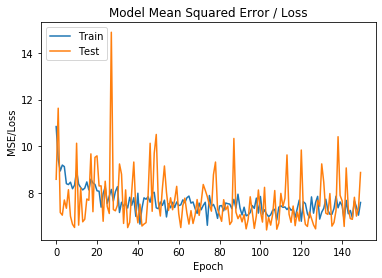

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Mean Squared Error / Loss')
plt.ylabel('MSE/Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

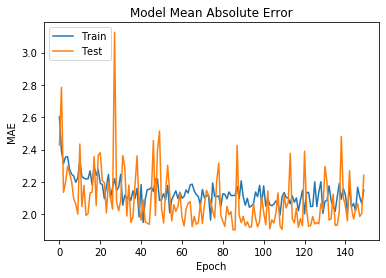

In [18]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [19]:
import gc
del train_gen
del valid_gen
del X_train
del y_train
del train_df
gc.collect()


6299

In [20]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [21]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [22]:
test_data, test_ids = load_test()

In [23]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

(2624, 150000, 1)

Load best model and predict

In [24]:
y_pred = model.predict(X_test)

In [25]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [26]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>

